In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../../..")

# Third party imports
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder


from librep.transforms import UMAP
from tabulate import tabulate

2022-10-22 20:03:46.298263: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 20:03:46.298283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from Experiments_topoae_KuHar20Hz_helper import *
kuhar_data = obtainKuHar20Hz()
train_HD = kuhar_data['train_HD']
train_LD = kuhar_data['train_LD']
train_Y = kuhar_data['train_Y']
test_HD = kuhar_data['test_HD']
test_LD = kuhar_data['test_LD']
test_Y = kuhar_data['test_Y']

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [5]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1000)': ['-']*9,
    'Topo-AEv2 (L=10000)': ['-']*9,
    'M-AE (L=1000)': ['-']*9,
    'M-AE (L=10000)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤══════════════════════╤═══════════════════════╤═════════════════╤══════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1000)   │ Topo-AEv2 (L=10000)   │ M-AE (L=1000)   │ M-AE (L=10000)   │
╞═════════════════╪════════╪══════════════╪══════════════════════╪═══════════════════════╪═════════════════╪══════════════════╡
│ RF-ACC          │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ RF-F1           │ -      │ -            │ -                    │ -                     │ -               │ -                │
├─────────────────┼────────┼──────────────┼──────────────────────┼───────────────────────┼─────────────────┼──────────────────┤
│ SVC-ACC         │ -      │ -            │ -                    │ -                     │ -            

# Visualization helper

In [6]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [9]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [10]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [11]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Exploring Topological AE (lambdas)

In [12]:
lambdas_to_explore = [1, 10, 100, 1000, 5000, 10000]
# lambdas_to_explore = [10, 100, 500]
executions_per_model = 10

def explore_lambda(train_HD, train_Y, test_HD, test_Y, topoae_lambda, times_to_execute=10):
    result_object = {
        'RF-ACC': [],
        'RF-F1': [],
        'SVC-ACC': [],
        'SVC-F1': [],
        'KNN-ACC': [],
        'KNN-F1': [],
        'Trustworthiness': [],
        'Continuity': [],
        'Co-k-NNs': []   
    }
    for _ in range(times_to_execute):
        kwargs = {'input_dims':180, 'custom_dim':2}
        input_shape = (-1, 1, 180)
        topo_reducer = TopologicalDimensionalityReduction(
            ae_model='DeepAEforKuhar180ver2',
            lam=topoae_lambda,
            ae_kwargs=kwargs,
            input_shape=input_shape,
            patience=10
        )
        title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
        topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)
        train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
        test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
        experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
        metrics_reporter = DimensionalityReductionQualityReport()
        metrics_report = metrics_reporter.evaluate([test_HD, test_LD])
        
        result_object['RF-ACC'].append(experiments_result['RF-ACC'])
        result_object['RF-F1'].append(experiments_result['RF-F1'])
        result_object['SVC-ACC'].append(experiments_result['SVC-ACC'])
        result_object['SVC-F1'].append(experiments_result['SVC-F1'])
        result_object['KNN-ACC'].append(experiments_result['KNN-ACC'])
        result_object['KNN-F1'].append(experiments_result['KNN-F1'])
        
        result_object['Trustworthiness'].append(metrics_report['trustworthiness'])
        result_object['Continuity'].append(metrics_report['continuity'])
        result_object['Co-k-NNs'].append(metrics_report['co k nearest neighbor size'])
        
    for obj_property in result_object:
        mean_val = np.mean(result_object[obj_property])
        min_val = np.min(result_object[obj_property])
        max_val = np.max(result_object[obj_property])
        result_object[obj_property] = (min_val, mean_val, max_val)

    return result_object


Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:348.8758, Loss-ae:328.7232, Loss-topo:20.1526
Epoch:2, P:10, Loss:292.8142, Loss-ae:282.6189, Loss-topo:10.1953
Epoch:3, P:10, Loss:307.2813, Loss-ae:283.1776, Loss-topo:24.1037
Epoch:4, P:9, Loss:300.3974, Loss-ae:288.1390, Loss-topo:12.2585
Epoch:5, P:8, Loss:306.3420, Loss-ae:300.2607, Loss-topo:6.0813
Epoch:6, P:7, Loss:264.4736, Loss-ae:255.4163, Loss-topo:9.0573
Epoch:7, P:10, Loss:240.2552, Loss-ae:238.4182, Loss-topo:1.8370
Epoch:8, P:10, Loss:277.3363, Loss-ae:274.3408, Loss-topo:2.9954
Epoch:9, P:9, Loss:220.0658, Loss-ae:217.4419, Loss-topo:2.6240
Epoch:10, P:10, Loss:236.0987, Loss-ae:231.8609, Loss-topo:4.2378
Epoch:11, P:9, Loss:253.5608, Loss-ae:248.8477, Loss-topo:4.7131
Epoch:12, P:8, Loss:218.4693, Loss-ae:216.1146, Loss-topo:2.3548
Epoch:13, P:10, Loss:181.5395, Loss-ae:178.0797, Loss-topo:3.4598
Epoch:14, P:10, Loss:18

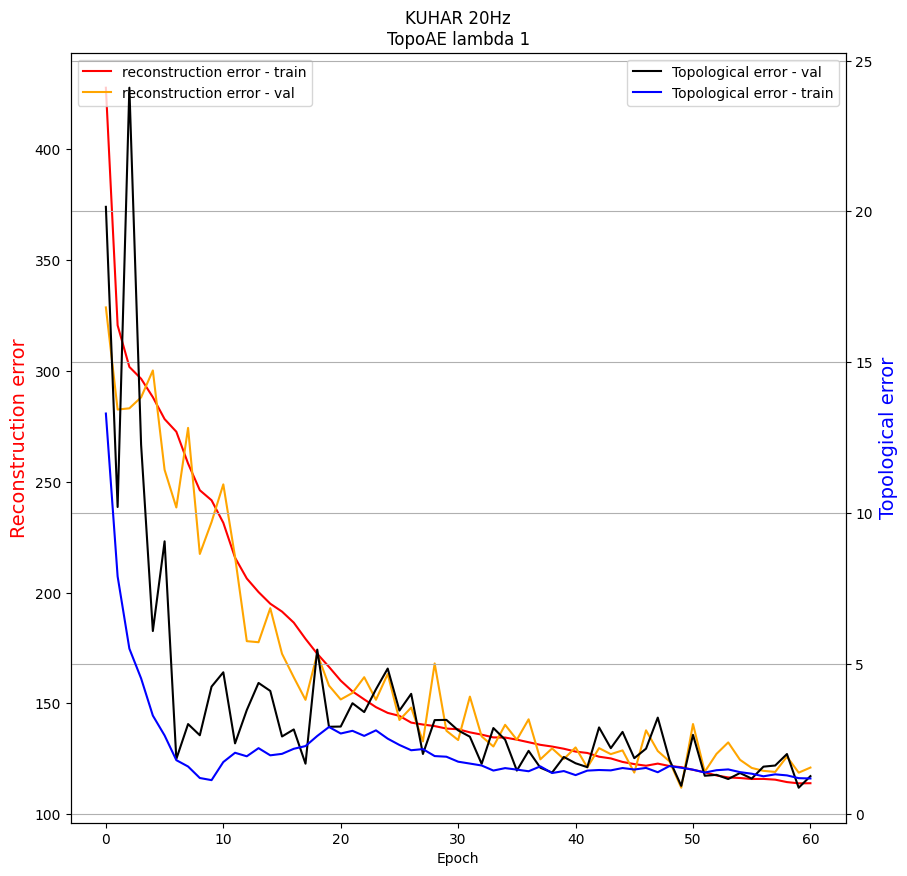

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:346.6188, Loss-ae:331.0650, Loss-topo:15.5539
Epoch:2, P:10, Loss:310.0601, Loss-ae:300.6498, Loss-topo:9.4102
Epoch:3, P:10, Loss:263.4890, Loss-ae:258.0518, Loss-topo:5.4372
Epoch:4, P:10, Loss:301.2574, Loss-ae:292.4788, Loss-topo:8.7786
Epoch:5, P:9, Loss:287.5472, Loss-ae:280.6499, Loss-topo:6.8973
Epoch:6, P:8, Loss:305.6022, Loss-ae:301.5585, Loss-topo:4.0437
Epoch:7, P:7, Loss:243.9539, Loss-ae:240.8644, Loss-topo:3.0895
Epoch:8, P:10, Loss:338.3302, Loss-ae:334.1231, Loss-topo:4.2071
Epoch:9, P:9, Loss:221.7242, Loss-ae:212.6488, Loss-topo:9.0754
Epoch:10, P:10, Loss:227.9745, Loss-ae:223.1936, Loss-topo:4.7809
Epoch:11, P:9, Loss:184.5758, Loss-ae:181.1458, Loss-topo:3.4300
Epoch:12, P:10, Loss:165.4509, Loss-ae:163.4317, Loss-topo:2.0192
Epoch:13, P:10, Loss:185.2647, Loss-ae:178.5236, Loss-topo:6.7411
Epoch:14, P:9, Loss:160.1

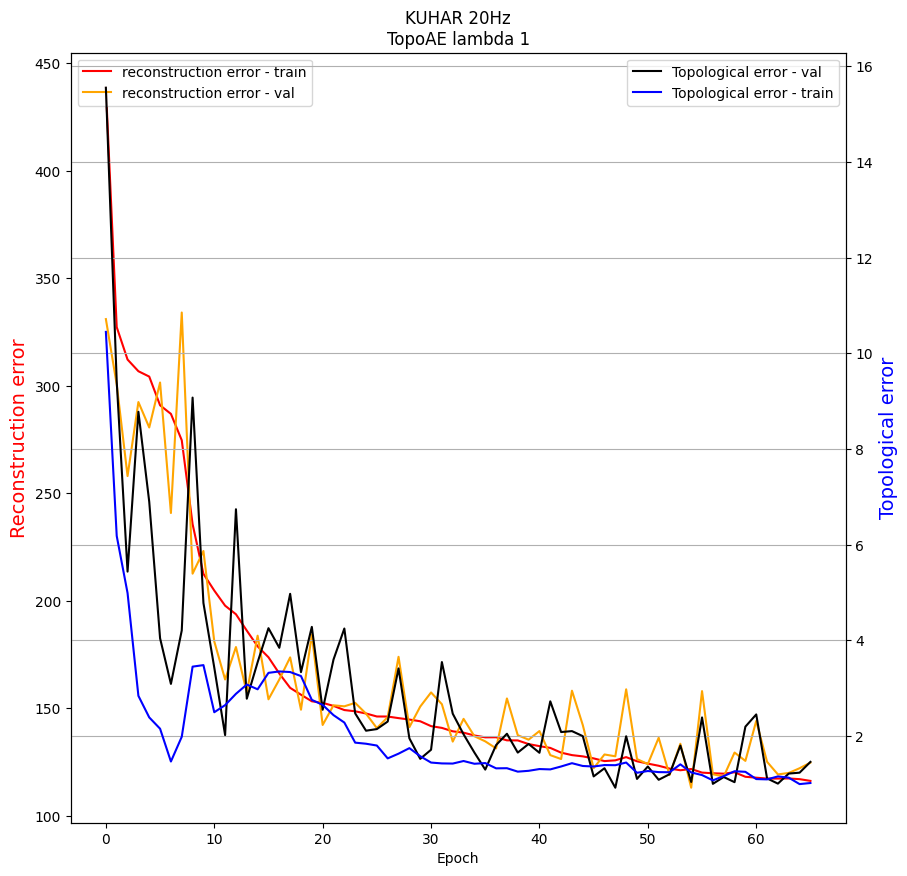

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:312.4209, Loss-ae:292.1974, Loss-topo:20.2235
Epoch:2, P:10, Loss:299.3645, Loss-ae:273.7897, Loss-topo:25.5748
Epoch:3, P:10, Loss:259.3243, Loss-ae:244.5131, Loss-topo:14.8112
Epoch:4, P:10, Loss:294.8394, Loss-ae:285.3108, Loss-topo:9.5286
Epoch:5, P:9, Loss:266.2959, Loss-ae:262.6721, Loss-topo:3.6238
Epoch:6, P:8, Loss:246.9964, Loss-ae:242.1576, Loss-topo:4.8388
Epoch:7, P:10, Loss:236.1536, Loss-ae:232.5047, Loss-topo:3.6488
Epoch:8, P:10, Loss:234.3032, Loss-ae:228.4472, Loss-topo:5.8560
Epoch:9, P:10, Loss:282.0620, Loss-ae:279.7516, Loss-topo:2.3103
Epoch:10, P:9, Loss:230.5888, Loss-ae:229.4448, Loss-topo:1.1439
Epoch:11, P:10, Loss:218.9342, Loss-ae:216.5112, Loss-topo:2.4230
Epoch:12, P:10, Loss:239.9732, Loss-ae:237.3903, Loss-topo:2.5829
Epoch:13, P:9, Loss:212.4122, Loss-ae:209.3346, Loss-topo:3.0777
Epoch:14, P:10, Loss:1

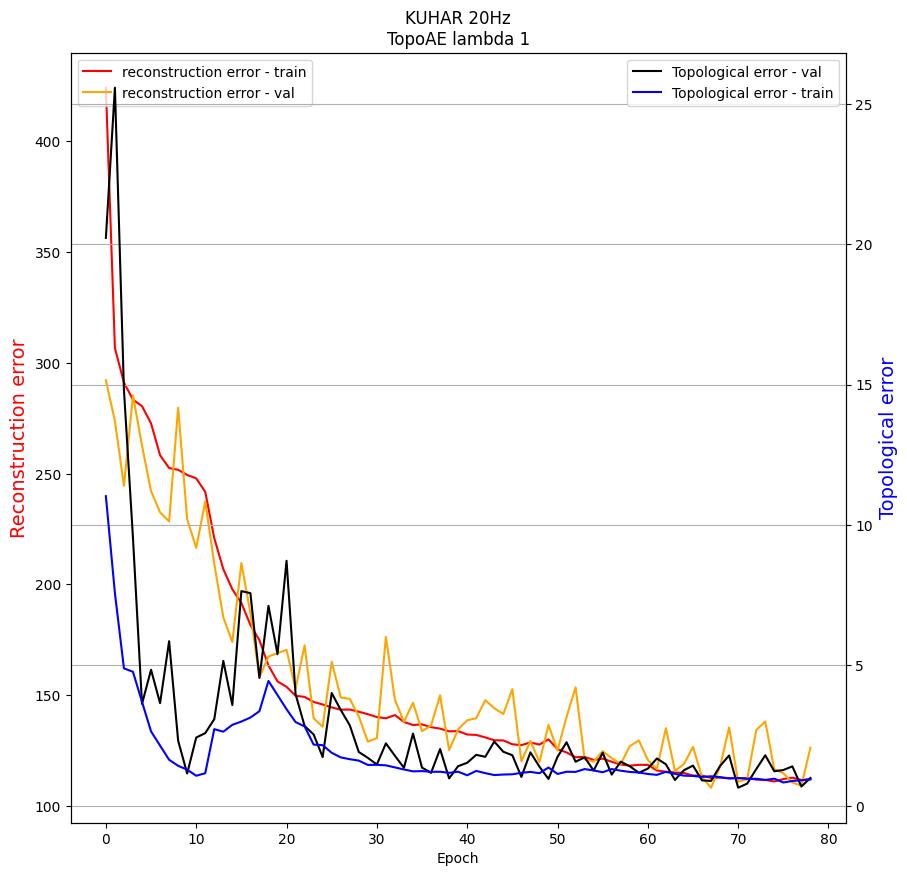

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:353.2782, Loss-ae:316.2747, Loss-topo:37.0036
Epoch:2, P:10, Loss:305.1645, Loss-ae:284.6981, Loss-topo:20.4663
Epoch:3, P:10, Loss:263.0821, Loss-ae:258.2835, Loss-topo:4.7986
Epoch:4, P:10, Loss:250.3512, Loss-ae:248.2802, Loss-topo:2.0710
Epoch:5, P:10, Loss:273.0596, Loss-ae:270.4668, Loss-topo:2.5928
Epoch:6, P:9, Loss:272.9567, Loss-ae:263.4893, Loss-topo:9.4674
Epoch:7, P:8, Loss:261.8234, Loss-ae:258.2412, Loss-topo:3.5822
Epoch:8, P:7, Loss:228.3625, Loss-ae:227.2025, Loss-topo:1.1599
Epoch:9, P:10, Loss:232.1711, Loss-ae:228.8017, Loss-topo:3.3694
Epoch:10, P:9, Loss:210.7552, Loss-ae:205.1998, Loss-topo:5.5555
Epoch:11, P:10, Loss:201.1427, Loss-ae:196.3657, Loss-topo:4.7770
Epoch:12, P:10, Loss:172.2595, Loss-ae:169.7781, Loss-topo:2.4814
Epoch:13, P:10, Loss:180.4166, Loss-ae:177.4874, Loss-topo:2.9292
Epoch:14, P:9, Loss:190

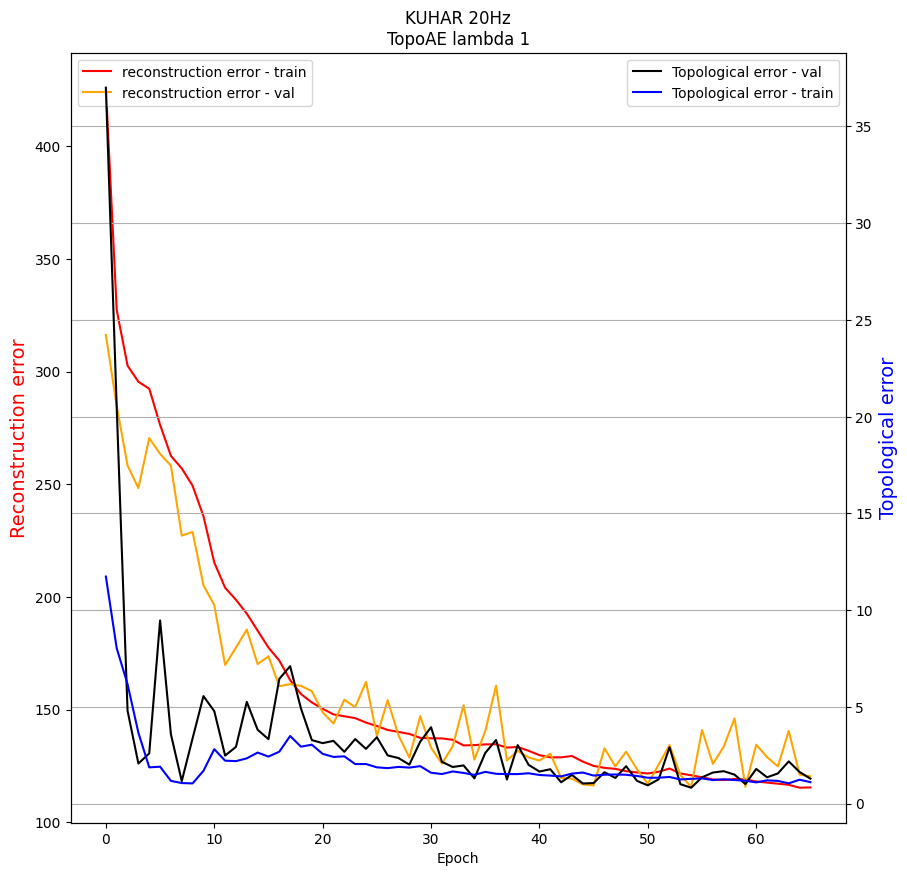

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:315.9820, Loss-ae:311.8967, Loss-topo:4.0853
Epoch:2, P:10, Loss:322.0603, Loss-ae:312.3651, Loss-topo:9.6952
Epoch:3, P:9, Loss:348.1960, Loss-ae:340.3406, Loss-topo:7.8555
Epoch:4, P:8, Loss:314.0601, Loss-ae:309.9624, Loss-topo:4.0976
Epoch:5, P:10, Loss:328.5994, Loss-ae:325.0501, Loss-topo:3.5493
Epoch:6, P:9, Loss:312.5858, Loss-ae:310.8053, Loss-topo:1.7805
Epoch:7, P:10, Loss:284.3411, Loss-ae:282.6429, Loss-topo:1.6982
Epoch:8, P:10, Loss:303.6861, Loss-ae:299.0778, Loss-topo:4.6083
Epoch:9, P:9, Loss:213.0058, Loss-ae:211.9400, Loss-topo:1.0657
Epoch:10, P:10, Loss:219.4208, Loss-ae:215.2959, Loss-topo:4.1249
Epoch:11, P:9, Loss:195.0952, Loss-ae:192.7534, Loss-topo:2.3418
Epoch:12, P:10, Loss:172.9441, Loss-ae:170.5252, Loss-topo:2.4189
Epoch:13, P:10, Loss:204.0947, Loss-ae:198.7012, Loss-topo:5.3935
Epoch:14, P:9, Loss:171.45

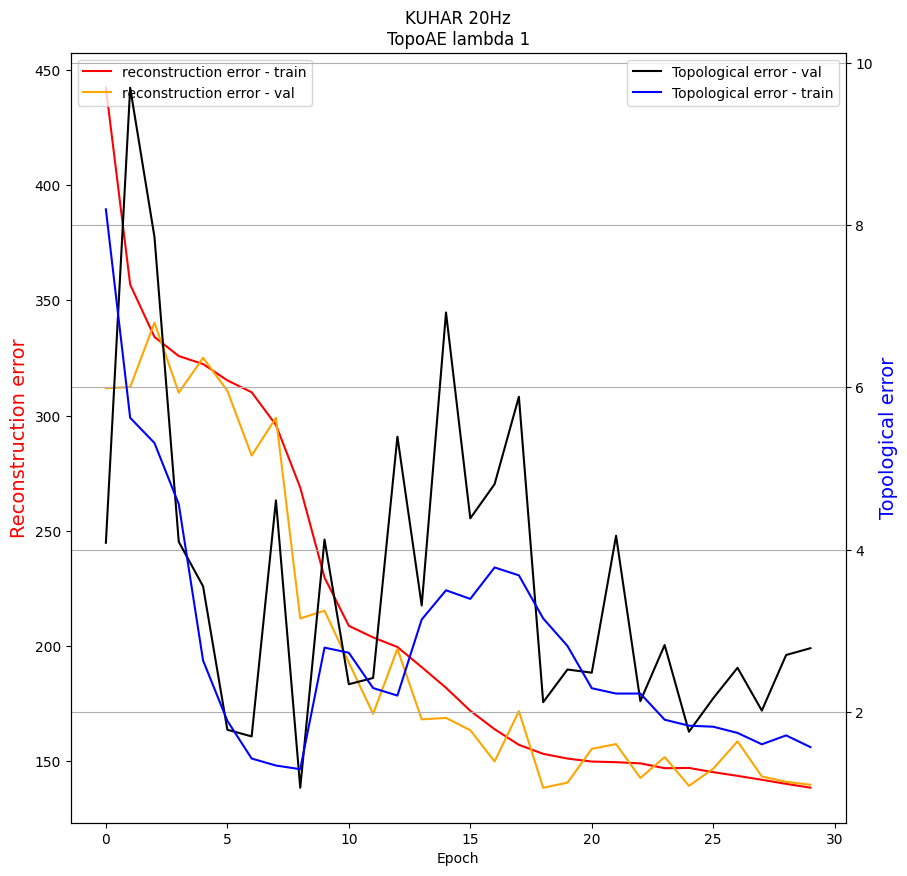

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:378.6986, Loss-ae:349.9188, Loss-topo:28.7798
Epoch:2, P:10, Loss:281.1617, Loss-ae:247.8534, Loss-topo:33.3083
Epoch:3, P:10, Loss:307.5635, Loss-ae:297.3916, Loss-topo:10.1719
Epoch:4, P:9, Loss:229.1559, Loss-ae:224.6980, Loss-topo:4.4579
Epoch:5, P:10, Loss:233.8403, Loss-ae:228.9647, Loss-topo:4.8756
Epoch:6, P:9, Loss:222.8236, Loss-ae:220.1890, Loss-topo:2.6346
Epoch:7, P:10, Loss:265.5261, Loss-ae:259.0947, Loss-topo:6.4315
Epoch:8, P:9, Loss:225.5028, Loss-ae:219.7886, Loss-topo:5.7141
Epoch:9, P:8, Loss:203.1549, Loss-ae:202.0199, Loss-topo:1.1349
Epoch:10, P:10, Loss:209.4428, Loss-ae:207.1082, Loss-topo:2.3345
Epoch:11, P:9, Loss:211.6639, Loss-ae:207.3815, Loss-topo:4.2824
Epoch:12, P:8, Loss:201.2606, Loss-ae:194.9179, Loss-topo:6.3427
Epoch:13, P:10, Loss:184.0802, Loss-ae:182.3549, Loss-topo:1.7253
Epoch:14, P:10, Loss:172

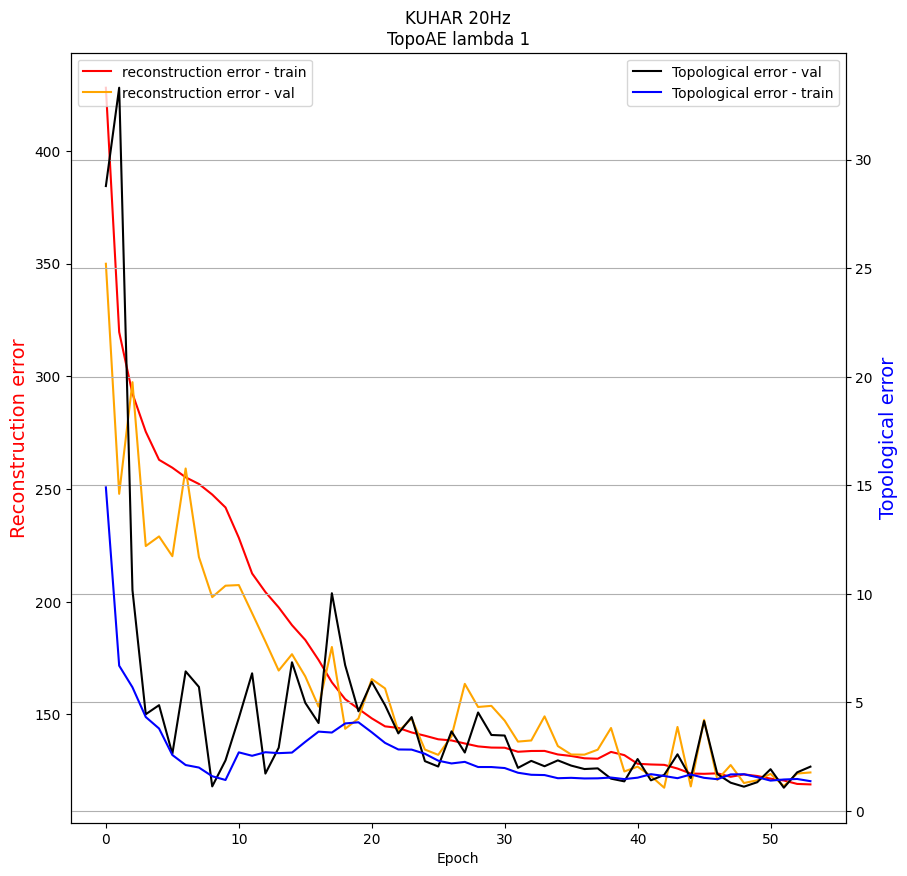

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:324.6435, Loss-ae:305.2425, Loss-topo:19.4010
Epoch:2, P:10, Loss:276.3499, Loss-ae:255.7133, Loss-topo:20.6366
Epoch:3, P:10, Loss:346.0831, Loss-ae:331.5009, Loss-topo:14.5822
Epoch:4, P:9, Loss:236.4478, Loss-ae:233.7760, Loss-topo:2.6718
Epoch:5, P:10, Loss:222.6920, Loss-ae:220.7357, Loss-topo:1.9563
Epoch:6, P:10, Loss:241.8349, Loss-ae:238.5117, Loss-topo:3.3231
Epoch:7, P:9, Loss:232.8291, Loss-ae:230.8091, Loss-topo:2.0201
Epoch:8, P:8, Loss:241.0071, Loss-ae:235.2208, Loss-topo:5.7863
Epoch:9, P:7, Loss:213.2865, Loss-ae:211.2343, Loss-topo:2.0522
Epoch:10, P:10, Loss:197.6863, Loss-ae:196.6424, Loss-topo:1.0439
Epoch:11, P:10, Loss:179.2320, Loss-ae:178.0595, Loss-topo:1.1726
Epoch:12, P:10, Loss:276.1733, Loss-ae:273.2288, Loss-topo:2.9446
Epoch:13, P:9, Loss:188.8160, Loss-ae:186.2570, Loss-topo:2.5590
Epoch:14, P:8, Loss:219

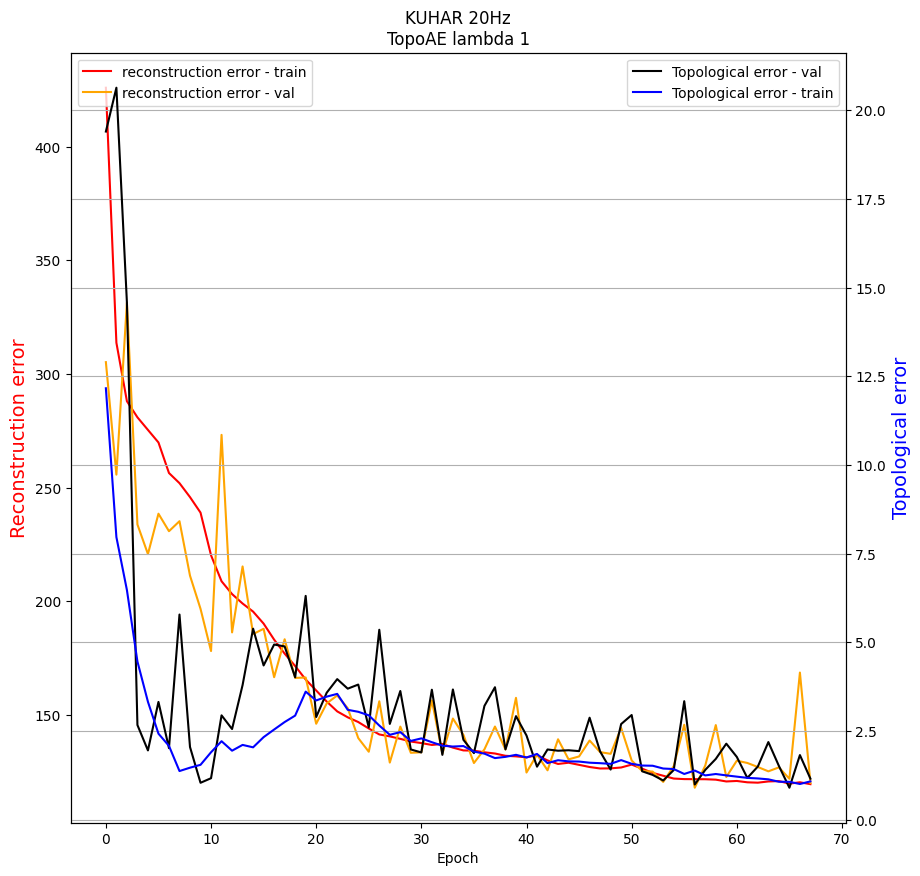

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:345.0219, Loss-ae:319.5671, Loss-topo:25.4548
Epoch:2, P:10, Loss:288.5400, Loss-ae:274.9524, Loss-topo:13.5877
Epoch:3, P:10, Loss:275.2988, Loss-ae:261.9480, Loss-topo:13.3508
Epoch:4, P:10, Loss:257.7384, Loss-ae:254.5550, Loss-topo:3.1834
Epoch:5, P:10, Loss:260.9217, Loss-ae:257.0105, Loss-topo:3.9111
Epoch:6, P:9, Loss:235.5714, Loss-ae:234.3781, Loss-topo:1.1934
Epoch:7, P:10, Loss:240.2402, Loss-ae:238.9276, Loss-topo:1.3126
Epoch:8, P:9, Loss:258.7157, Loss-ae:256.1486, Loss-topo:2.5671
Epoch:9, P:8, Loss:235.3489, Loss-ae:231.6243, Loss-topo:3.7246
Epoch:10, P:10, Loss:202.2400, Loss-ae:200.0418, Loss-topo:2.1982
Epoch:11, P:10, Loss:186.1988, Loss-ae:183.3962, Loss-topo:2.8027
Epoch:12, P:10, Loss:184.9921, Loss-ae:182.6867, Loss-topo:2.3054
Epoch:13, P:10, Loss:182.0538, Loss-ae:178.8123, Loss-topo:3.2414
Epoch:14, P:10, Loss:

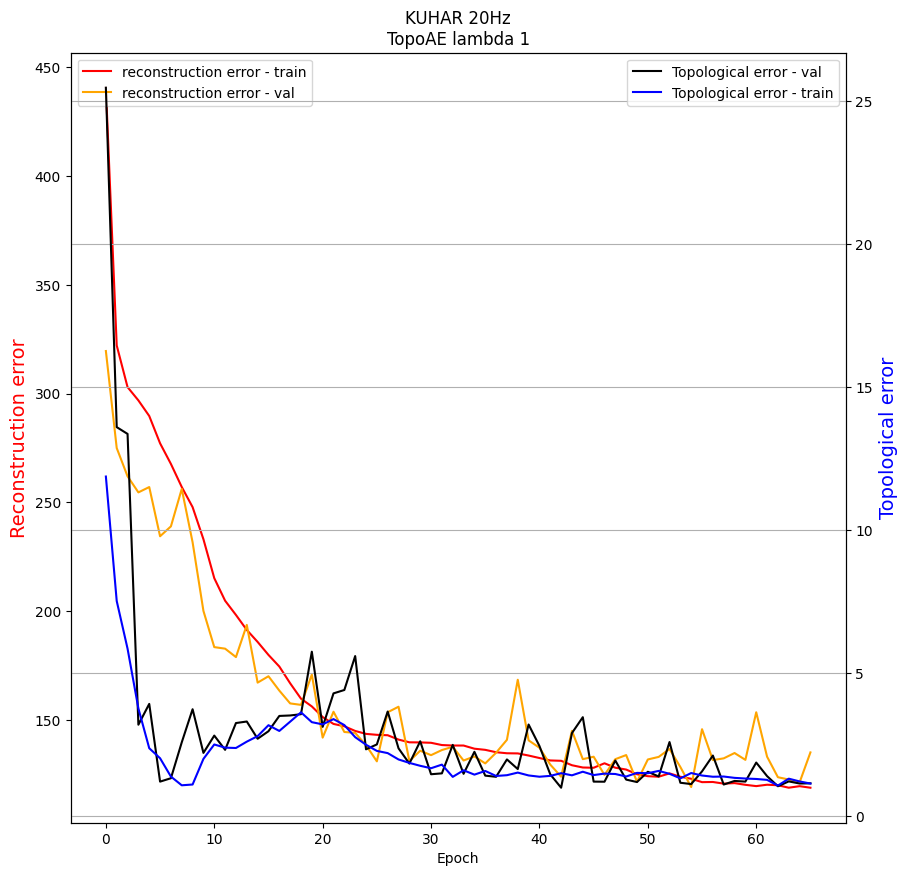

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:322.7739, Loss-ae:287.7591, Loss-topo:35.0148
Epoch:2, P:10, Loss:347.1692, Loss-ae:313.8971, Loss-topo:33.2722
Epoch:3, P:9, Loss:271.1684, Loss-ae:266.5727, Loss-topo:4.5957
Epoch:4, P:10, Loss:244.8964, Loss-ae:239.1977, Loss-topo:5.6987
Epoch:5, P:10, Loss:237.8065, Loss-ae:230.7280, Loss-topo:7.0785
Epoch:6, P:10, Loss:251.1470, Loss-ae:240.5427, Loss-topo:10.6043
Epoch:7, P:9, Loss:269.0126, Loss-ae:263.6484, Loss-topo:5.3642
Epoch:8, P:8, Loss:246.4114, Loss-ae:241.8254, Loss-topo:4.5859
Epoch:9, P:7, Loss:212.3491, Loss-ae:211.2034, Loss-topo:1.1457
Epoch:10, P:10, Loss:219.5959, Loss-ae:210.3756, Loss-topo:9.2202
Epoch:11, P:9, Loss:183.8039, Loss-ae:181.0043, Loss-topo:2.7996
Epoch:12, P:10, Loss:177.2230, Loss-ae:175.1887, Loss-topo:2.0343
Epoch:13, P:10, Loss:196.1843, Loss-ae:191.4043, Loss-topo:4.7800
Epoch:14, P:9, Loss:174

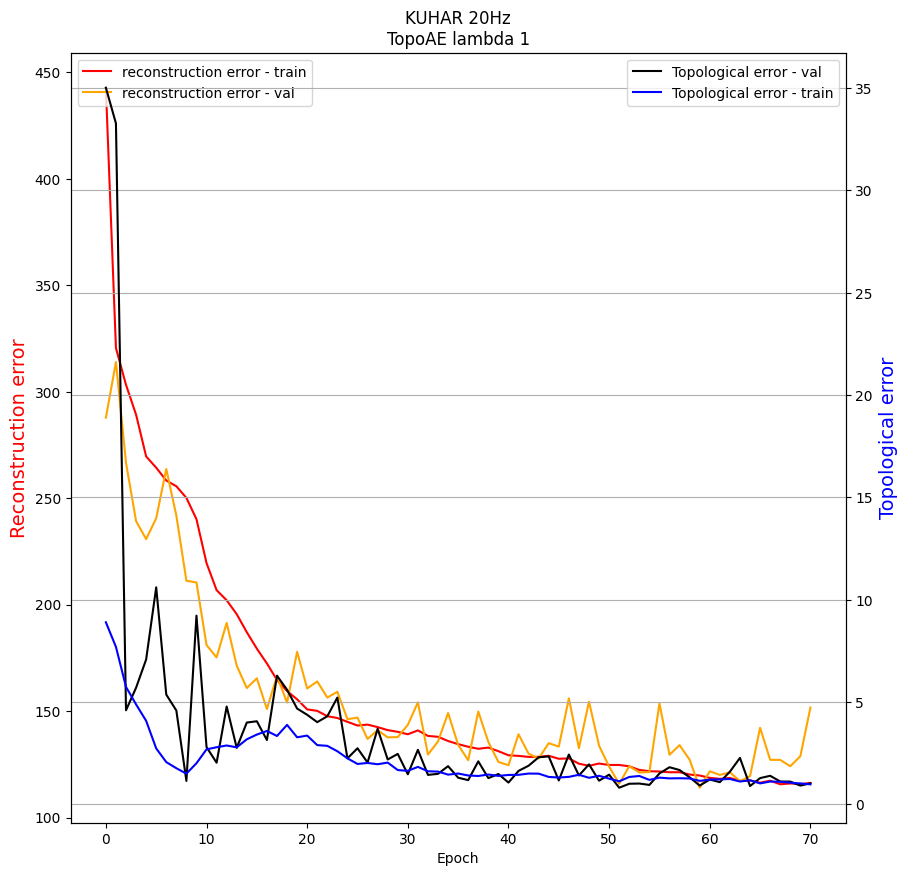

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:337.0107, Loss-ae:327.2472, Loss-topo:9.7635
Epoch:2, P:10, Loss:280.5893, Loss-ae:273.6370, Loss-topo:6.9523
Epoch:3, P:10, Loss:303.4256, Loss-ae:281.2184, Loss-topo:22.2072
Epoch:4, P:9, Loss:296.3039, Loss-ae:287.9963, Loss-topo:8.3077
Epoch:5, P:8, Loss:265.8608, Loss-ae:263.7404, Loss-topo:2.1204
Epoch:6, P:10, Loss:246.1573, Loss-ae:244.6336, Loss-topo:1.5237
Epoch:7, P:10, Loss:251.9599, Loss-ae:250.6541, Loss-topo:1.3058
Epoch:8, P:9, Loss:220.2120, Loss-ae:219.2592, Loss-topo:0.9528
Epoch:9, P:10, Loss:215.1295, Loss-ae:213.8599, Loss-topo:1.2696
Epoch:10, P:10, Loss:214.5112, Loss-ae:213.0325, Loss-topo:1.4787
Epoch:11, P:10, Loss:213.2427, Loss-ae:208.4561, Loss-topo:4.7866
Epoch:12, P:10, Loss:227.9045, Loss-ae:221.6985, Loss-topo:6.2060
Epoch:13, P:9, Loss:173.5615, Loss-ae:169.5849, Loss-topo:3.9766
Epoch:14, P:10, Loss:199

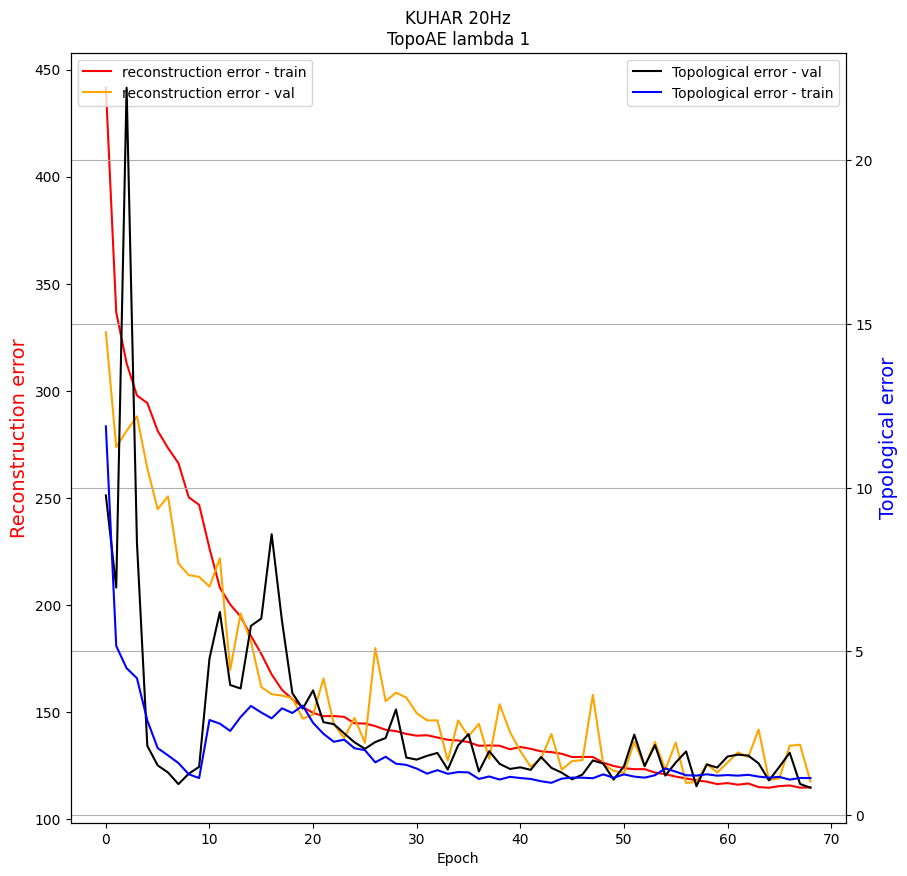

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:328.7690, Loss-ae:299.3471, Loss-topo:2.9422
Epoch:2, P:10, Loss:274.4680, Loss-ae:259.6561, Loss-topo:1.4812
Epoch:3, P:10, Loss:299.6957, Loss-ae:282.8840, Loss-topo:1.6812
Epoch:4, P:9, Loss:247.0565, Loss-ae:242.1593, Loss-topo:0.4897
Epoch:5, P:10, Loss:234.5157, Loss-ae:231.5543, Loss-topo:0.2961
Epoch:6, P:10, Loss:275.5359, Loss-ae:272.7930, Loss-topo:0.2743
Epoch:7, P:9, Loss:256.4668, Loss-ae:250.7211, Loss-topo:0.5746
Epoch:8, P:8, Loss:229.2955, Loss-ae:227.9546, Loss-topo:0.1341
Epoch:9, P:10, Loss:220.4837, Loss-ae:216.9708, Loss-topo:0.3513
Epoch:10, P:10, Loss:203.3666, Loss-ae:202.0300, Loss-topo:0.1337
Epoch:11, P:10, Loss:247.4139, Loss-ae:243.9460, Loss-topo:0.3468
Epoch:12, P:9, Loss:190.6374, Loss-ae:187.7784, Loss-topo:0.2859
Epoch:13, P:10, Loss:234.7063, Loss-ae:230.8797, Loss-topo:0.3827
Epoch:14, P:9, Loss:190.5

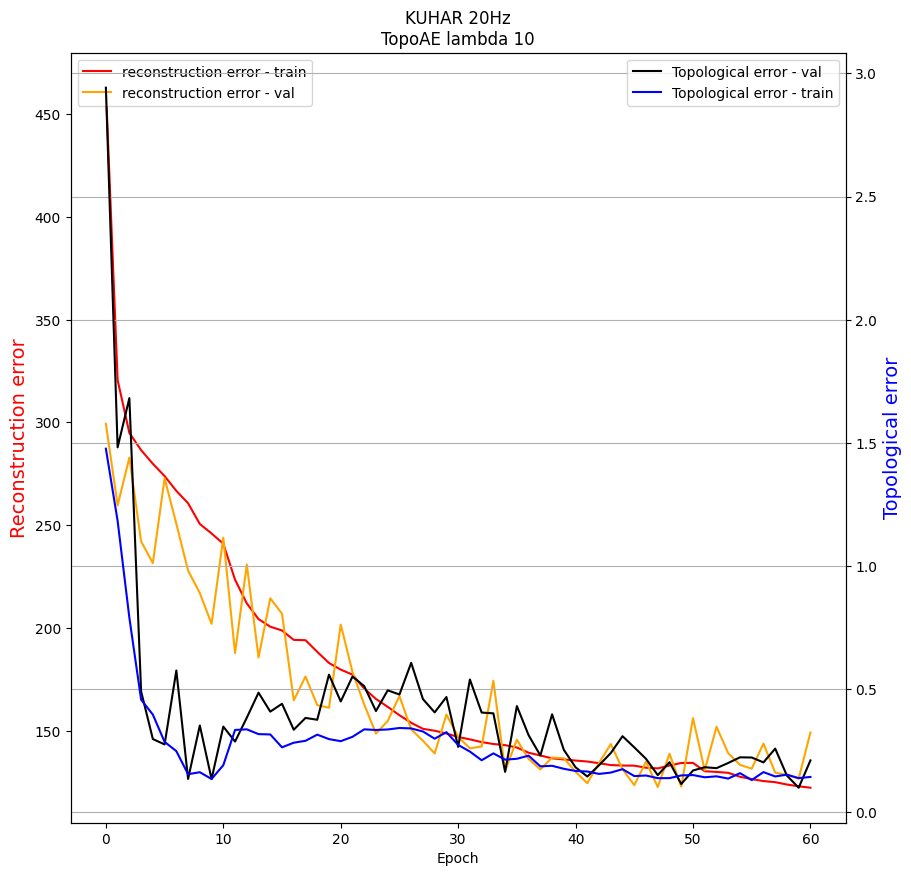

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:389.0070, Loss-ae:334.4976, Loss-topo:5.4509
Epoch:2, P:10, Loss:326.0258, Loss-ae:297.1981, Loss-topo:2.8828
Epoch:3, P:10, Loss:264.4170, Loss-ae:259.3560, Loss-topo:0.5061
Epoch:4, P:10, Loss:318.0805, Loss-ae:311.2379, Loss-topo:0.6843
Epoch:5, P:9, Loss:302.5083, Loss-ae:299.0008, Loss-topo:0.3508
Epoch:6, P:8, Loss:279.5664, Loss-ae:276.4850, Loss-topo:0.3081
Epoch:7, P:7, Loss:248.9643, Loss-ae:239.4823, Loss-topo:0.9482
Epoch:8, P:10, Loss:249.2503, Loss-ae:245.3563, Loss-topo:0.3894
Epoch:9, P:9, Loss:234.9608, Loss-ae:231.5787, Loss-topo:0.3382
Epoch:10, P:10, Loss:201.5313, Loss-ae:197.4918, Loss-topo:0.4039
Epoch:11, P:10, Loss:209.5869, Loss-ae:205.7683, Loss-topo:0.3819
Epoch:12, P:9, Loss:181.0685, Loss-ae:178.5879, Loss-topo:0.2481
Epoch:13, P:10, Loss:174.6634, Loss-ae:171.6439, Loss-topo:0.3020
Epoch:14, P:10, Loss:189.4

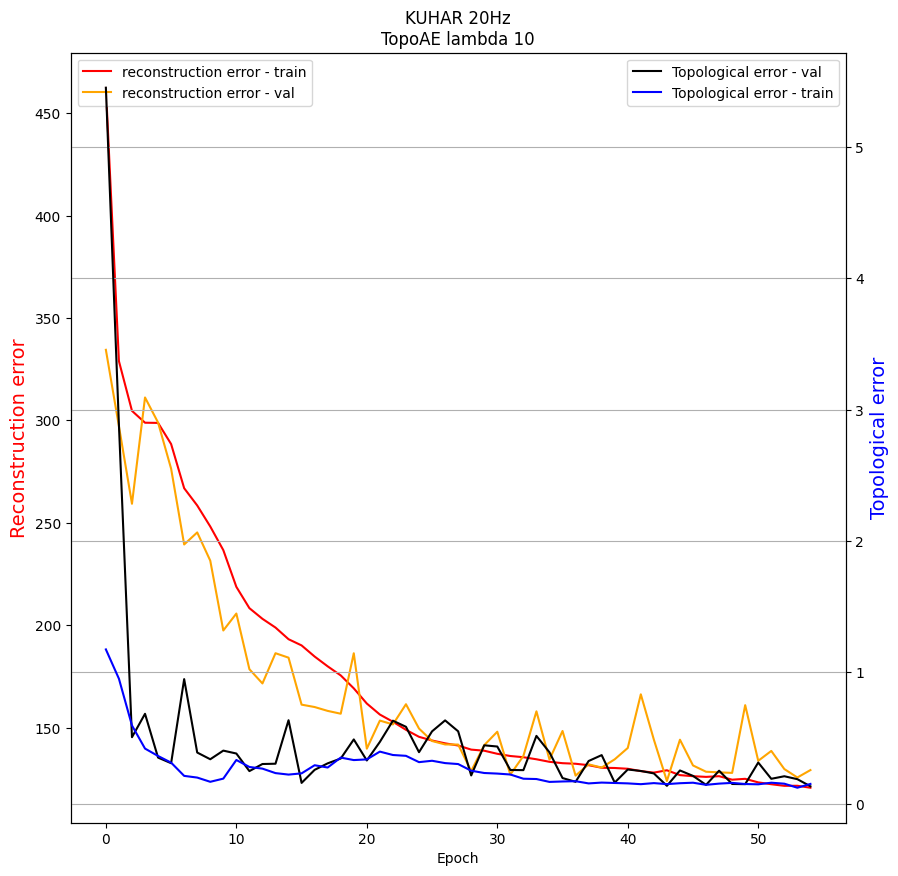

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:337.3524, Loss-ae:297.8804, Loss-topo:3.9472
Epoch:2, P:10, Loss:250.3669, Loss-ae:239.0204, Loss-topo:1.1347
Epoch:3, P:10, Loss:272.0827, Loss-ae:265.2187, Loss-topo:0.6864
Epoch:4, P:9, Loss:240.9960, Loss-ae:234.9142, Loss-topo:0.6082
Epoch:5, P:10, Loss:261.0157, Loss-ae:256.7397, Loss-topo:0.4276
Epoch:6, P:9, Loss:269.4856, Loss-ae:261.0080, Loss-topo:0.8478
Epoch:7, P:8, Loss:234.9636, Loss-ae:232.6899, Loss-topo:0.2274
Epoch:8, P:10, Loss:213.8064, Loss-ae:212.6466, Loss-topo:0.1160
Epoch:9, P:10, Loss:254.0666, Loss-ae:250.0950, Loss-topo:0.3972
Epoch:10, P:9, Loss:229.6458, Loss-ae:222.0747, Loss-topo:0.7571
Epoch:11, P:8, Loss:195.6554, Loss-ae:190.9463, Loss-topo:0.4709
Epoch:12, P:10, Loss:195.3768, Loss-ae:192.9644, Loss-topo:0.2412
Epoch:13, P:10, Loss:195.2370, Loss-ae:191.5367, Loss-topo:0.3700
Epoch:14, P:10, Loss:184.3

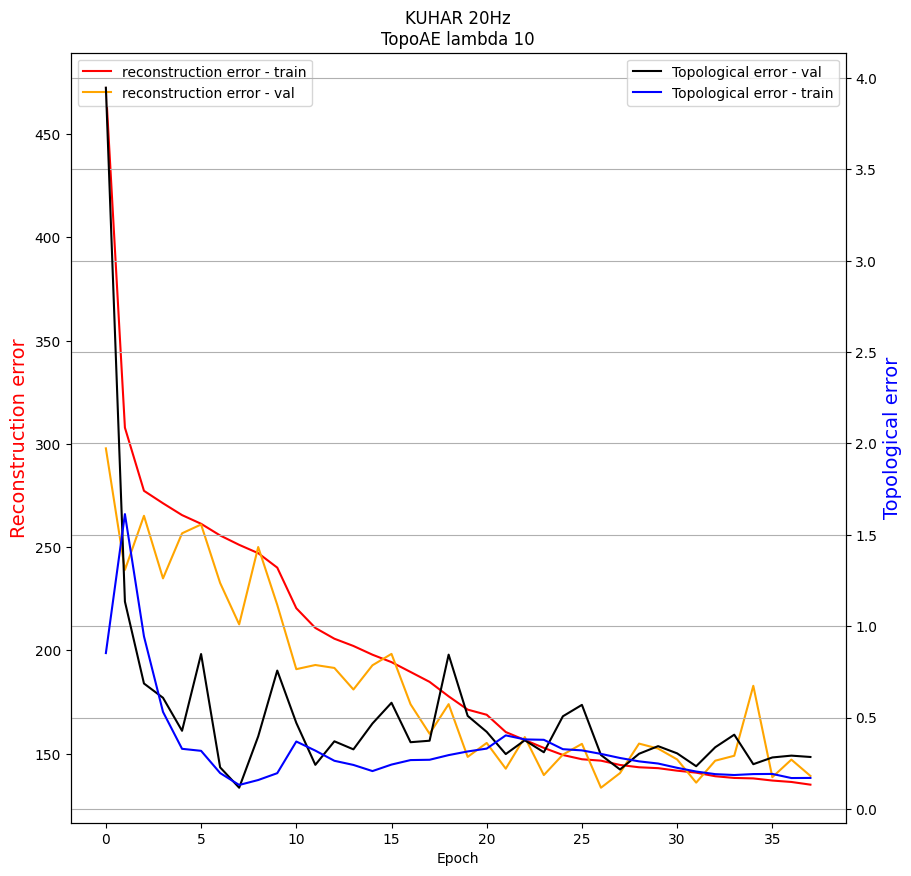

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:405.6788, Loss-ae:333.3305, Loss-topo:7.2348
Epoch:2, P:10, Loss:338.4333, Loss-ae:325.0837, Loss-topo:1.3350
Epoch:3, P:10, Loss:267.4554, Loss-ae:252.5039, Loss-topo:1.4951
Epoch:4, P:10, Loss:238.4865, Loss-ae:233.7637, Loss-topo:0.4723
Epoch:5, P:10, Loss:288.1693, Loss-ae:274.3307, Loss-topo:1.3839
Epoch:6, P:9, Loss:248.4751, Loss-ae:244.8411, Loss-topo:0.3634
Epoch:7, P:8, Loss:251.9398, Loss-ae:249.0017, Loss-topo:0.2938
Epoch:8, P:7, Loss:228.8406, Loss-ae:226.9523, Loss-topo:0.1888
Epoch:9, P:10, Loss:238.1502, Loss-ae:231.5429, Loss-topo:0.6607
Epoch:10, P:9, Loss:229.6309, Loss-ae:227.8801, Loss-topo:0.1751
Epoch:11, P:8, Loss:224.3681, Loss-ae:220.2566, Loss-topo:0.4112
Epoch:12, P:10, Loss:219.6804, Loss-ae:215.4325, Loss-topo:0.4248
Epoch:13, P:10, Loss:218.6230, Loss-ae:215.1453, Loss-topo:0.3478
Epoch:14, P:10, Loss:198.3

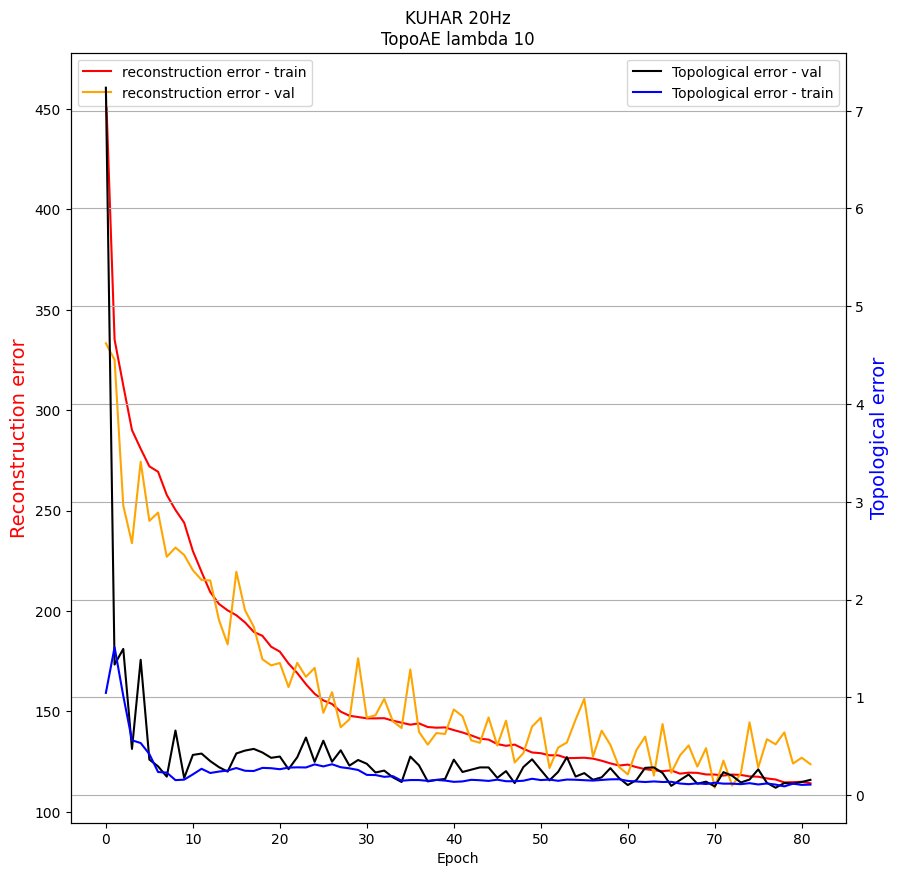

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:420.7269, Loss-ae:362.6931, Loss-topo:5.8034
Epoch:2, P:10, Loss:330.9856, Loss-ae:307.9558, Loss-topo:2.3030
Epoch:3, P:10, Loss:340.8165, Loss-ae:319.0845, Loss-topo:2.1732
Epoch:4, P:9, Loss:255.0058, Loss-ae:248.8210, Loss-topo:0.6185
Epoch:5, P:10, Loss:302.6797, Loss-ae:289.9589, Loss-topo:1.2721
Epoch:6, P:9, Loss:233.8949, Loss-ae:232.3501, Loss-topo:0.1545
Epoch:7, P:10, Loss:276.1640, Loss-ae:268.4150, Loss-topo:0.7749
Epoch:8, P:9, Loss:214.4998, Loss-ae:210.9757, Loss-topo:0.3524
Epoch:9, P:10, Loss:258.3038, Loss-ae:252.9477, Loss-topo:0.5356
Epoch:10, P:9, Loss:211.8031, Loss-ae:209.4579, Loss-topo:0.2345
Epoch:11, P:10, Loss:199.1799, Loss-ae:193.3199, Loss-topo:0.5860
Epoch:12, P:10, Loss:179.8221, Loss-ae:177.7649, Loss-topo:0.2057
Epoch:13, P:10, Loss:224.7365, Loss-ae:220.1059, Loss-topo:0.4631
Epoch:14, P:9, Loss:176.5

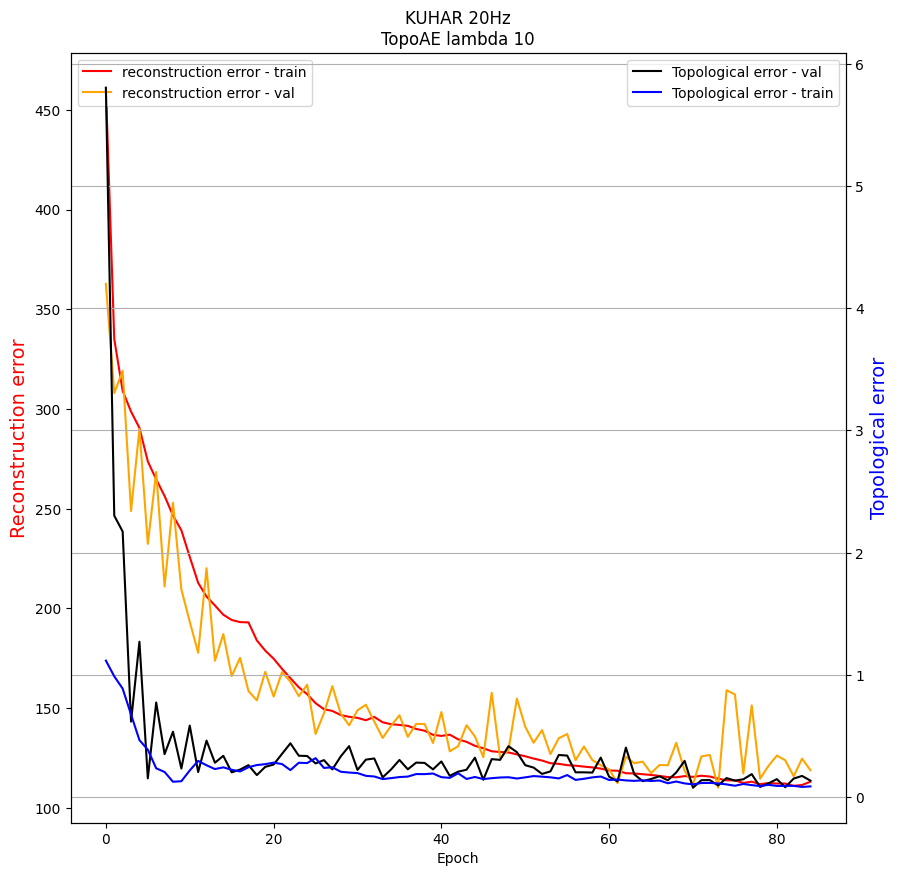

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:474.1711, Loss-ae:344.0740, Loss-topo:13.0097
Epoch:2, P:10, Loss:305.8567, Loss-ae:294.1927, Loss-topo:1.1664
Epoch:3, P:10, Loss:332.7331, Loss-ae:286.3804, Loss-topo:4.6353
Epoch:4, P:9, Loss:251.8026, Loss-ae:245.2402, Loss-topo:0.6562
Epoch:5, P:10, Loss:276.7976, Loss-ae:264.0460, Loss-topo:1.2752
Epoch:6, P:9, Loss:306.3907, Loss-ae:302.1260, Loss-topo:0.4265
Epoch:7, P:8, Loss:281.8402, Loss-ae:278.5913, Loss-topo:0.3249
Epoch:8, P:7, Loss:242.4197, Loss-ae:237.3221, Loss-topo:0.5098
Epoch:9, P:10, Loss:209.0118, Loss-ae:207.7893, Loss-topo:0.1223
Epoch:10, P:10, Loss:240.8320, Loss-ae:233.2261, Loss-topo:0.7606
Epoch:11, P:9, Loss:182.9660, Loss-ae:180.7364, Loss-topo:0.2230
Epoch:12, P:10, Loss:212.3059, Loss-ae:206.2007, Loss-topo:0.6105
Epoch:13, P:9, Loss:182.0613, Loss-ae:178.5458, Loss-topo:0.3515
Epoch:14, P:10, Loss:221.6

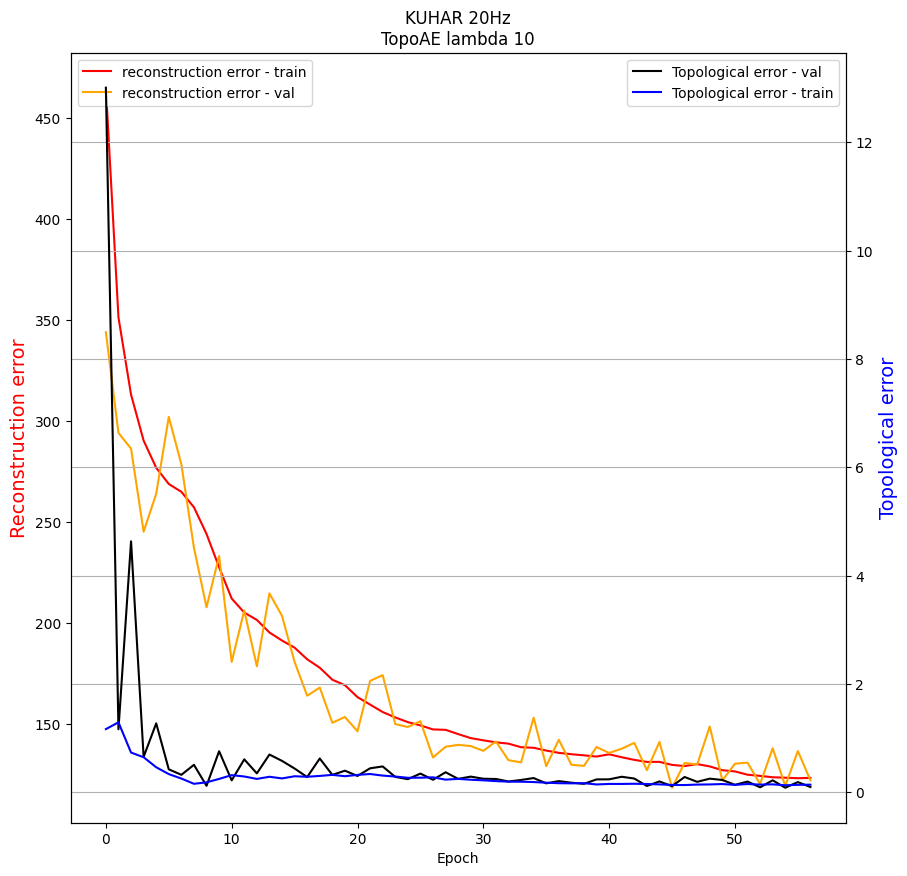

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:377.6074, Loss-ae:306.4454, Loss-topo:7.1162
Epoch:2, P:10, Loss:295.1534, Loss-ae:272.6766, Loss-topo:2.2477
Epoch:3, P:10, Loss:296.8631, Loss-ae:275.5529, Loss-topo:2.1310
Epoch:4, P:9, Loss:257.0017, Loss-ae:243.5641, Loss-topo:1.3438
Epoch:5, P:10, Loss:291.9251, Loss-ae:280.5724, Loss-topo:1.1353
Epoch:6, P:9, Loss:226.1700, Loss-ae:224.5508, Loss-topo:0.1619
Epoch:7, P:10, Loss:264.6280, Loss-ae:260.6449, Loss-topo:0.3983
Epoch:8, P:9, Loss:207.4206, Loss-ae:206.5801, Loss-topo:0.0840
Epoch:9, P:10, Loss:208.8663, Loss-ae:206.7498, Loss-topo:0.2116
Epoch:10, P:9, Loss:190.1909, Loss-ae:187.6691, Loss-topo:0.2522
Epoch:11, P:10, Loss:206.2293, Loss-ae:201.8491, Loss-topo:0.4380
Epoch:12, P:9, Loss:174.8448, Loss-ae:172.8117, Loss-topo:0.2033
Epoch:13, P:10, Loss:225.3515, Loss-ae:220.3551, Loss-topo:0.4996
Epoch:14, P:9, Loss:185.54

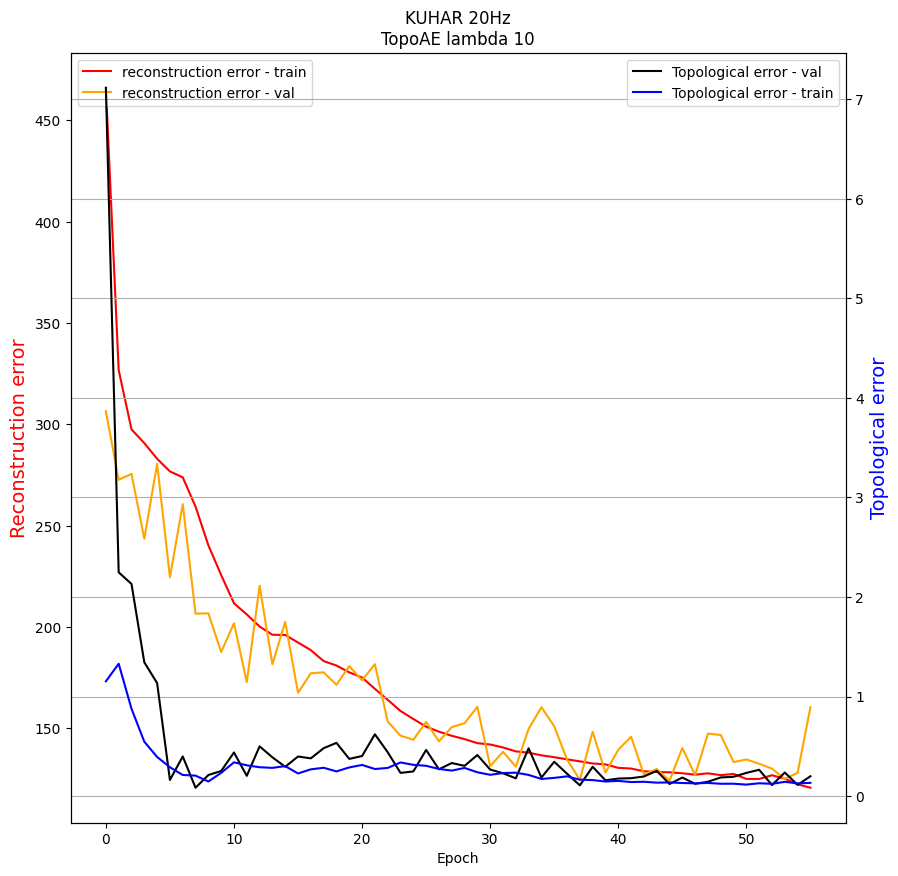

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:465.1007, Loss-ae:421.5956, Loss-topo:4.3505
Epoch:2, P:10, Loss:305.9166, Loss-ae:284.6780, Loss-topo:2.1239
Epoch:3, P:10, Loss:283.1255, Loss-ae:268.8517, Loss-topo:1.4274
Epoch:4, P:10, Loss:265.1393, Loss-ae:257.7612, Loss-topo:0.7378
Epoch:5, P:10, Loss:233.7560, Loss-ae:229.8164, Loss-topo:0.3940
Epoch:6, P:10, Loss:264.9017, Loss-ae:258.3034, Loss-topo:0.6598
Epoch:7, P:9, Loss:234.4268, Loss-ae:227.9933, Loss-topo:0.6433
Epoch:8, P:8, Loss:216.7821, Loss-ae:211.7580, Loss-topo:0.5024
Epoch:9, P:10, Loss:233.7727, Loss-ae:227.3689, Loss-topo:0.6404
Epoch:10, P:9, Loss:207.4732, Loss-ae:202.6505, Loss-topo:0.4823
Epoch:11, P:10, Loss:191.6901, Loss-ae:187.2701, Loss-topo:0.4420
Epoch:12, P:10, Loss:205.0087, Loss-ae:198.8169, Loss-topo:0.6192
Epoch:13, P:9, Loss:176.6865, Loss-ae:173.7870, Loss-topo:0.2900
Epoch:14, P:10, Loss:166.

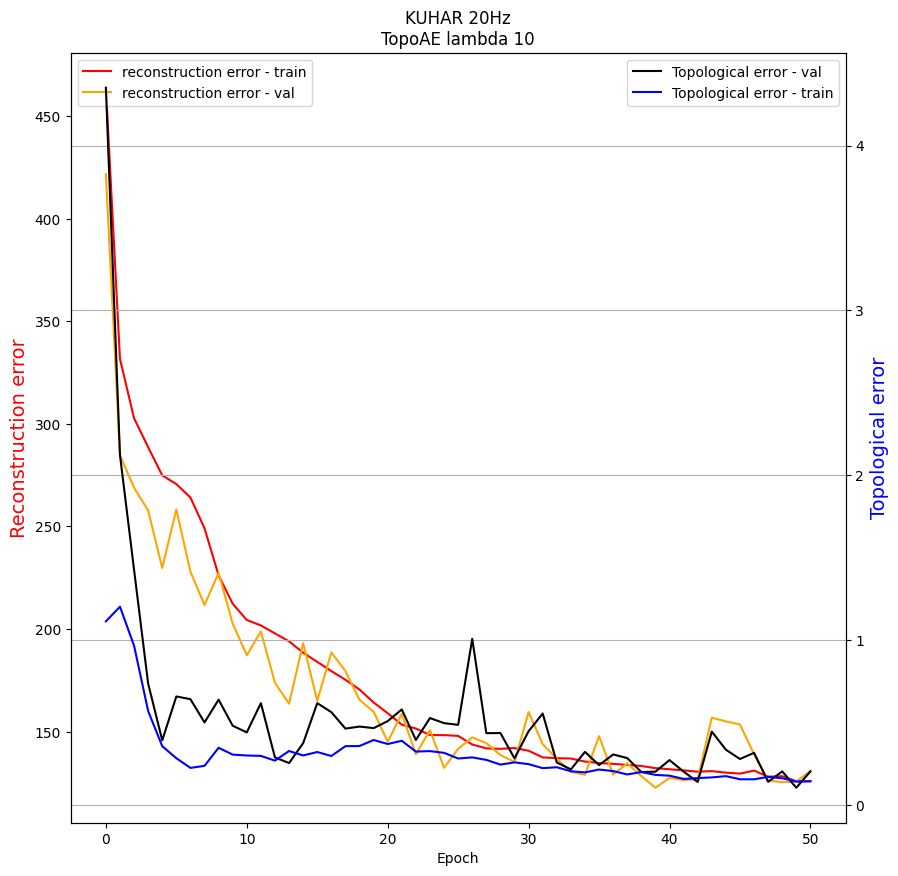

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:505.2112, Loss-ae:465.7687, Loss-topo:3.9442
Epoch:2, P:10, Loss:342.2975, Loss-ae:330.2668, Loss-topo:1.2031
Epoch:3, P:10, Loss:312.8124, Loss-ae:306.3995, Loss-topo:0.6413
Epoch:4, P:10, Loss:281.1049, Loss-ae:277.1769, Loss-topo:0.3928
Epoch:5, P:10, Loss:235.7165, Loss-ae:233.4435, Loss-topo:0.2273
Epoch:6, P:10, Loss:255.1400, Loss-ae:253.1376, Loss-topo:0.2002
Epoch:7, P:9, Loss:289.8513, Loss-ae:286.6247, Loss-topo:0.3227
Epoch:8, P:8, Loss:238.1067, Loss-ae:236.8281, Loss-topo:0.1279
Epoch:9, P:7, Loss:222.5733, Loss-ae:220.1387, Loss-topo:0.2435
Epoch:10, P:10, Loss:199.0084, Loss-ae:194.1180, Loss-topo:0.4890
Epoch:11, P:10, Loss:223.3080, Loss-ae:215.4357, Loss-topo:0.7872
Epoch:12, P:9, Loss:174.9574, Loss-ae:172.8439, Loss-topo:0.2113
Epoch:13, P:10, Loss:187.2449, Loss-ae:183.3914, Loss-topo:0.3854
Epoch:14, P:9, Loss:251.2

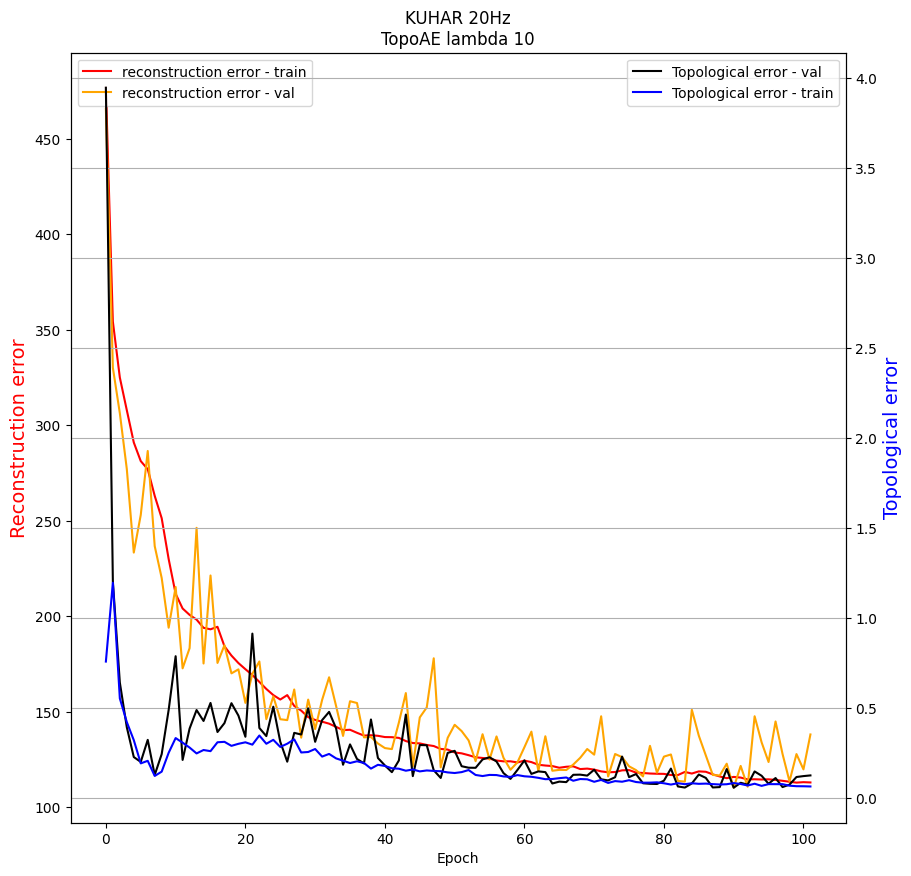

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:375.9287, Loss-ae:335.2192, Loss-topo:4.0709
Epoch:2, P:10, Loss:343.1334, Loss-ae:318.3402, Loss-topo:2.4793
Epoch:3, P:10, Loss:308.3976, Loss-ae:292.3533, Loss-topo:1.6044
Epoch:4, P:10, Loss:311.6357, Loss-ae:289.9186, Loss-topo:2.1717
Epoch:5, P:9, Loss:283.5576, Loss-ae:272.7414, Loss-topo:1.0816
Epoch:6, P:10, Loss:292.9238, Loss-ae:289.0898, Loss-topo:0.3834
Epoch:7, P:9, Loss:285.3486, Loss-ae:276.3698, Loss-topo:0.8979
Epoch:8, P:8, Loss:233.0359, Loss-ae:230.0485, Loss-topo:0.2987
Epoch:9, P:10, Loss:219.9326, Loss-ae:216.3823, Loss-topo:0.3550
Epoch:10, P:10, Loss:228.1308, Loss-ae:223.3909, Loss-topo:0.4740
Epoch:11, P:9, Loss:204.2478, Loss-ae:201.5427, Loss-topo:0.2705
Epoch:12, P:10, Loss:195.5939, Loss-ae:190.4566, Loss-topo:0.5137
Epoch:13, P:10, Loss:184.6786, Loss-ae:180.8540, Loss-topo:0.3825
Epoch:14, P:10, Loss:193.

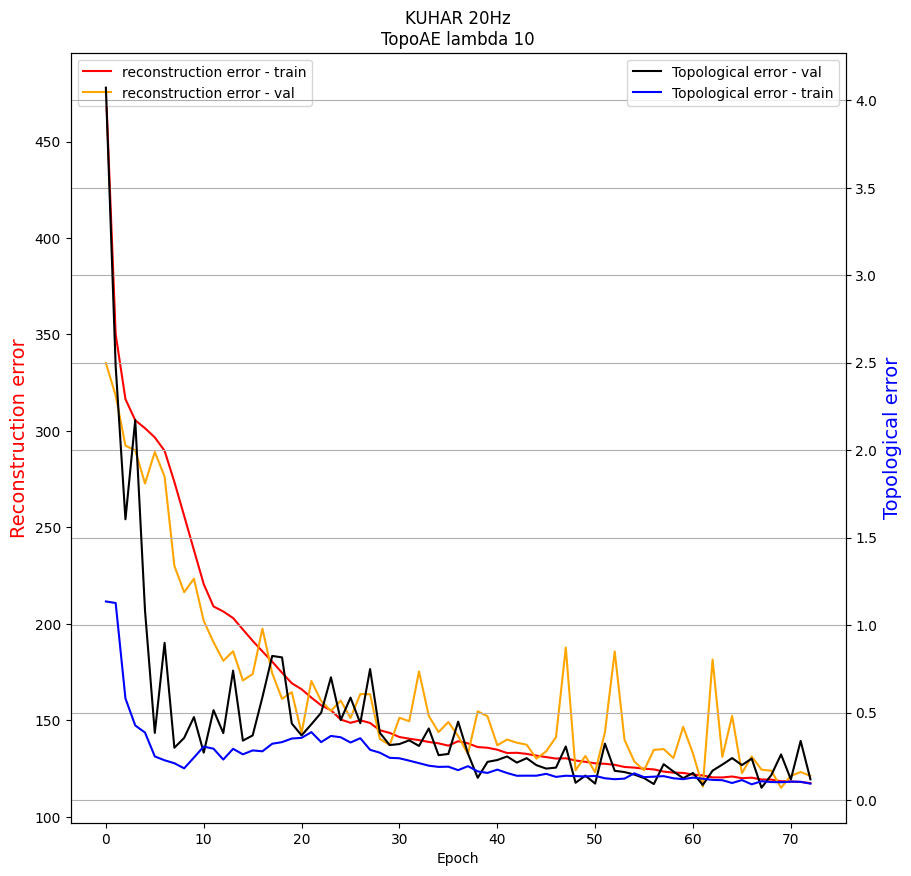

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:472.9684, Loss-ae:413.6425, Loss-topo:0.5933
Epoch:2, P:10, Loss:375.3641, Loss-ae:324.5027, Loss-topo:0.5086
Epoch:3, P:10, Loss:343.8119, Loss-ae:264.7642, Loss-topo:0.7905
Epoch:4, P:10, Loss:250.5396, Loss-ae:246.0325, Loss-topo:0.0451
Epoch:5, P:10, Loss:246.8391, Loss-ae:244.5767, Loss-topo:0.0226
Epoch:6, P:10, Loss:291.5643, Loss-ae:276.5301, Loss-topo:0.1503
Epoch:7, P:9, Loss:251.2109, Loss-ae:248.9207, Loss-topo:0.0229
Epoch:8, P:8, Loss:263.8779, Loss-ae:260.3901, Loss-topo:0.0349
Epoch:9, P:7, Loss:278.6919, Loss-ae:269.3770, Loss-topo:0.0931
Epoch:10, P:6, Loss:248.4101, Loss-ae:247.3768, Loss-topo:0.0103
Epoch:11, P:5, Loss:256.6159, Loss-ae:252.1846, Loss-topo:0.0443
Epoch:12, P:4, Loss:239.2867, Loss-ae:235.2552, Loss-topo:0.0403
Epoch:13, P:10, Loss:243.0196, Loss-ae:234.7734, Loss-topo:0.0825
Epoch:14, P:9, Loss:207.206

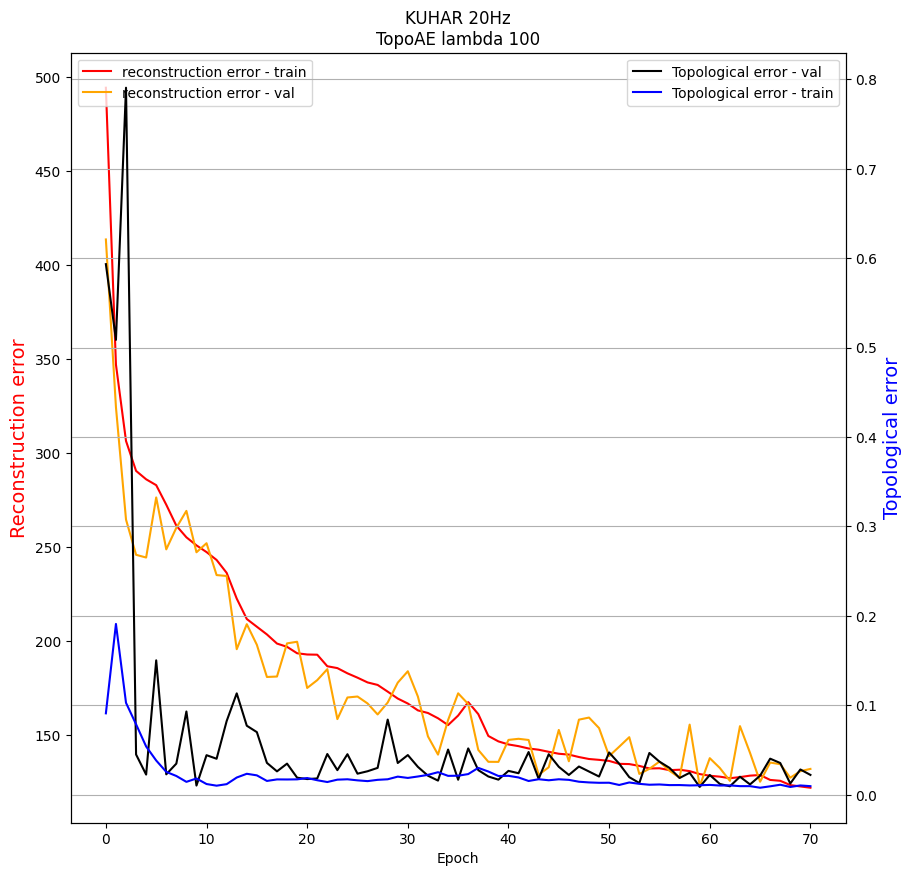

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:384.8992, Loss-ae:352.9194, Loss-topo:0.3198
Epoch:2, P:10, Loss:336.3244, Loss-ae:300.2295, Loss-topo:0.3609
Epoch:3, P:10, Loss:350.9695, Loss-ae:316.3691, Loss-topo:0.3460
Epoch:4, P:9, Loss:310.7639, Loss-ae:301.7440, Loss-topo:0.0902
Epoch:5, P:10, Loss:322.6676, Loss-ae:300.1806, Loss-topo:0.2249
Epoch:6, P:9, Loss:318.3326, Loss-ae:299.6903, Loss-topo:0.1864
Epoch:7, P:8, Loss:246.9342, Loss-ae:245.3812, Loss-topo:0.0155
Epoch:8, P:10, Loss:227.3803, Loss-ae:225.4599, Loss-topo:0.0192
Epoch:9, P:10, Loss:227.3036, Loss-ae:226.3497, Loss-topo:0.0095
Epoch:10, P:10, Loss:209.4255, Loss-ae:208.6110, Loss-topo:0.0081
Epoch:11, P:10, Loss:238.9743, Loss-ae:228.7956, Loss-topo:0.1018
Epoch:12, P:9, Loss:210.2220, Loss-ae:207.0450, Loss-topo:0.0318
Epoch:13, P:8, Loss:198.3072, Loss-ae:192.9281, Loss-topo:0.0538
Epoch:14, P:10, Loss:210.4

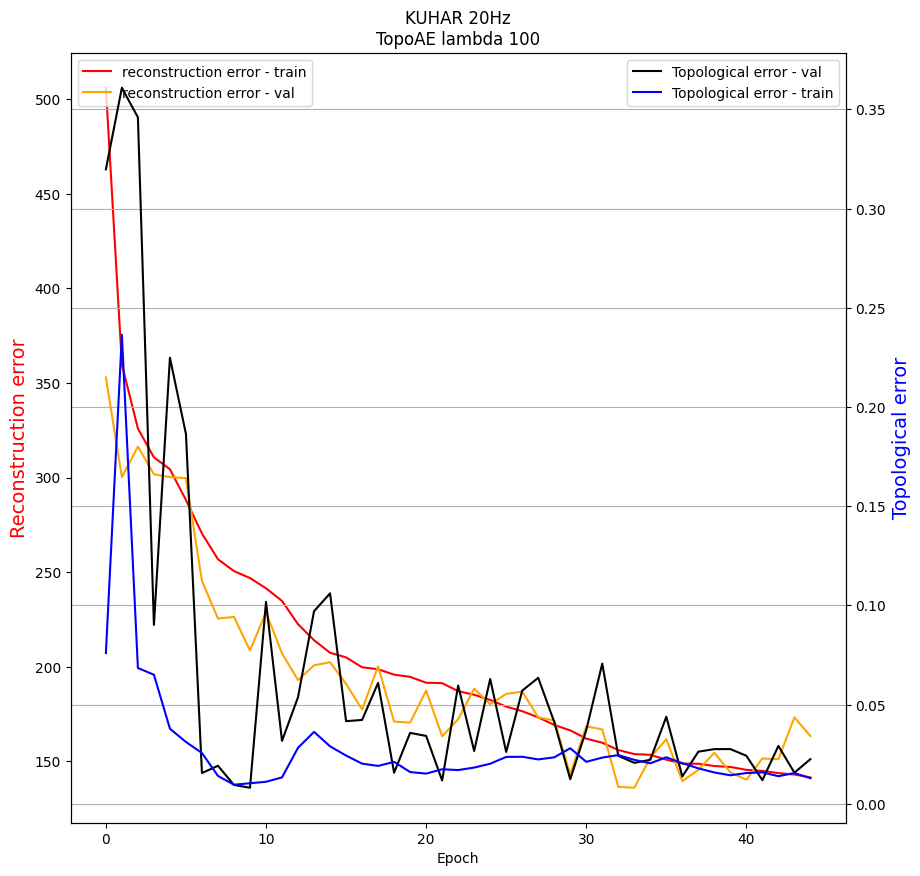

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:468.1161, Loss-ae:424.3542, Loss-topo:0.4376
Epoch:2, P:10, Loss:356.3556, Loss-ae:316.8358, Loss-topo:0.3952
Epoch:3, P:10, Loss:295.9650, Loss-ae:281.4547, Loss-topo:0.1451
Epoch:4, P:10, Loss:328.7732, Loss-ae:303.6618, Loss-topo:0.2511
Epoch:5, P:9, Loss:255.1057, Loss-ae:251.6480, Loss-topo:0.0346
Epoch:6, P:10, Loss:257.2144, Loss-ae:255.3163, Loss-topo:0.0190
Epoch:7, P:9, Loss:273.4556, Loss-ae:260.8211, Loss-topo:0.1263
Epoch:8, P:8, Loss:238.6891, Loss-ae:233.2954, Loss-topo:0.0539
Epoch:9, P:10, Loss:202.0885, Loss-ae:199.9066, Loss-topo:0.0218
Epoch:10, P:10, Loss:230.7796, Loss-ae:225.0873, Loss-topo:0.0569
Epoch:11, P:9, Loss:228.9251, Loss-ae:223.3079, Loss-topo:0.0562
Epoch:12, P:8, Loss:214.7932, Loss-ae:201.4378, Loss-topo:0.1336
Epoch:13, P:7, Loss:193.3840, Loss-ae:191.4076, Loss-topo:0.0198
Epoch:14, P:10, Loss:185.27

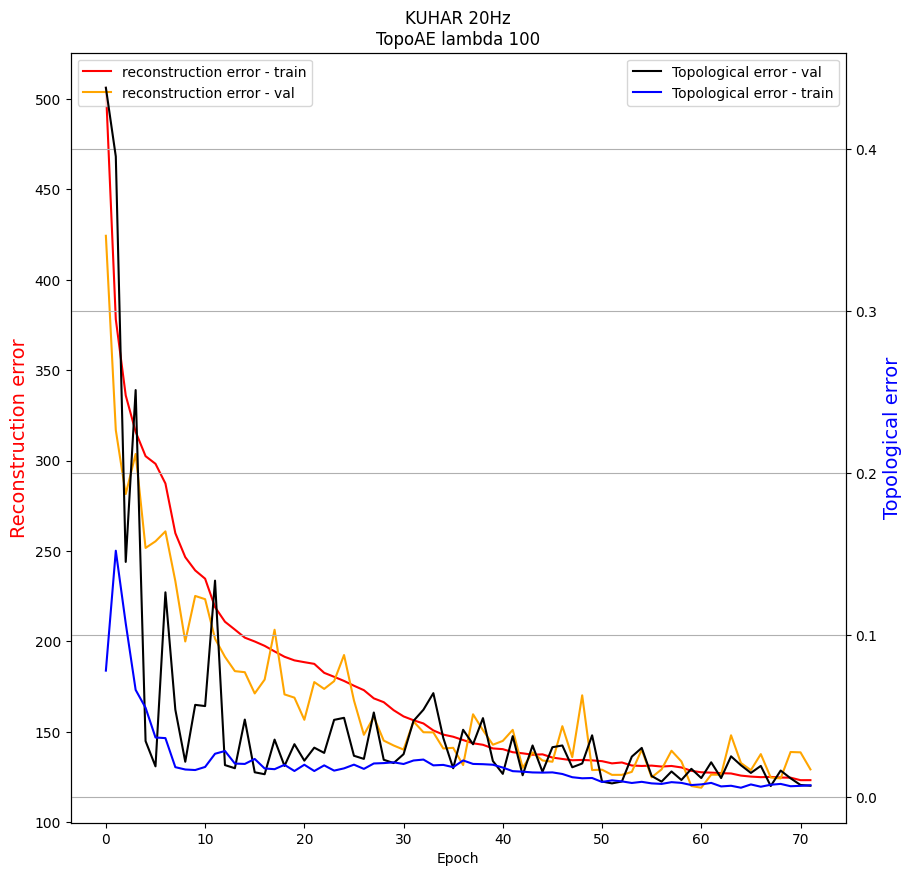

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:437.1787, Loss-ae:361.6322, Loss-topo:0.7555
Epoch:2, P:10, Loss:337.5119, Loss-ae:313.7116, Loss-topo:0.2380
Epoch:3, P:10, Loss:319.4893, Loss-ae:302.6952, Loss-topo:0.1679
Epoch:4, P:10, Loss:313.2817, Loss-ae:285.7753, Loss-topo:0.2751
Epoch:5, P:10, Loss:234.3137, Loss-ae:232.3713, Loss-topo:0.0194
Epoch:6, P:10, Loss:294.4748, Loss-ae:291.1546, Loss-topo:0.0332
Epoch:7, P:9, Loss:253.4861, Loss-ae:252.1632, Loss-topo:0.0132
Epoch:8, P:8, Loss:255.3417, Loss-ae:242.4763, Loss-topo:0.1287
Epoch:9, P:7, Loss:199.7611, Loss-ae:197.5671, Loss-topo:0.0219
Epoch:10, P:10, Loss:203.5088, Loss-ae:202.3419, Loss-topo:0.0117
Epoch:11, P:9, Loss:197.3945, Loss-ae:195.7528, Loss-topo:0.0164
Epoch:12, P:10, Loss:198.4669, Loss-ae:195.2807, Loss-topo:0.0319
Epoch:13, P:9, Loss:229.8420, Loss-ae:226.7360, Loss-topo:0.0311
Epoch:14, P:8, Loss:190.81

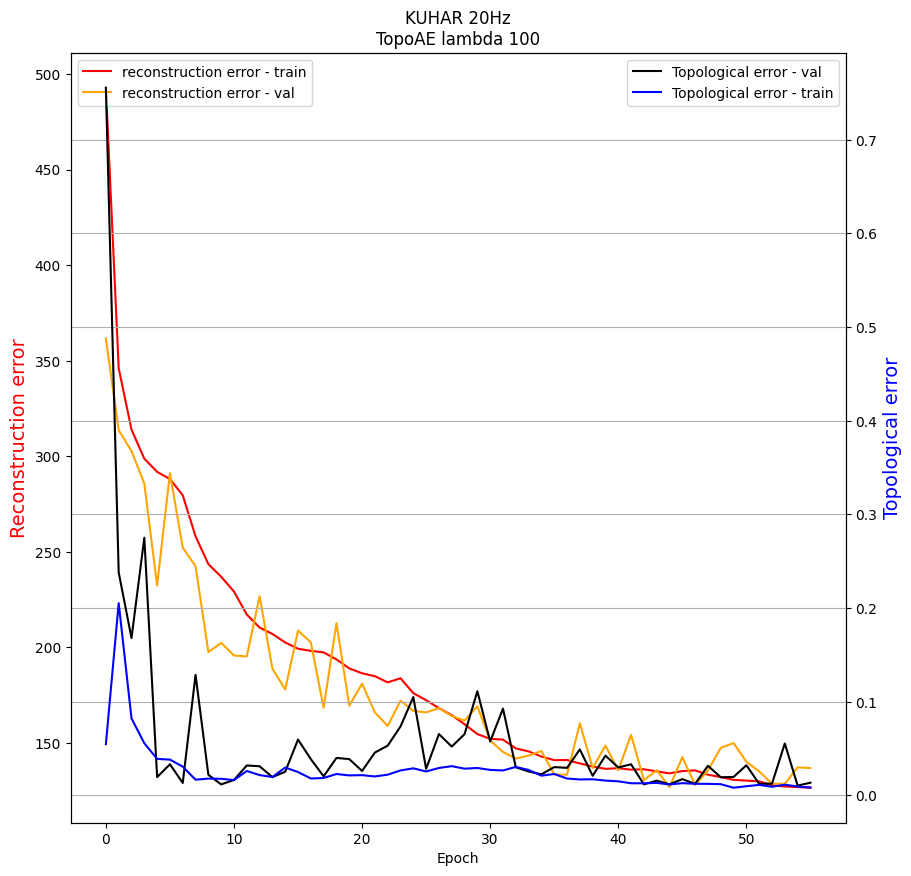

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:394.9860, Loss-ae:362.2450, Loss-topo:0.3274
Epoch:2, P:10, Loss:352.9834, Loss-ae:326.0081, Loss-topo:0.2698
Epoch:3, P:10, Loss:340.0028, Loss-ae:313.7917, Loss-topo:0.2621
Epoch:4, P:10, Loss:325.3306, Loss-ae:316.9804, Loss-topo:0.0835
Epoch:5, P:10, Loss:277.9571, Loss-ae:272.5147, Loss-topo:0.0544
Epoch:6, P:10, Loss:267.3812, Loss-ae:263.2934, Loss-topo:0.0409
Epoch:7, P:10, Loss:264.8827, Loss-ae:245.7861, Loss-topo:0.1910
Epoch:8, P:10, Loss:225.6196, Loss-ae:223.3639, Loss-topo:0.0226
Epoch:9, P:10, Loss:212.4740, Loss-ae:210.9802, Loss-topo:0.0149
Epoch:10, P:10, Loss:257.8277, Loss-ae:252.2837, Loss-topo:0.0554
Epoch:11, P:9, Loss:204.9801, Loss-ae:203.6223, Loss-topo:0.0136
Epoch:12, P:10, Loss:207.6896, Loss-ae:206.1770, Loss-topo:0.0151
Epoch:13, P:9, Loss:211.9620, Loss-ae:208.7673, Loss-topo:0.0319
Epoch:14, P:8, Loss:214

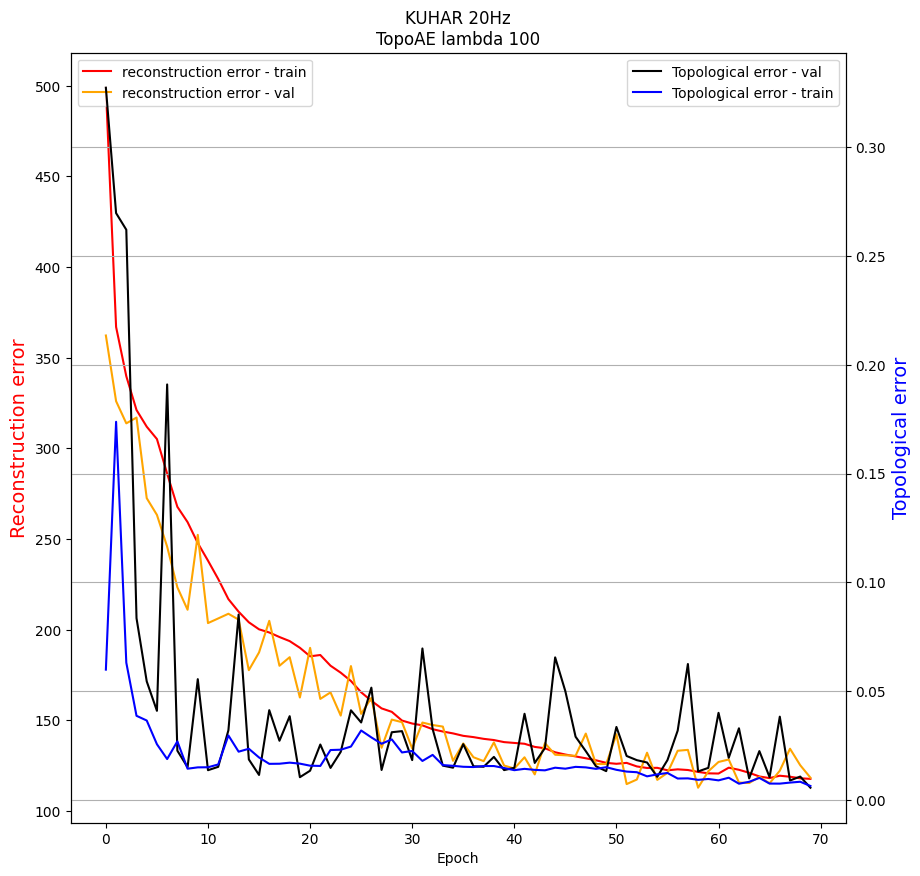

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:405.2369, Loss-ae:389.8104, Loss-topo:0.1543
Epoch:2, P:10, Loss:316.5273, Loss-ae:291.2710, Loss-topo:0.2526
Epoch:3, P:10, Loss:287.4603, Loss-ae:269.0334, Loss-topo:0.1843
Epoch:4, P:10, Loss:290.5738, Loss-ae:274.3912, Loss-topo:0.1618
Epoch:5, P:9, Loss:273.6069, Loss-ae:265.4605, Loss-topo:0.0815
Epoch:6, P:10, Loss:269.6170, Loss-ae:265.8535, Loss-topo:0.0376
Epoch:7, P:10, Loss:269.3509, Loss-ae:251.0858, Loss-topo:0.1827
Epoch:8, P:10, Loss:240.4833, Loss-ae:239.3229, Loss-topo:0.0116
Epoch:9, P:10, Loss:228.8228, Loss-ae:226.1726, Loss-topo:0.0265
Epoch:10, P:10, Loss:219.3925, Loss-ae:217.4448, Loss-topo:0.0195
Epoch:11, P:10, Loss:220.3319, Loss-ae:219.4346, Loss-topo:0.0090
Epoch:12, P:9, Loss:217.7119, Loss-ae:216.2113, Loss-topo:0.0150
Epoch:13, P:10, Loss:205.3870, Loss-ae:204.7158, Loss-topo:0.0067
Epoch:14, P:10, Loss:18

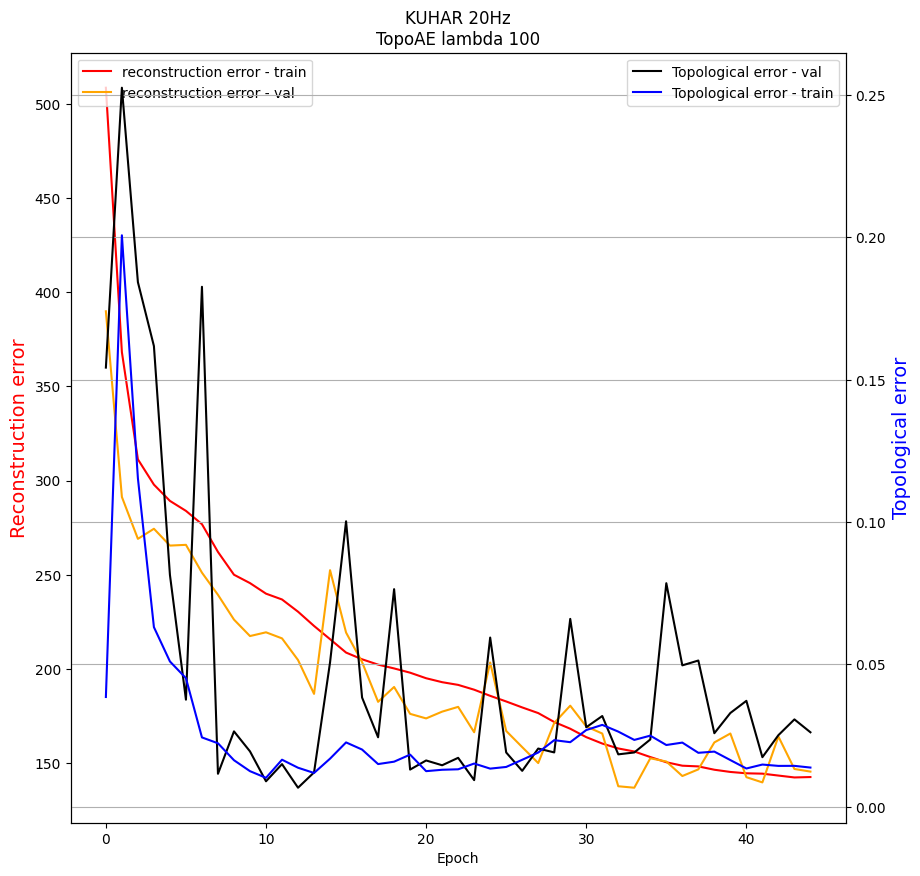

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:380.9131, Loss-ae:357.6399, Loss-topo:0.2327
Epoch:2, P:10, Loss:395.7971, Loss-ae:338.9267, Loss-topo:0.5687
Epoch:3, P:9, Loss:336.2260, Loss-ae:286.9841, Loss-topo:0.4924
Epoch:4, P:10, Loss:242.0124, Loss-ae:227.1821, Loss-topo:0.1483
Epoch:5, P:10, Loss:259.5755, Loss-ae:248.2164, Loss-topo:0.1136
Epoch:6, P:9, Loss:239.1466, Loss-ae:231.8101, Loss-topo:0.0734
Epoch:7, P:10, Loss:254.1128, Loss-ae:250.6958, Loss-topo:0.0342
Epoch:8, P:9, Loss:237.3368, Loss-ae:236.0738, Loss-topo:0.0126
Epoch:9, P:10, Loss:216.2458, Loss-ae:214.4029, Loss-topo:0.0184
Epoch:10, P:10, Loss:259.3344, Loss-ae:250.7605, Loss-topo:0.0857
Epoch:11, P:9, Loss:214.5109, Loss-ae:212.9044, Loss-topo:0.0161
Epoch:12, P:10, Loss:199.2403, Loss-ae:196.4858, Loss-topo:0.0275
Epoch:13, P:10, Loss:190.4875, Loss-ae:188.4101, Loss-topo:0.0208
Epoch:14, P:10, Loss:219.

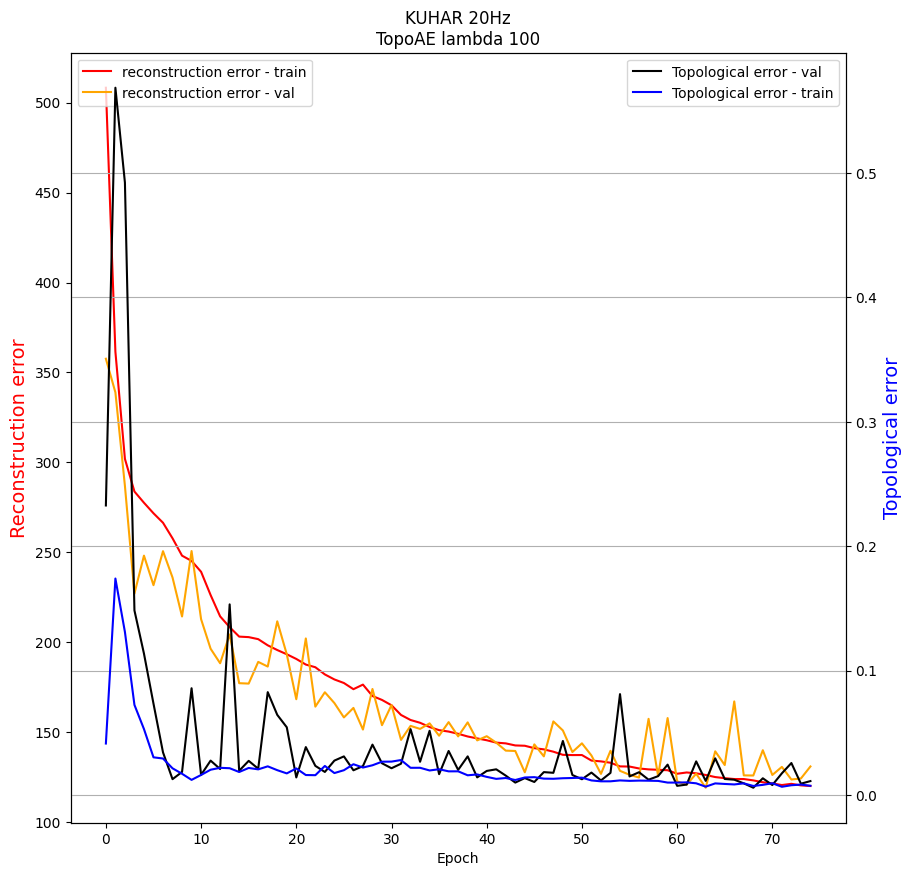

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:473.8326, Loss-ae:443.1417, Loss-topo:0.3069
Epoch:2, P:10, Loss:340.0683, Loss-ae:294.2785, Loss-topo:0.4579
Epoch:3, P:10, Loss:276.4752, Loss-ae:259.3584, Loss-topo:0.1712
Epoch:4, P:10, Loss:271.2019, Loss-ae:261.5543, Loss-topo:0.0965
Epoch:5, P:10, Loss:264.0405, Loss-ae:260.8127, Loss-topo:0.0323
Epoch:6, P:10, Loss:243.7504, Loss-ae:239.2100, Loss-topo:0.0454
Epoch:7, P:10, Loss:280.1386, Loss-ae:271.1658, Loss-topo:0.0897
Epoch:8, P:9, Loss:233.7673, Loss-ae:229.2132, Loss-topo:0.0455
Epoch:9, P:10, Loss:217.9017, Loss-ae:216.6250, Loss-topo:0.0128
Epoch:10, P:10, Loss:231.4610, Loss-ae:227.5202, Loss-topo:0.0394
Epoch:11, P:9, Loss:212.2601, Loss-ae:207.4523, Loss-topo:0.0481
Epoch:12, P:10, Loss:193.4737, Loss-ae:190.4337, Loss-topo:0.0304
Epoch:13, P:10, Loss:194.7646, Loss-ae:191.1003, Loss-topo:0.0366
Epoch:14, P:9, Loss:229

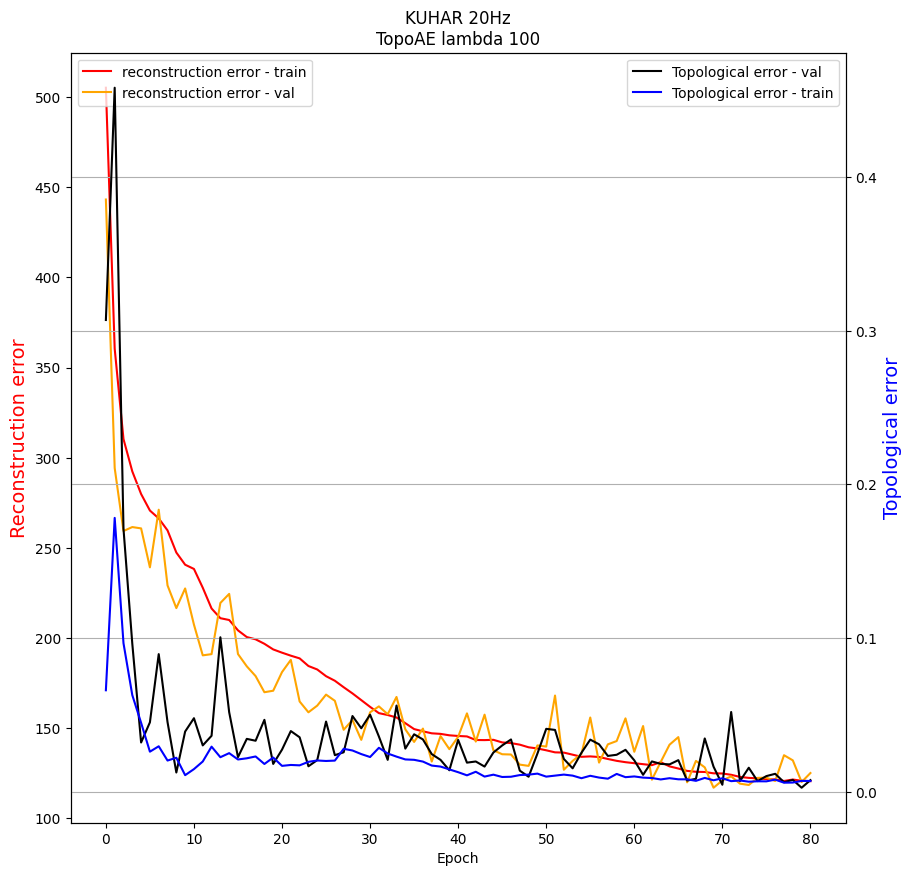

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:453.0559, Loss-ae:390.0532, Loss-topo:0.6300
Epoch:2, P:10, Loss:325.7032, Loss-ae:268.3853, Loss-topo:0.5732
Epoch:3, P:10, Loss:287.7245, Loss-ae:258.1932, Loss-topo:0.2953
Epoch:4, P:10, Loss:249.3876, Loss-ae:239.9861, Loss-topo:0.0940
Epoch:5, P:10, Loss:268.8060, Loss-ae:255.5763, Loss-topo:0.1323
Epoch:6, P:9, Loss:282.2695, Loss-ae:269.7327, Loss-topo:0.1254
Epoch:7, P:8, Loss:293.3202, Loss-ae:286.9262, Loss-topo:0.0639
Epoch:8, P:7, Loss:228.8936, Loss-ae:223.4568, Loss-topo:0.0544
Epoch:9, P:10, Loss:211.4813, Loss-ae:209.8834, Loss-topo:0.0160
Epoch:10, P:10, Loss:225.4449, Loss-ae:223.3788, Loss-topo:0.0207
Epoch:11, P:9, Loss:221.6611, Loss-ae:220.6063, Loss-topo:0.0105
Epoch:12, P:8, Loss:212.6202, Loss-ae:212.0135, Loss-topo:0.0061
Epoch:13, P:7, Loss:220.7501, Loss-ae:219.9754, Loss-topo:0.0077
Epoch:14, P:6, Loss:196.721

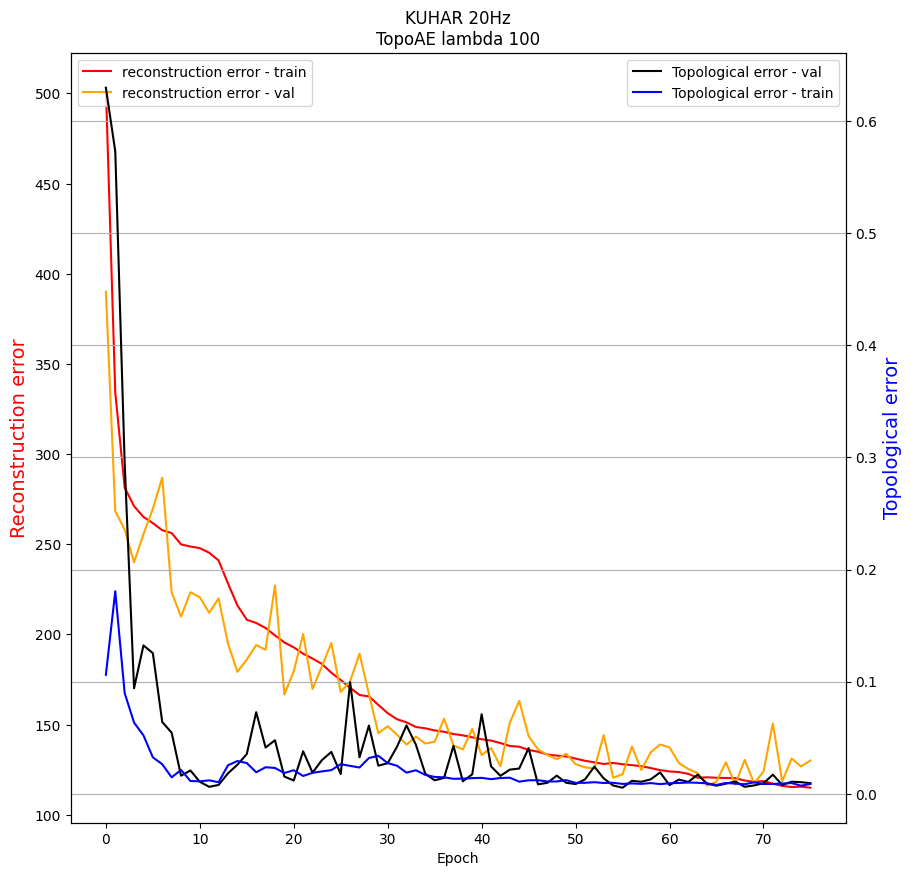

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:442.9555, Loss-ae:415.2479, Loss-topo:0.2771
Epoch:2, P:10, Loss:319.5709, Loss-ae:287.7464, Loss-topo:0.3182
Epoch:3, P:10, Loss:272.5502, Loss-ae:250.8836, Loss-topo:0.2167
Epoch:4, P:10, Loss:310.5601, Loss-ae:299.1721, Loss-topo:0.1139
Epoch:5, P:9, Loss:271.4162, Loss-ae:256.6781, Loss-topo:0.1474
Epoch:6, P:10, Loss:267.4832, Loss-ae:257.8924, Loss-topo:0.0959
Epoch:7, P:10, Loss:300.7741, Loss-ae:296.2263, Loss-topo:0.0455
Epoch:8, P:9, Loss:245.2049, Loss-ae:243.8840, Loss-topo:0.0132
Epoch:9, P:10, Loss:214.0550, Loss-ae:212.6310, Loss-topo:0.0142
Epoch:10, P:10, Loss:257.0400, Loss-ae:254.1023, Loss-topo:0.0294
Epoch:11, P:9, Loss:248.3290, Loss-ae:244.2305, Loss-topo:0.0410
Epoch:12, P:8, Loss:257.0160, Loss-ae:254.6267, Loss-topo:0.0239
Epoch:13, P:7, Loss:224.0396, Loss-ae:218.6698, Loss-topo:0.0537
Epoch:14, P:6, Loss:248.35

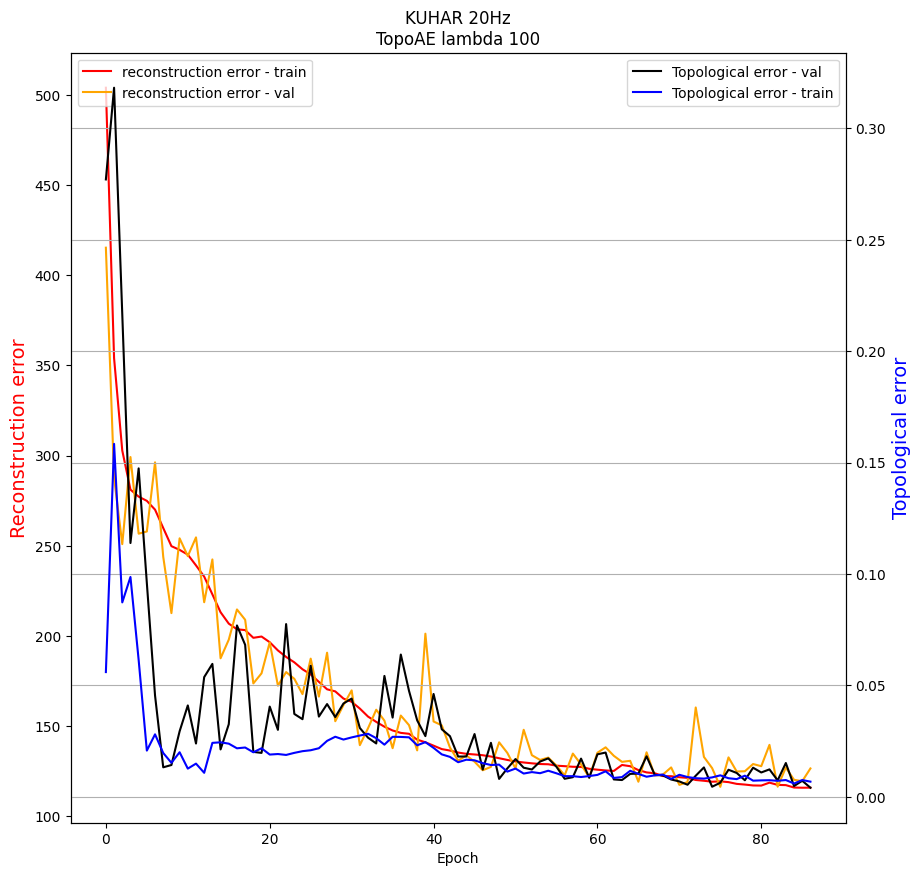

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:564.6901, Loss-ae:446.5713, Loss-topo:0.1181
Epoch:2, P:10, Loss:305.3665, Loss-ae:290.4179, Loss-topo:0.0149
Epoch:3, P:10, Loss:351.9292, Loss-ae:289.7736, Loss-topo:0.0622
Epoch:4, P:9, Loss:355.2986, Loss-ae:284.6504, Loss-topo:0.0706
Epoch:5, P:8, Loss:238.1079, Loss-ae:232.7310, Loss-topo:0.0054
Epoch:6, P:10, Loss:272.9298, Loss-ae:265.6834, Loss-topo:0.0072
Epoch:7, P:9, Loss:245.3251, Loss-ae:240.1884, Loss-topo:0.0051
Epoch:8, P:8, Loss:226.0543, Loss-ae:223.8561, Loss-topo:0.0022
Epoch:9, P:10, Loss:234.0984, Loss-ae:222.4426, Loss-topo:0.0117
Epoch:10, P:9, Loss:258.8417, Loss-ae:239.8169, Loss-topo:0.0190
Epoch:11, P:8, Loss:274.3788, Loss-ae:268.2101, Loss-topo:0.0062
Epoch:12, P:7, Loss:240.2584, Loss-ae:236.5677, Loss-topo:0.0037
Epoch:13, P:6, Loss:224.2157, Loss-ae:222.5183, Loss-topo:0.0017
Epoch:14, P:10, Loss:275.9562

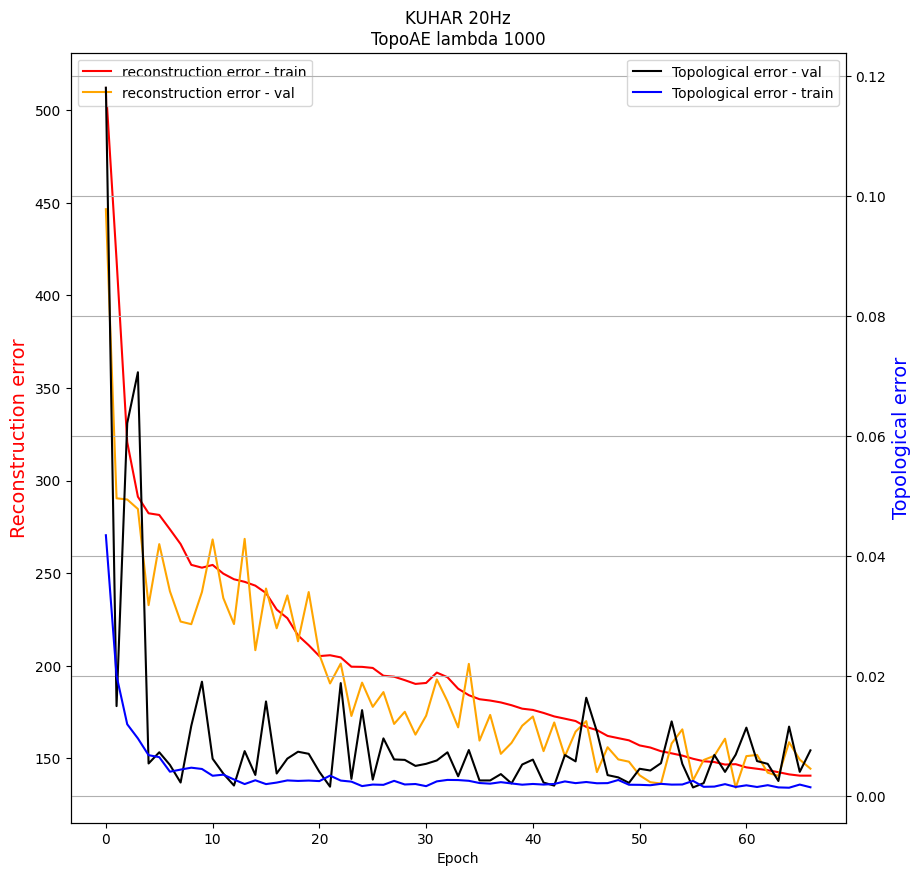

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:442.8868, Loss-ae:433.7232, Loss-topo:0.0092
Epoch:2, P:10, Loss:471.9255, Loss-ae:370.2707, Loss-topo:0.1017
Epoch:3, P:9, Loss:287.3555, Loss-ae:274.0746, Loss-topo:0.0133
Epoch:4, P:10, Loss:310.8004, Loss-ae:295.9235, Loss-topo:0.0149
Epoch:5, P:9, Loss:259.1778, Loss-ae:249.8716, Loss-topo:0.0093
Epoch:6, P:10, Loss:285.8724, Loss-ae:276.7382, Loss-topo:0.0091
Epoch:7, P:9, Loss:282.3669, Loss-ae:268.8237, Loss-topo:0.0135
Epoch:8, P:8, Loss:247.1158, Loss-ae:244.7988, Loss-topo:0.0023
Epoch:9, P:10, Loss:241.3204, Loss-ae:237.2318, Loss-topo:0.0041
Epoch:10, P:10, Loss:216.9176, Loss-ae:208.1671, Loss-topo:0.0088
Epoch:11, P:10, Loss:213.6619, Loss-ae:211.1019, Loss-topo:0.0026
Epoch:12, P:10, Loss:226.0686, Loss-ae:220.0980, Loss-topo:0.0060
Epoch:13, P:9, Loss:228.4003, Loss-ae:226.3299, Loss-topo:0.0021
Epoch:14, P:8, Loss:218.94

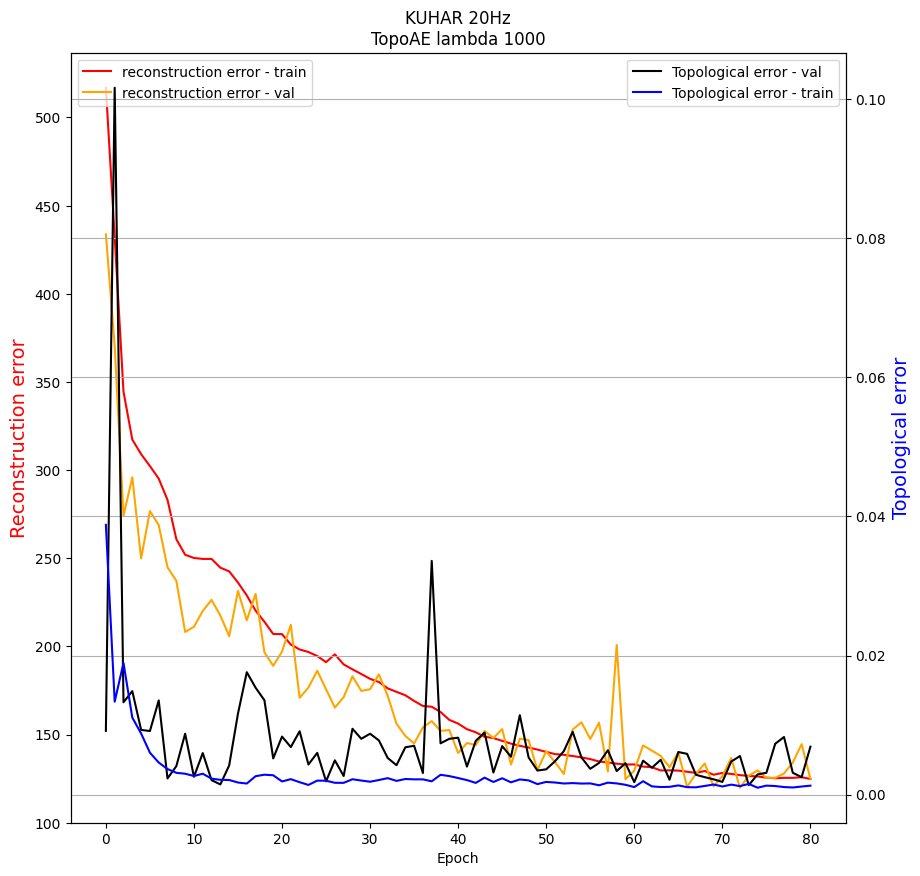

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:420.6664, Loss-ae:412.3950, Loss-topo:0.0083
Epoch:2, P:10, Loss:403.4215, Loss-ae:321.3172, Loss-topo:0.0821
Epoch:3, P:10, Loss:272.5915, Loss-ae:257.9429, Loss-topo:0.0146
Epoch:4, P:10, Loss:300.1076, Loss-ae:254.8472, Loss-topo:0.0453
Epoch:5, P:9, Loss:305.3965, Loss-ae:251.8874, Loss-topo:0.0535
Epoch:6, P:8, Loss:231.3406, Loss-ae:228.4388, Loss-topo:0.0029
Epoch:7, P:10, Loss:316.3766, Loss-ae:314.1340, Loss-topo:0.0022
Epoch:8, P:9, Loss:233.8266, Loss-ae:230.3835, Loss-topo:0.0034
Epoch:9, P:8, Loss:219.2073, Loss-ae:217.5688, Loss-topo:0.0016
Epoch:10, P:10, Loss:263.1468, Loss-ae:260.1090, Loss-topo:0.0030
Epoch:11, P:9, Loss:260.0417, Loss-ae:253.2077, Loss-topo:0.0068
Epoch:12, P:8, Loss:251.2223, Loss-ae:241.1053, Loss-topo:0.0101
Epoch:13, P:7, Loss:223.0580, Loss-ae:207.4244, Loss-topo:0.0156
Epoch:14, P:6, Loss:192.6674

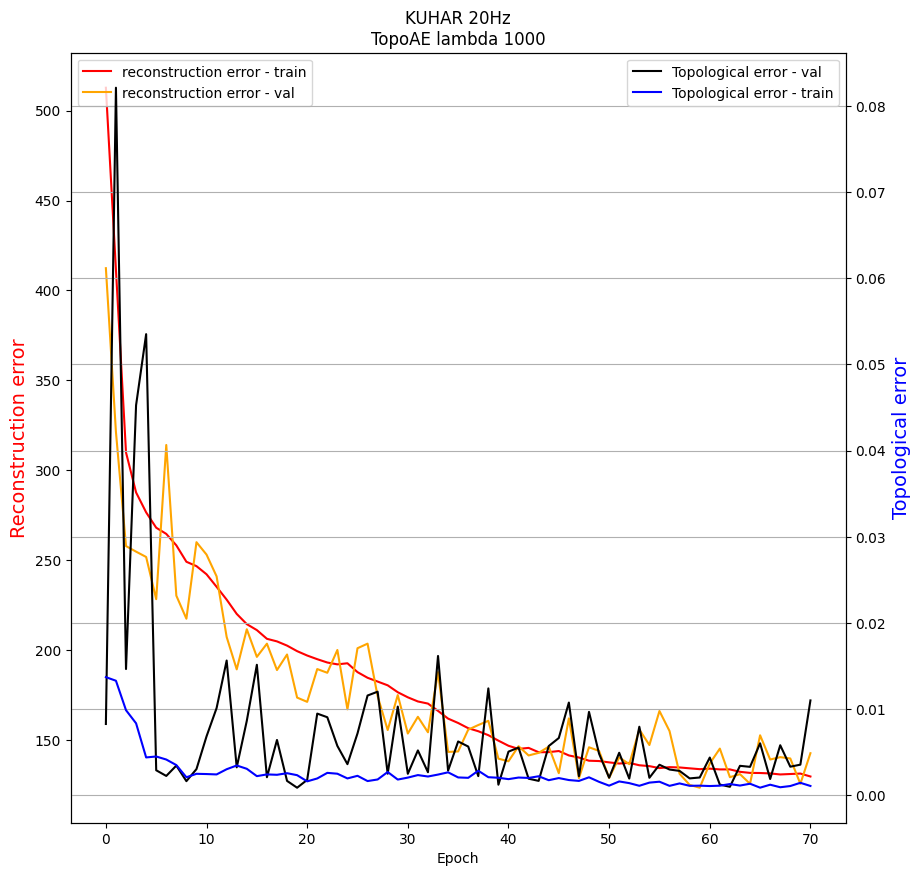

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:582.6548, Loss-ae:489.6499, Loss-topo:0.0930
Epoch:2, P:10, Loss:359.8876, Loss-ae:327.8320, Loss-topo:0.0321
Epoch:3, P:10, Loss:352.2914, Loss-ae:300.7669, Loss-topo:0.0515
Epoch:4, P:10, Loss:365.5977, Loss-ae:262.0055, Loss-topo:0.1036
Epoch:5, P:9, Loss:257.7959, Loss-ae:249.2156, Loss-topo:0.0086
Epoch:6, P:10, Loss:298.8189, Loss-ae:290.0193, Loss-topo:0.0088
Epoch:7, P:9, Loss:316.4562, Loss-ae:261.5973, Loss-topo:0.0549
Epoch:8, P:8, Loss:250.3001, Loss-ae:225.3202, Loss-topo:0.0250
Epoch:9, P:10, Loss:224.4672, Loss-ae:221.0230, Loss-topo:0.0034
Epoch:10, P:10, Loss:225.7554, Loss-ae:220.6956, Loss-topo:0.0051
Epoch:11, P:9, Loss:223.4006, Loss-ae:218.5225, Loss-topo:0.0049
Epoch:12, P:10, Loss:222.4611, Loss-ae:217.7213, Loss-topo:0.0047
Epoch:13, P:10, Loss:227.8163, Loss-ae:224.1337, Loss-topo:0.0037
Epoch:14, P:9, Loss:235.8

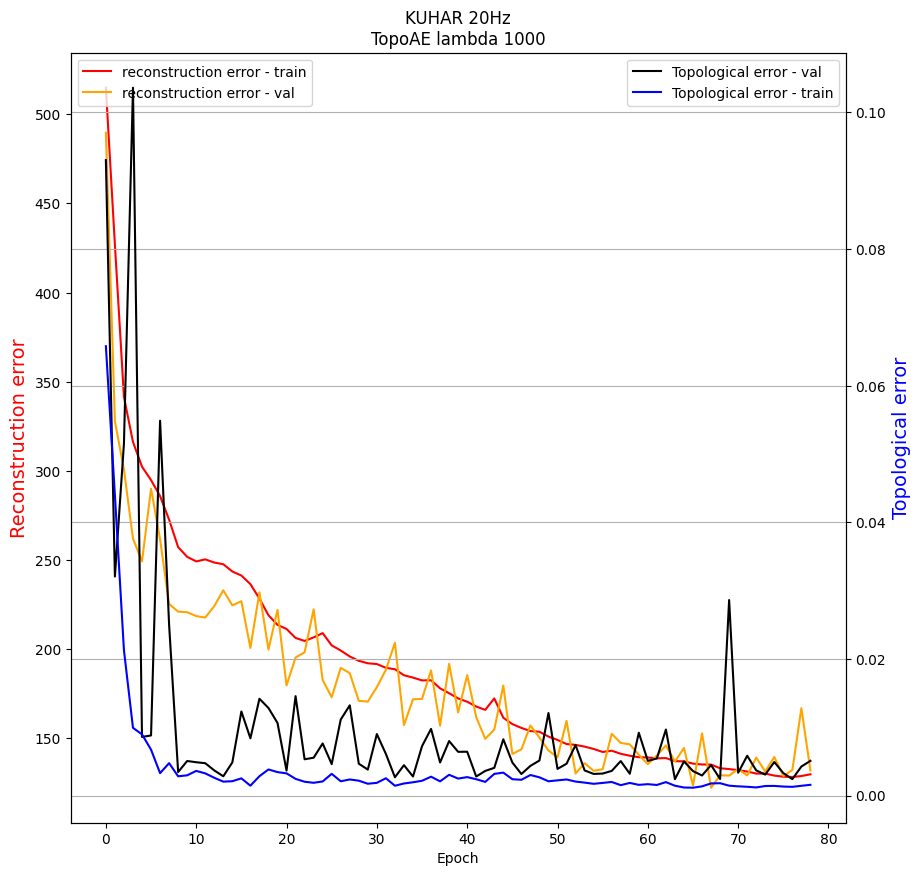

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:505.7170, Loss-ae:434.0226, Loss-topo:0.0717
Epoch:2, P:10, Loss:344.2268, Loss-ae:297.7240, Loss-topo:0.0465
Epoch:3, P:10, Loss:362.7224, Loss-ae:286.2439, Loss-topo:0.0765
Epoch:4, P:9, Loss:259.6405, Loss-ae:244.8417, Loss-topo:0.0148
Epoch:5, P:10, Loss:290.7749, Loss-ae:263.4516, Loss-topo:0.0273
Epoch:6, P:9, Loss:261.7524, Loss-ae:255.2162, Loss-topo:0.0065
Epoch:7, P:8, Loss:280.9528, Loss-ae:255.1424, Loss-topo:0.0258
Epoch:8, P:7, Loss:220.1637, Loss-ae:216.2575, Loss-topo:0.0039
Epoch:9, P:10, Loss:226.0187, Loss-ae:219.6277, Loss-topo:0.0064
Epoch:10, P:9, Loss:233.7335, Loss-ae:229.6681, Loss-topo:0.0041
Epoch:11, P:8, Loss:240.1399, Loss-ae:234.5957, Loss-topo:0.0055
Epoch:12, P:7, Loss:214.5320, Loss-ae:212.6068, Loss-topo:0.0019
Epoch:13, P:10, Loss:233.7030, Loss-ae:229.3170, Loss-topo:0.0044
Epoch:14, P:9, Loss:226.9832

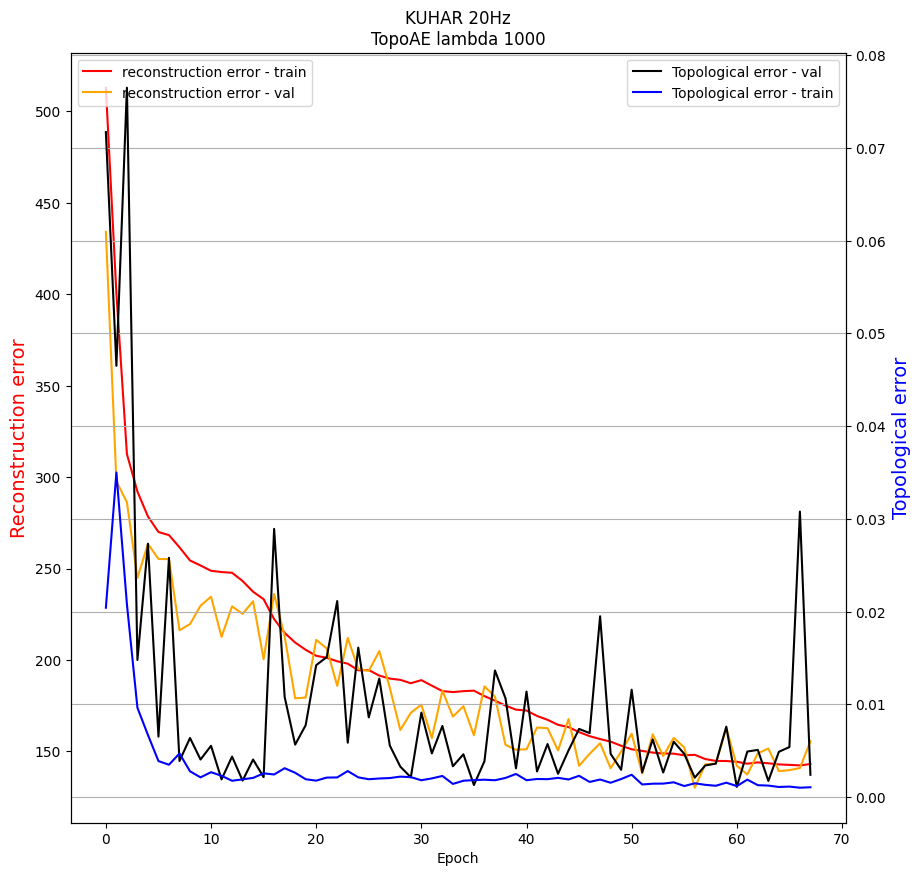

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:460.3799, Loss-ae:452.7928, Loss-topo:0.0076
Epoch:2, P:10, Loss:312.4714, Loss-ae:292.3306, Loss-topo:0.0201
Epoch:3, P:10, Loss:297.8524, Loss-ae:284.9648, Loss-topo:0.0129
Epoch:4, P:10, Loss:271.7440, Loss-ae:252.5792, Loss-topo:0.0192
Epoch:5, P:10, Loss:336.9462, Loss-ae:242.3860, Loss-topo:0.0946
Epoch:6, P:9, Loss:244.4572, Loss-ae:241.5579, Loss-topo:0.0029
Epoch:7, P:10, Loss:246.3648, Loss-ae:240.6726, Loss-topo:0.0057
Epoch:8, P:9, Loss:231.0744, Loss-ae:226.1196, Loss-topo:0.0050
Epoch:9, P:10, Loss:215.4480, Loss-ae:211.6650, Loss-topo:0.0038
Epoch:10, P:10, Loss:294.5377, Loss-ae:263.1604, Loss-topo:0.0314
Epoch:11, P:9, Loss:249.3361, Loss-ae:238.0933, Loss-topo:0.0112
Epoch:12, P:8, Loss:272.0913, Loss-ae:267.3860, Loss-topo:0.0047
Epoch:13, P:7, Loss:224.2594, Loss-ae:221.6953, Loss-topo:0.0026
Epoch:14, P:6, Loss:263.52

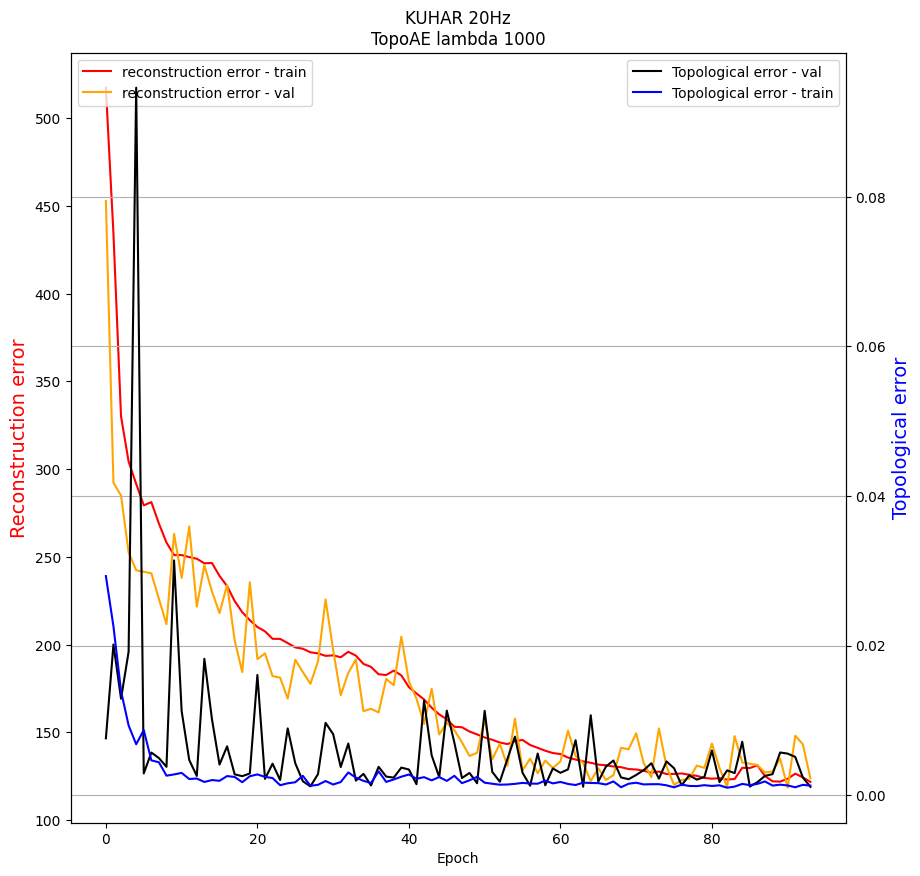

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:542.5555, Loss-ae:458.4981, Loss-topo:0.0841
Epoch:2, P:10, Loss:344.5807, Loss-ae:321.5666, Loss-topo:0.0230
Epoch:3, P:10, Loss:300.7399, Loss-ae:290.7123, Loss-topo:0.0100
Epoch:4, P:10, Loss:296.6496, Loss-ae:287.2252, Loss-topo:0.0094
Epoch:5, P:10, Loss:263.2869, Loss-ae:258.2238, Loss-topo:0.0051
Epoch:6, P:10, Loss:308.9850, Loss-ae:298.1528, Loss-topo:0.0108
Epoch:7, P:9, Loss:237.7412, Loss-ae:230.8097, Loss-topo:0.0069
Epoch:8, P:10, Loss:234.7654, Loss-ae:232.5965, Loss-topo:0.0022
Epoch:9, P:10, Loss:257.1941, Loss-ae:242.0402, Loss-topo:0.0152
Epoch:10, P:9, Loss:216.4654, Loss-ae:212.7981, Loss-topo:0.0037
Epoch:11, P:10, Loss:217.3488, Loss-ae:209.6146, Loss-topo:0.0077
Epoch:12, P:9, Loss:262.0832, Loss-ae:255.3883, Loss-topo:0.0067
Epoch:13, P:8, Loss:257.5825, Loss-ae:254.2393, Loss-topo:0.0033
Epoch:14, P:7, Loss:212.0

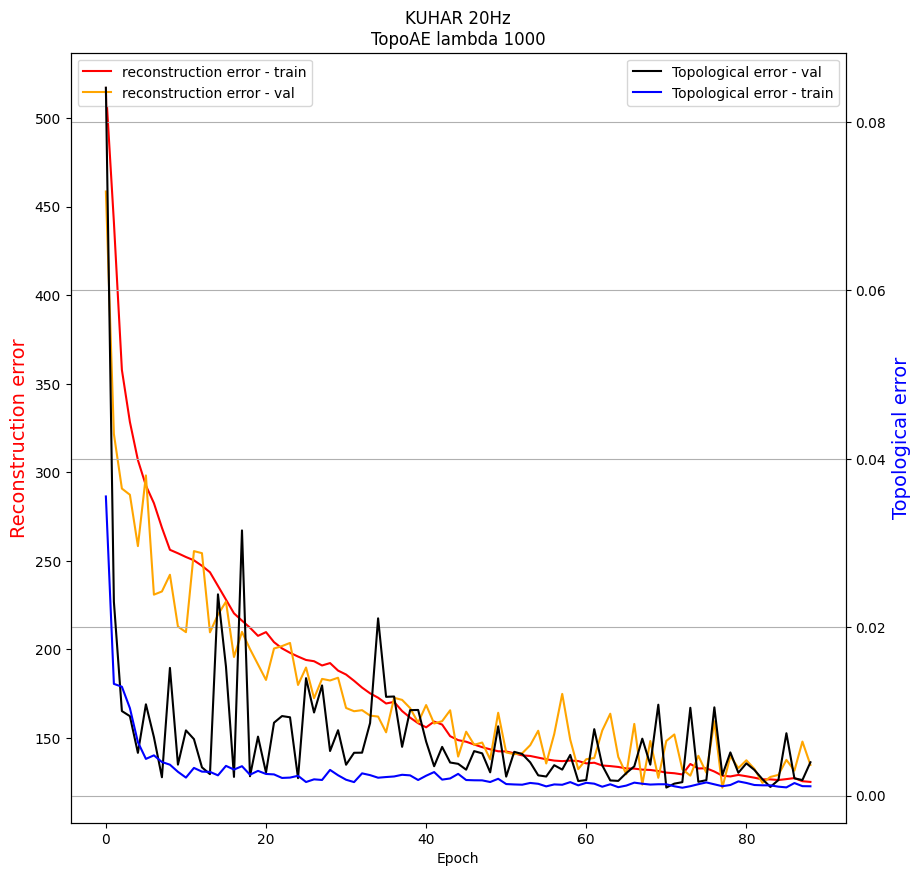

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:426.6419, Loss-ae:418.8982, Loss-topo:0.0077
Epoch:2, P:10, Loss:404.0941, Loss-ae:323.5475, Loss-topo:0.0805
Epoch:3, P:10, Loss:300.6712, Loss-ae:267.6538, Loss-topo:0.0330
Epoch:4, P:10, Loss:285.5956, Loss-ae:278.4048, Loss-topo:0.0072
Epoch:5, P:10, Loss:263.2847, Loss-ae:254.9678, Loss-topo:0.0083
Epoch:6, P:10, Loss:267.0211, Loss-ae:250.4348, Loss-topo:0.0166
Epoch:7, P:9, Loss:259.5654, Loss-ae:249.9195, Loss-topo:0.0096
Epoch:8, P:10, Loss:277.5348, Loss-ae:264.8348, Loss-topo:0.0127
Epoch:9, P:9, Loss:223.4469, Loss-ae:219.1369, Loss-topo:0.0043
Epoch:10, P:10, Loss:236.0918, Loss-ae:233.3201, Loss-topo:0.0028
Epoch:11, P:9, Loss:230.4855, Loss-ae:223.2823, Loss-topo:0.0072
Epoch:12, P:8, Loss:228.0454, Loss-ae:223.8858, Loss-topo:0.0042
Epoch:13, P:7, Loss:236.6710, Loss-ae:227.7529, Loss-topo:0.0089
Epoch:14, P:6, Loss:207.19

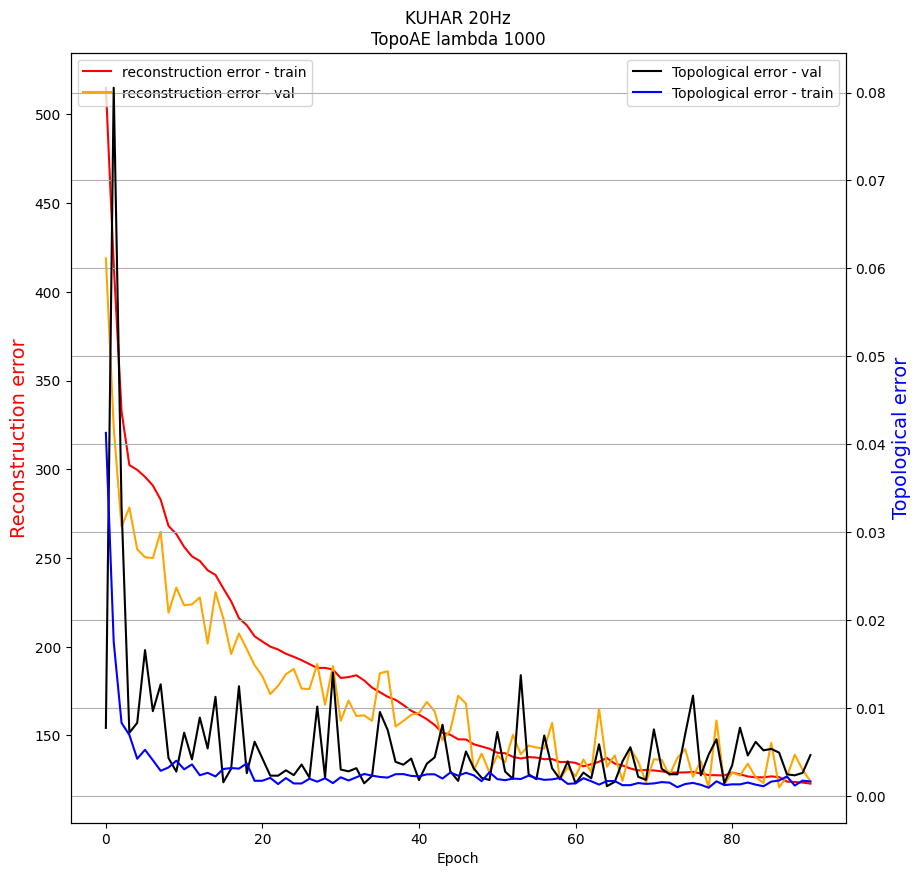

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:430.7212, Loss-ae:408.7385, Loss-topo:0.0220
Epoch:2, P:10, Loss:336.2289, Loss-ae:314.2211, Loss-topo:0.0220
Epoch:3, P:10, Loss:312.8137, Loss-ae:296.3991, Loss-topo:0.0164
Epoch:4, P:10, Loss:373.1341, Loss-ae:277.9117, Loss-topo:0.0952
Epoch:5, P:9, Loss:329.6477, Loss-ae:301.3497, Loss-topo:0.0283
Epoch:6, P:8, Loss:257.3136, Loss-ae:252.5708, Loss-topo:0.0047
Epoch:7, P:10, Loss:247.3656, Loss-ae:244.2910, Loss-topo:0.0031
Epoch:8, P:10, Loss:283.5325, Loss-ae:266.1898, Loss-topo:0.0173
Epoch:9, P:9, Loss:248.2176, Loss-ae:244.9447, Loss-topo:0.0033
Epoch:10, P:8, Loss:258.4309, Loss-ae:254.4797, Loss-topo:0.0040
Epoch:11, P:7, Loss:228.9099, Loss-ae:223.7152, Loss-topo:0.0052
Epoch:12, P:10, Loss:256.4316, Loss-ae:243.6032, Loss-topo:0.0128
Epoch:13, P:9, Loss:217.1664, Loss-ae:208.9168, Loss-topo:0.0082
Epoch:14, P:10, Loss:236.03

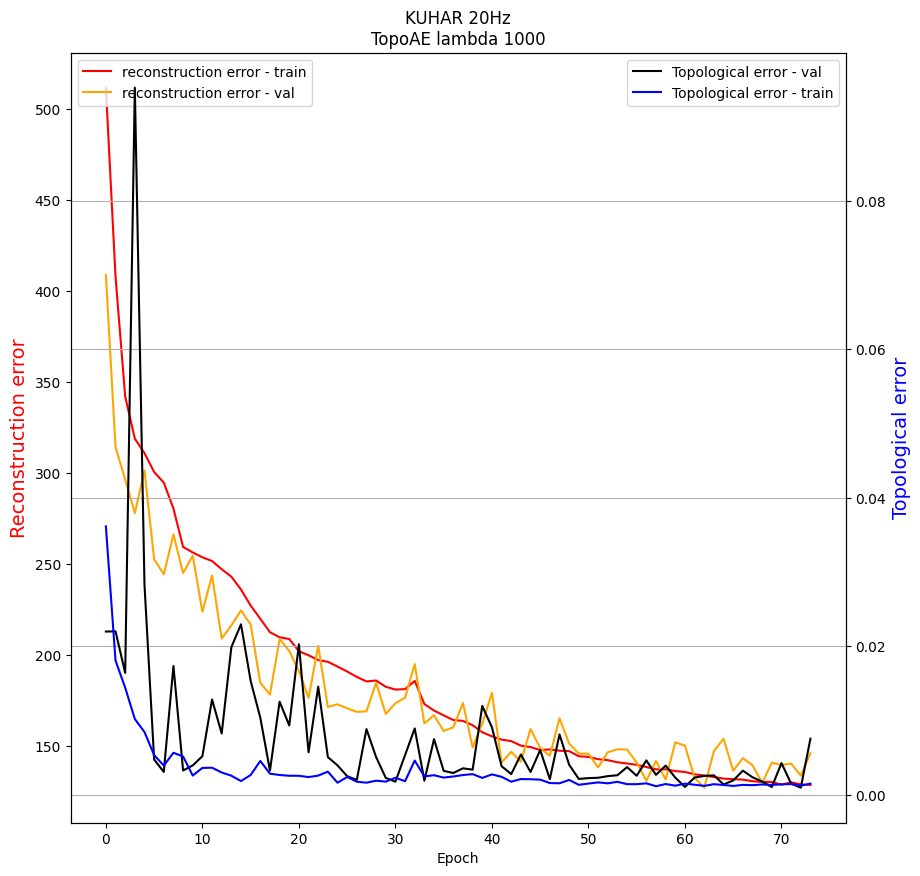

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:507.5870, Loss-ae:467.9946, Loss-topo:0.0396
Epoch:2, P:10, Loss:417.1165, Loss-ae:357.3059, Loss-topo:0.0598
Epoch:3, P:10, Loss:573.1195, Loss-ae:378.3103, Loss-topo:0.1948
Epoch:4, P:9, Loss:307.2363, Loss-ae:284.3373, Loss-topo:0.0229
Epoch:5, P:10, Loss:293.3498, Loss-ae:274.4291, Loss-topo:0.0189
Epoch:6, P:10, Loss:271.2442, Loss-ae:261.6400, Loss-topo:0.0096
Epoch:7, P:10, Loss:308.3697, Loss-ae:295.9320, Loss-topo:0.0124
Epoch:8, P:9, Loss:225.7999, Loss-ae:223.5178, Loss-topo:0.0023
Epoch:9, P:10, Loss:275.4530, Loss-ae:249.8914, Loss-topo:0.0256
Epoch:10, P:9, Loss:271.8607, Loss-ae:230.0981, Loss-topo:0.0418
Epoch:11, P:8, Loss:225.7041, Loss-ae:220.9201, Loss-topo:0.0048
Epoch:12, P:10, Loss:227.6874, Loss-ae:224.2086, Loss-topo:0.0035
Epoch:13, P:9, Loss:253.7818, Loss-ae:248.7413, Loss-topo:0.0050
Epoch:14, P:8, Loss:280.15

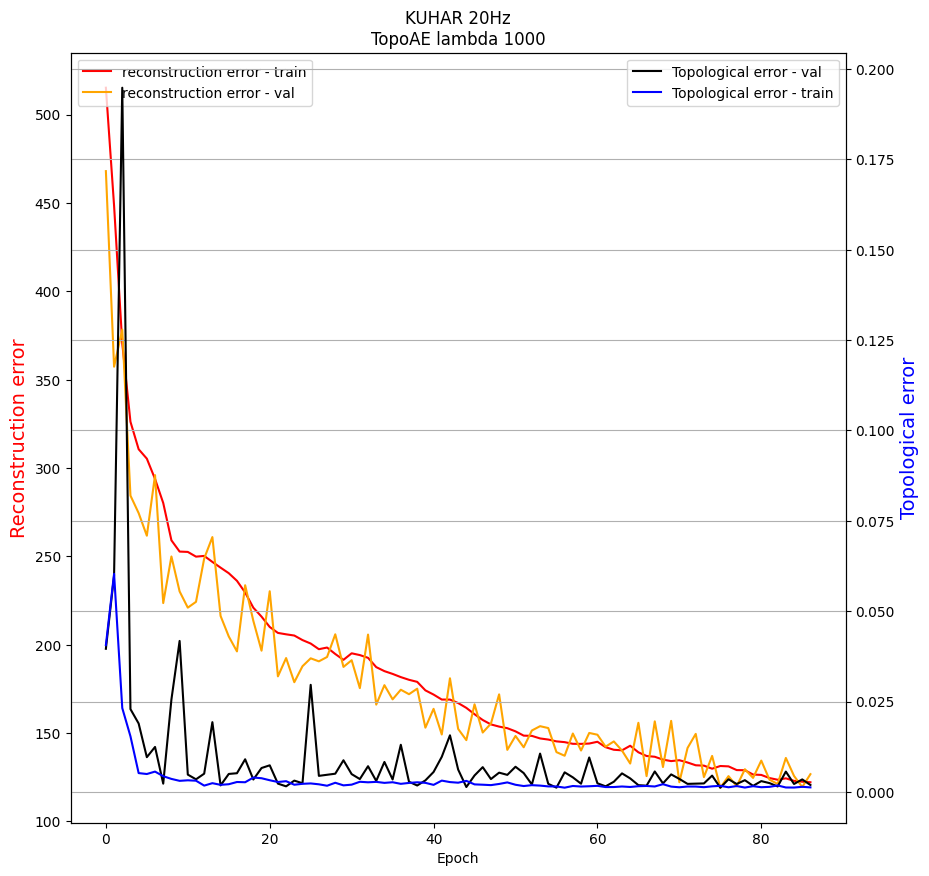

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:459.7380, Loss-ae:432.6907, Loss-topo:0.0054
Epoch:2, P:10, Loss:452.8427, Loss-ae:368.0344, Loss-topo:0.0170
Epoch:3, P:10, Loss:407.3491, Loss-ae:328.0356, Loss-topo:0.0159
Epoch:4, P:10, Loss:309.2375, Loss-ae:295.9959, Loss-topo:0.0026
Epoch:5, P:10, Loss:386.8039, Loss-ae:319.7797, Loss-topo:0.0134
Epoch:6, P:9, Loss:302.9603, Loss-ae:273.0305, Loss-topo:0.0060
Epoch:7, P:10, Loss:300.7956, Loss-ae:285.6894, Loss-topo:0.0030
Epoch:8, P:10, Loss:255.0913, Loss-ae:229.4765, Loss-topo:0.0051
Epoch:9, P:10, Loss:271.9536, Loss-ae:259.5090, Loss-topo:0.0025
Epoch:10, P:9, Loss:239.9018, Loss-ae:226.4703, Loss-topo:0.0027
Epoch:11, P:10, Loss:260.7773, Loss-ae:245.3754, Loss-topo:0.0031
Epoch:12, P:9, Loss:243.4821, Loss-ae:239.5451, Loss-topo:0.0008
Epoch:13, P:8, Loss:233.4097, Loss-ae:220.7041, Loss-topo:0.0025
Epoch:14, P:10, Loss:250.

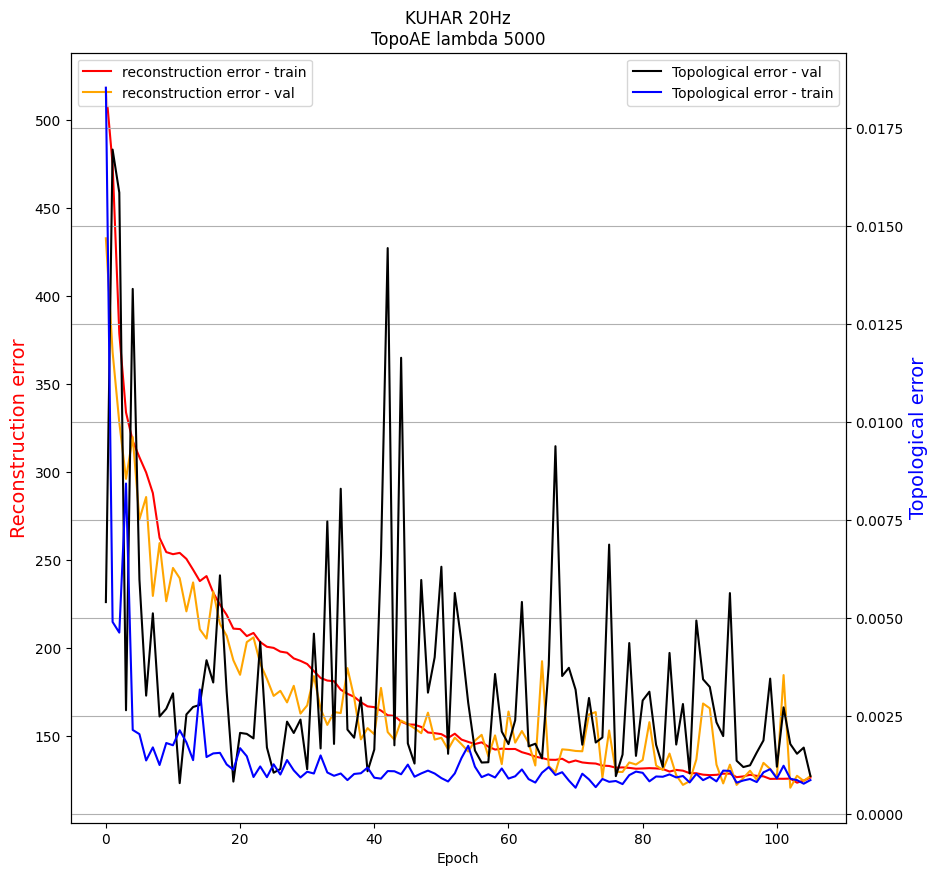

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:465.2134, Loss-ae:412.7766, Loss-topo:0.0105
Epoch:2, P:10, Loss:490.1523, Loss-ae:417.0045, Loss-topo:0.0146
Epoch:3, P:9, Loss:564.8590, Loss-ae:305.2571, Loss-topo:0.0519
Epoch:4, P:8, Loss:341.4976, Loss-ae:312.7986, Loss-topo:0.0057
Epoch:5, P:10, Loss:357.0150, Loss-ae:334.5390, Loss-topo:0.0045
Epoch:6, P:9, Loss:349.3299, Loss-ae:297.2076, Loss-topo:0.0104
Epoch:7, P:8, Loss:330.1173, Loss-ae:289.5490, Loss-topo:0.0081
Epoch:8, P:10, Loss:268.3182, Loss-ae:253.4452, Loss-topo:0.0030
Epoch:9, P:10, Loss:325.1619, Loss-ae:266.2218, Loss-topo:0.0118
Epoch:10, P:9, Loss:354.1378, Loss-ae:234.5476, Loss-topo:0.0239
Epoch:11, P:8, Loss:235.3531, Loss-ae:229.5145, Loss-topo:0.0012
Epoch:12, P:10, Loss:246.3257, Loss-ae:226.2355, Loss-topo:0.0040
Epoch:13, P:9, Loss:317.0148, Loss-ae:277.3571, Loss-topo:0.0079
Epoch:14, P:8, Loss:299.7708

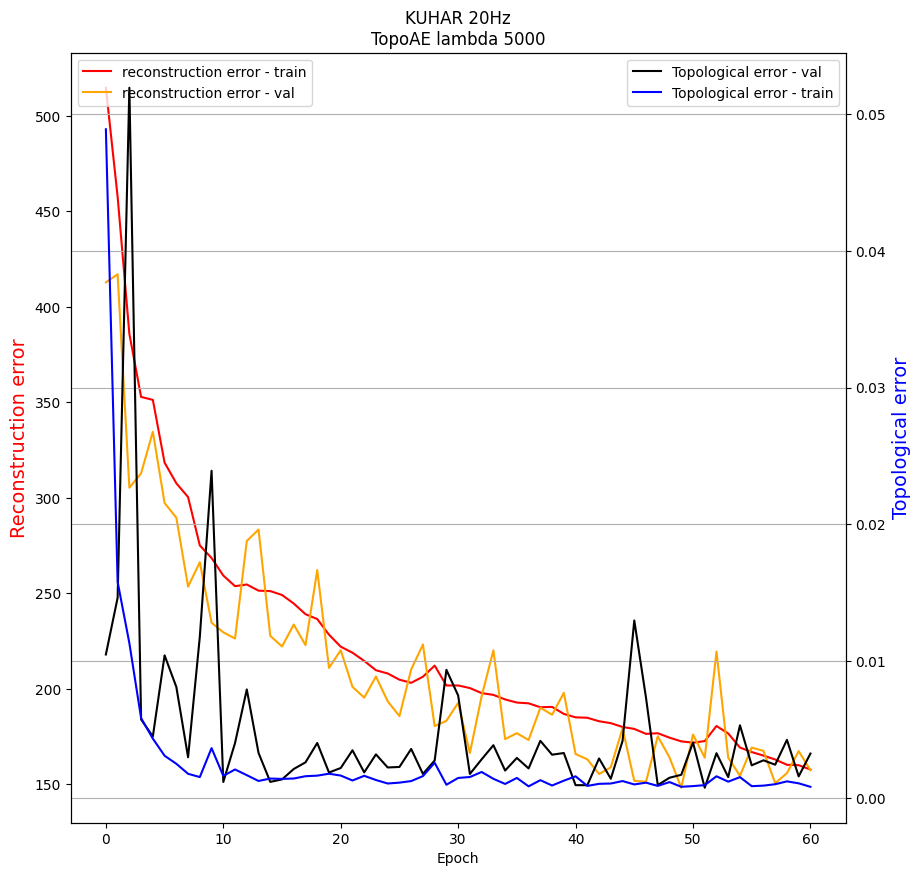

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:423.4023, Loss-ae:408.8718, Loss-topo:0.0029
Epoch:2, P:10, Loss:359.5921, Loss-ae:314.0670, Loss-topo:0.0091
Epoch:3, P:10, Loss:314.9228, Loss-ae:266.8768, Loss-topo:0.0096
Epoch:4, P:10, Loss:331.6200, Loss-ae:288.4378, Loss-topo:0.0086
Epoch:5, P:9, Loss:349.6418, Loss-ae:266.6474, Loss-topo:0.0166
Epoch:6, P:8, Loss:301.9016, Loss-ae:244.8085, Loss-topo:0.0114
Epoch:7, P:10, Loss:258.0400, Loss-ae:244.1939, Loss-topo:0.0028
Epoch:8, P:10, Loss:248.8771, Loss-ae:240.9780, Loss-topo:0.0016
Epoch:9, P:10, Loss:291.8971, Loss-ae:242.0013, Loss-topo:0.0100
Epoch:10, P:9, Loss:243.1370, Loss-ae:223.4587, Loss-topo:0.0039
Epoch:11, P:10, Loss:224.2101, Loss-ae:217.7472, Loss-topo:0.0013
Epoch:12, P:10, Loss:270.0681, Loss-ae:257.3997, Loss-topo:0.0025
Epoch:13, P:9, Loss:231.5850, Loss-ae:220.1245, Loss-topo:0.0023
Epoch:14, P:8, Loss:217.7

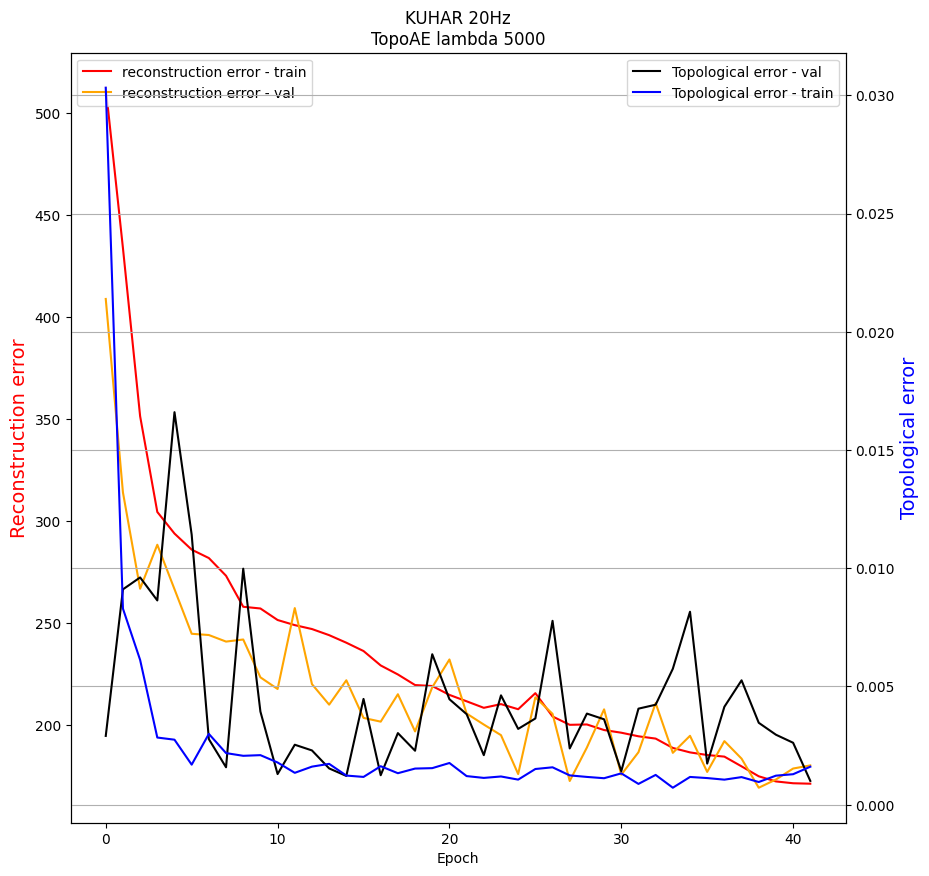

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:498.1111, Loss-ae:443.4957, Loss-topo:0.0109
Epoch:2, P:10, Loss:539.7453, Loss-ae:474.9294, Loss-topo:0.0130
Epoch:3, P:9, Loss:476.0591, Loss-ae:365.2628, Loss-topo:0.0222
Epoch:4, P:10, Loss:366.3559, Loss-ae:305.3692, Loss-topo:0.0122
Epoch:5, P:10, Loss:354.2696, Loss-ae:284.2517, Loss-topo:0.0140
Epoch:6, P:10, Loss:296.7360, Loss-ae:267.8134, Loss-topo:0.0058
Epoch:7, P:10, Loss:316.8119, Loss-ae:297.3827, Loss-topo:0.0039
Epoch:8, P:9, Loss:348.6837, Loss-ae:266.0829, Loss-topo:0.0165
Epoch:9, P:8, Loss:312.0027, Loss-ae:237.3065, Loss-topo:0.0149
Epoch:10, P:7, Loss:238.0421, Loss-ae:224.9065, Loss-topo:0.0026
Epoch:11, P:10, Loss:275.8876, Loss-ae:256.5873, Loss-topo:0.0039
Epoch:12, P:9, Loss:312.1707, Loss-ae:264.7913, Loss-topo:0.0095
Epoch:13, P:8, Loss:289.7529, Loss-ae:265.5002, Loss-topo:0.0049
Epoch:14, P:7, Loss:235.611

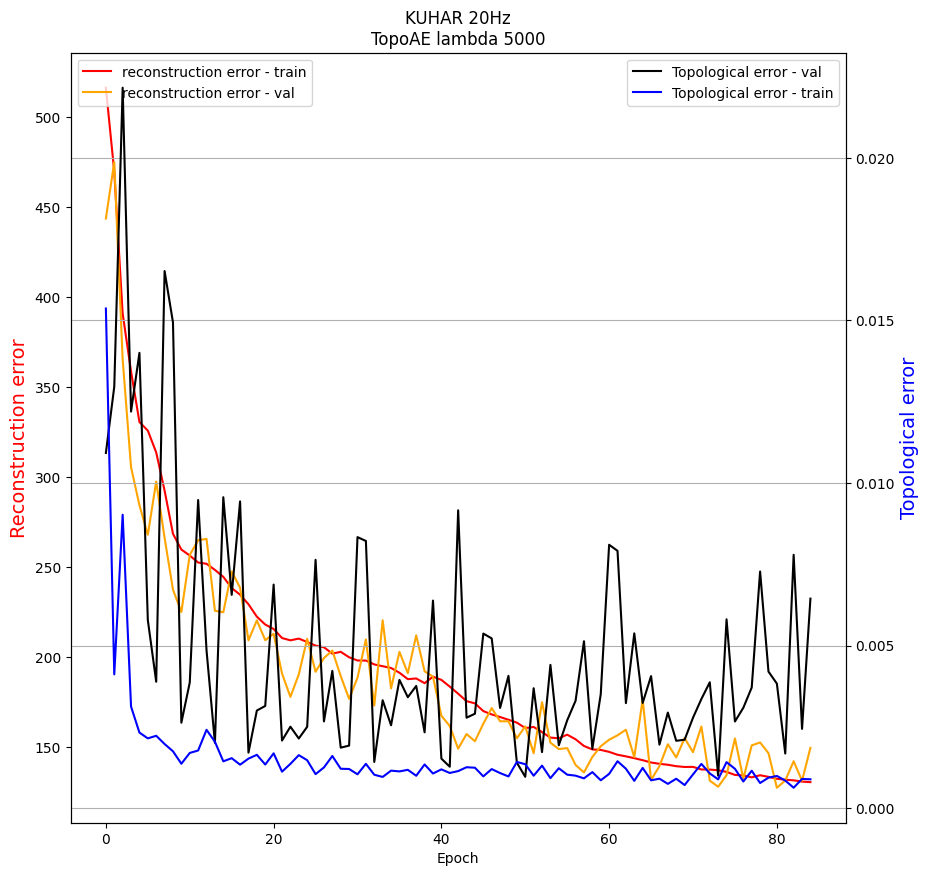

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:484.2046, Loss-ae:433.5118, Loss-topo:0.0101
Epoch:2, P:10, Loss:589.3821, Loss-ae:388.8441, Loss-topo:0.0401
Epoch:3, P:9, Loss:338.6354, Loss-ae:302.4138, Loss-topo:0.0072
Epoch:4, P:10, Loss:359.6534, Loss-ae:347.9763, Loss-topo:0.0023
Epoch:5, P:9, Loss:286.1054, Loss-ae:271.4508, Loss-topo:0.0029
Epoch:6, P:10, Loss:253.8177, Loss-ae:245.4752, Loss-topo:0.0017
Epoch:7, P:10, Loss:265.8478, Loss-ae:253.1788, Loss-topo:0.0025
Epoch:8, P:9, Loss:343.9280, Loss-ae:238.2158, Loss-topo:0.0211
Epoch:9, P:8, Loss:285.3167, Loss-ae:254.5209, Loss-topo:0.0062
Epoch:10, P:7, Loss:293.8830, Loss-ae:283.8213, Loss-topo:0.0020
Epoch:11, P:6, Loss:245.9001, Loss-ae:233.3949, Loss-topo:0.0025
Epoch:12, P:10, Loss:239.0552, Loss-ae:230.3207, Loss-topo:0.0017
Epoch:13, P:10, Loss:259.8628, Loss-ae:245.3993, Loss-topo:0.0029
Epoch:14, P:9, Loss:244.446

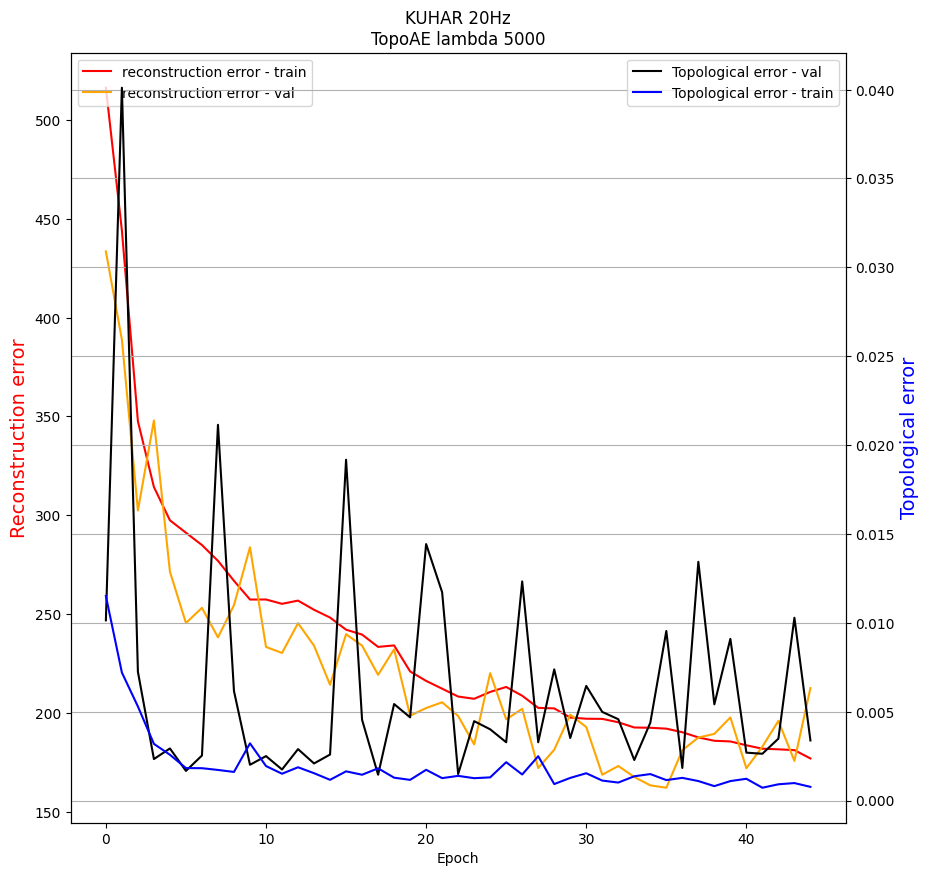

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:499.3553, Loss-ae:399.1328, Loss-topo:0.0200
Epoch:2, P:10, Loss:476.7939, Loss-ae:432.9972, Loss-topo:0.0088
Epoch:3, P:10, Loss:305.5593, Loss-ae:293.0077, Loss-topo:0.0025
Epoch:4, P:10, Loss:328.6085, Loss-ae:250.3825, Loss-topo:0.0156
Epoch:5, P:9, Loss:378.6307, Loss-ae:284.0149, Loss-topo:0.0189
Epoch:6, P:8, Loss:271.0756, Loss-ae:263.7214, Loss-topo:0.0015
Epoch:7, P:10, Loss:260.1757, Loss-ae:248.9626, Loss-topo:0.0022
Epoch:8, P:10, Loss:258.3002, Loss-ae:247.7394, Loss-topo:0.0021
Epoch:9, P:10, Loss:250.1783, Loss-ae:240.7338, Loss-topo:0.0019
Epoch:10, P:10, Loss:250.2437, Loss-ae:210.4663, Loss-topo:0.0080
Epoch:11, P:9, Loss:329.6053, Loss-ae:245.9817, Loss-topo:0.0167
Epoch:12, P:8, Loss:237.3176, Loss-ae:225.3925, Loss-topo:0.0024
Epoch:13, P:10, Loss:238.5897, Loss-ae:212.5160, Loss-topo:0.0052
Epoch:14, P:9, Loss:219.6

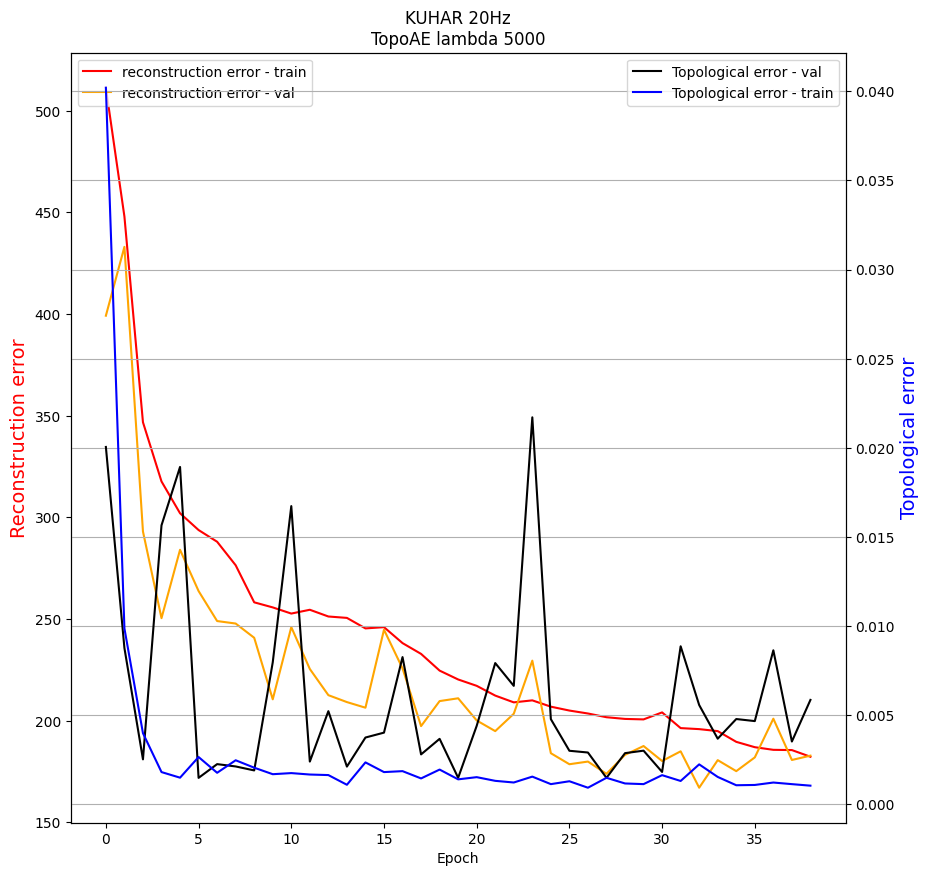

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:500.5117, Loss-ae:444.2994, Loss-topo:0.0112
Epoch:2, P:10, Loss:394.8608, Loss-ae:363.4224, Loss-topo:0.0063
Epoch:3, P:10, Loss:378.0412, Loss-ae:359.9725, Loss-topo:0.0036
Epoch:4, P:10, Loss:308.7954, Loss-ae:263.1445, Loss-topo:0.0091
Epoch:5, P:10, Loss:265.7790, Loss-ae:247.9844, Loss-topo:0.0036
Epoch:6, P:10, Loss:267.8212, Loss-ae:239.8873, Loss-topo:0.0056
Epoch:7, P:9, Loss:300.7122, Loss-ae:255.8203, Loss-topo:0.0090
Epoch:8, P:8, Loss:463.8670, Loss-ae:235.5017, Loss-topo:0.0457
Epoch:9, P:7, Loss:449.5074, Loss-ae:233.7277, Loss-topo:0.0432
Epoch:10, P:6, Loss:244.9801, Loss-ae:232.6682, Loss-topo:0.0025
Epoch:11, P:10, Loss:298.1619, Loss-ae:246.4396, Loss-topo:0.0103
Epoch:12, P:9, Loss:444.5303, Loss-ae:235.5109, Loss-topo:0.0418
Epoch:13, P:8, Loss:247.4584, Loss-ae:237.1550, Loss-topo:0.0021
Epoch:14, P:7, Loss:239.429

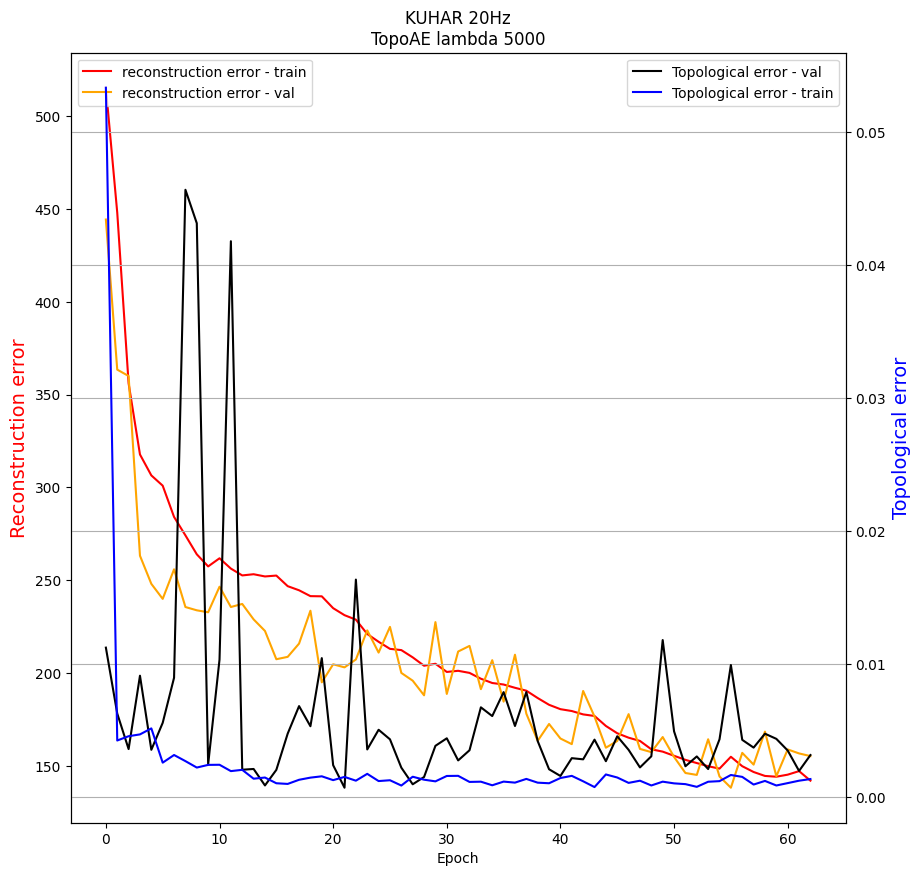

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:486.1546, Loss-ae:436.4654, Loss-topo:0.0099
Epoch:2, P:10, Loss:470.3828, Loss-ae:337.5632, Loss-topo:0.0266
Epoch:3, P:10, Loss:460.5248, Loss-ae:307.1357, Loss-topo:0.0307
Epoch:4, P:10, Loss:393.8940, Loss-ae:311.6468, Loss-topo:0.0164
Epoch:5, P:10, Loss:370.1784, Loss-ae:269.8005, Loss-topo:0.0201
Epoch:6, P:10, Loss:393.2882, Loss-ae:274.8839, Loss-topo:0.0237
Epoch:7, P:9, Loss:305.6637, Loss-ae:271.4475, Loss-topo:0.0068
Epoch:8, P:10, Loss:257.0804, Loss-ae:245.8075, Loss-topo:0.0023
Epoch:9, P:10, Loss:271.8201, Loss-ae:247.1539, Loss-topo:0.0049
Epoch:10, P:9, Loss:238.9021, Loss-ae:230.1974, Loss-topo:0.0017
Epoch:11, P:10, Loss:226.5504, Loss-ae:217.2861, Loss-topo:0.0019
Epoch:12, P:10, Loss:261.6504, Loss-ae:221.0696, Loss-topo:0.0081
Epoch:13, P:9, Loss:222.7086, Loss-ae:210.8164, Loss-topo:0.0024
Epoch:14, P:10, Loss:261

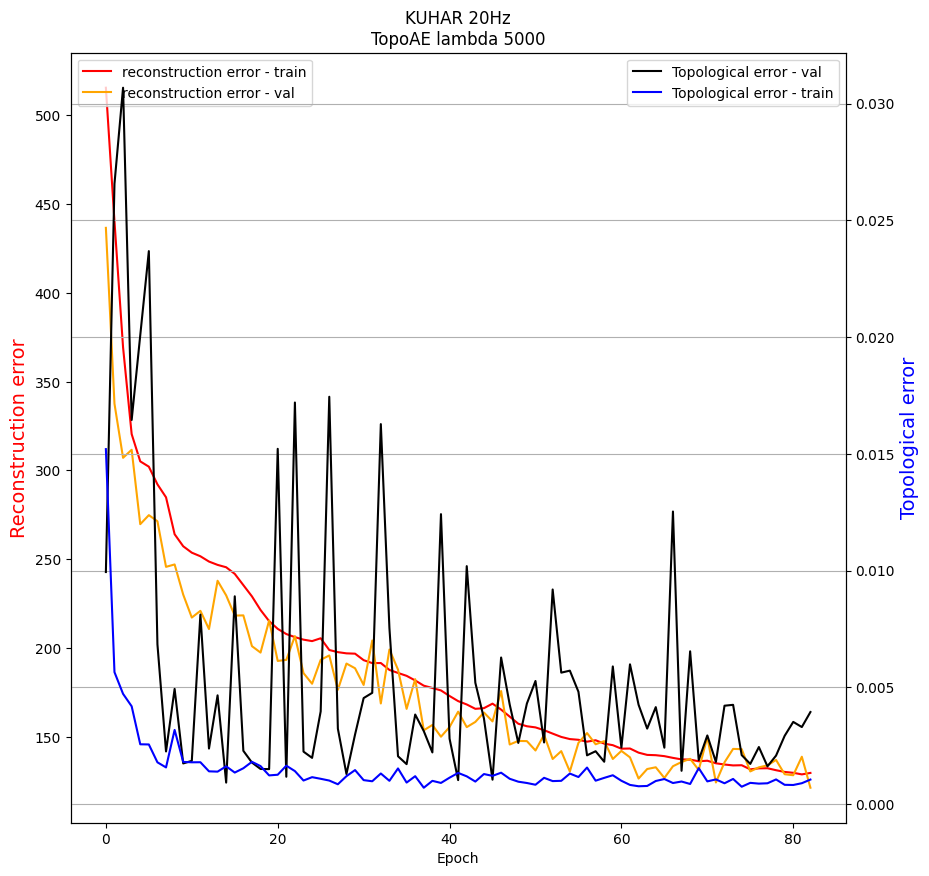

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:453.0812, Loss-ae:438.0981, Loss-topo:0.0030
Epoch:2, P:10, Loss:398.6035, Loss-ae:324.5472, Loss-topo:0.0148
Epoch:3, P:10, Loss:286.5506, Loss-ae:262.1812, Loss-topo:0.0049
Epoch:4, P:10, Loss:336.6763, Loss-ae:294.4346, Loss-topo:0.0084
Epoch:5, P:9, Loss:342.6296, Loss-ae:244.9895, Loss-topo:0.0195
Epoch:6, P:8, Loss:373.3405, Loss-ae:273.5083, Loss-topo:0.0200
Epoch:7, P:7, Loss:362.6925, Loss-ae:233.2453, Loss-topo:0.0259
Epoch:8, P:6, Loss:228.7053, Loss-ae:222.2924, Loss-topo:0.0013
Epoch:9, P:10, Loss:229.8629, Loss-ae:220.8313, Loss-topo:0.0018
Epoch:10, P:9, Loss:232.5910, Loss-ae:210.9477, Loss-topo:0.0043
Epoch:11, P:8, Loss:242.2481, Loss-ae:235.0977, Loss-topo:0.0014
Epoch:12, P:7, Loss:217.1824, Loss-ae:213.3804, Loss-topo:0.0008
Epoch:13, P:10, Loss:298.9005, Loss-ae:254.3455, Loss-topo:0.0089
Epoch:14, P:9, Loss:244.1687

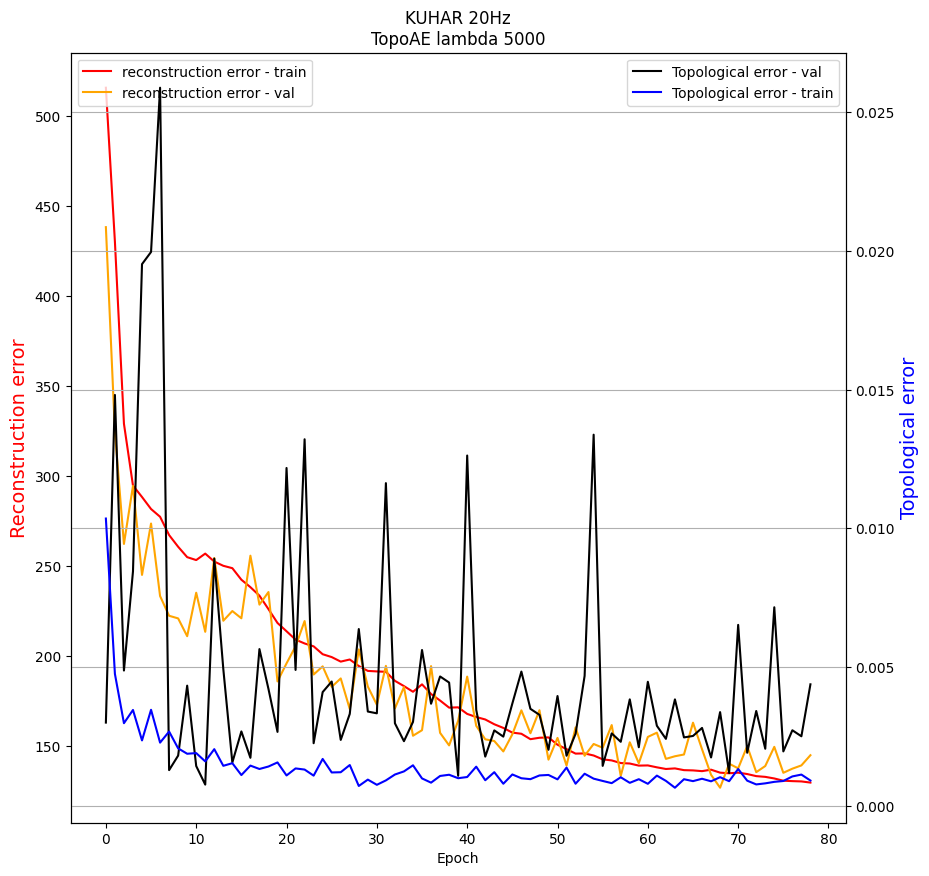

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:560.9396, Loss-ae:530.0040, Loss-topo:0.0062
Epoch:2, P:10, Loss:582.9733, Loss-ae:360.0886, Loss-topo:0.0446
Epoch:3, P:9, Loss:334.0521, Loss-ae:303.8114, Loss-topo:0.0060
Epoch:4, P:10, Loss:436.9163, Loss-ae:327.9634, Loss-topo:0.0218
Epoch:5, P:9, Loss:411.9139, Loss-ae:374.1875, Loss-topo:0.0075
Epoch:6, P:8, Loss:331.6444, Loss-ae:297.6071, Loss-topo:0.0068
Epoch:7, P:10, Loss:268.6394, Loss-ae:257.4747, Loss-topo:0.0022
Epoch:8, P:10, Loss:306.8288, Loss-ae:273.0538, Loss-topo:0.0068
Epoch:9, P:9, Loss:336.7708, Loss-ae:320.8662, Loss-topo:0.0032
Epoch:10, P:8, Loss:247.0203, Loss-ae:223.5980, Loss-topo:0.0047
Epoch:11, P:10, Loss:241.3599, Loss-ae:228.7846, Loss-topo:0.0025
Epoch:12, P:10, Loss:237.7786, Loss-ae:226.0597, Loss-topo:0.0023
Epoch:13, P:10, Loss:230.8010, Loss-ae:216.8674, Loss-topo:0.0028
Epoch:14, P:10, Loss:243.4

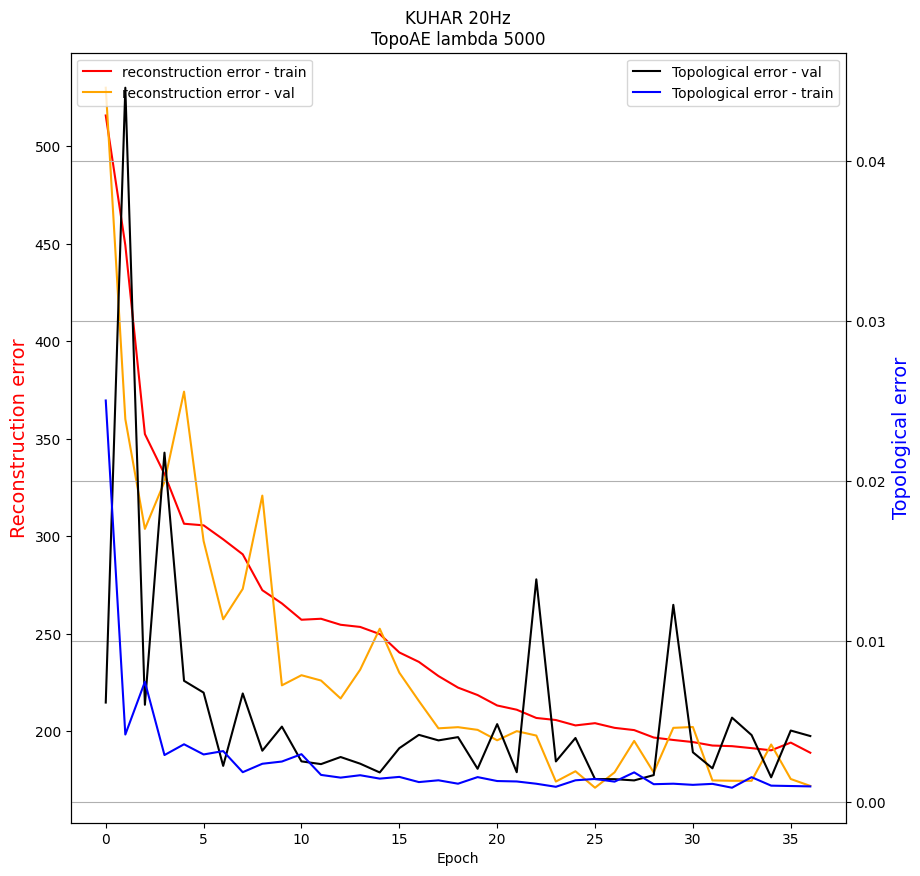

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:594.6641, Loss-ae:467.6826, Loss-topo:0.0127
Epoch:2, P:10, Loss:511.5576, Loss-ae:334.0815, Loss-topo:0.0177
Epoch:3, P:10, Loss:434.4170, Loss-ae:318.8015, Loss-topo:0.0116
Epoch:4, P:10, Loss:386.8482, Loss-ae:328.6273, Loss-topo:0.0058
Epoch:5, P:10, Loss:337.4263, Loss-ae:308.9487, Loss-topo:0.0028
Epoch:6, P:10, Loss:261.8036, Loss-ae:237.6718, Loss-topo:0.0024
Epoch:7, P:10, Loss:302.9549, Loss-ae:255.6693, Loss-topo:0.0047
Epoch:8, P:9, Loss:330.9327, Loss-ae:238.9755, Loss-topo:0.0092
Epoch:9, P:8, Loss:280.2512, Loss-ae:251.0885, Loss-topo:0.0029
Epoch:10, P:7, Loss:425.0234, Loss-ae:250.2692, Loss-topo:0.0175
Epoch:11, P:6, Loss:259.4710, Loss-ae:217.8806, Loss-topo:0.0042
Epoch:12, P:10, Loss:249.3834, Loss-ae:222.1651, Loss-topo:0.0027
Epoch:13, P:10, Loss:245.3310, Loss-ae:217.3034, Loss-topo:0.0028
Epoch:14, P:10, Loss:230.

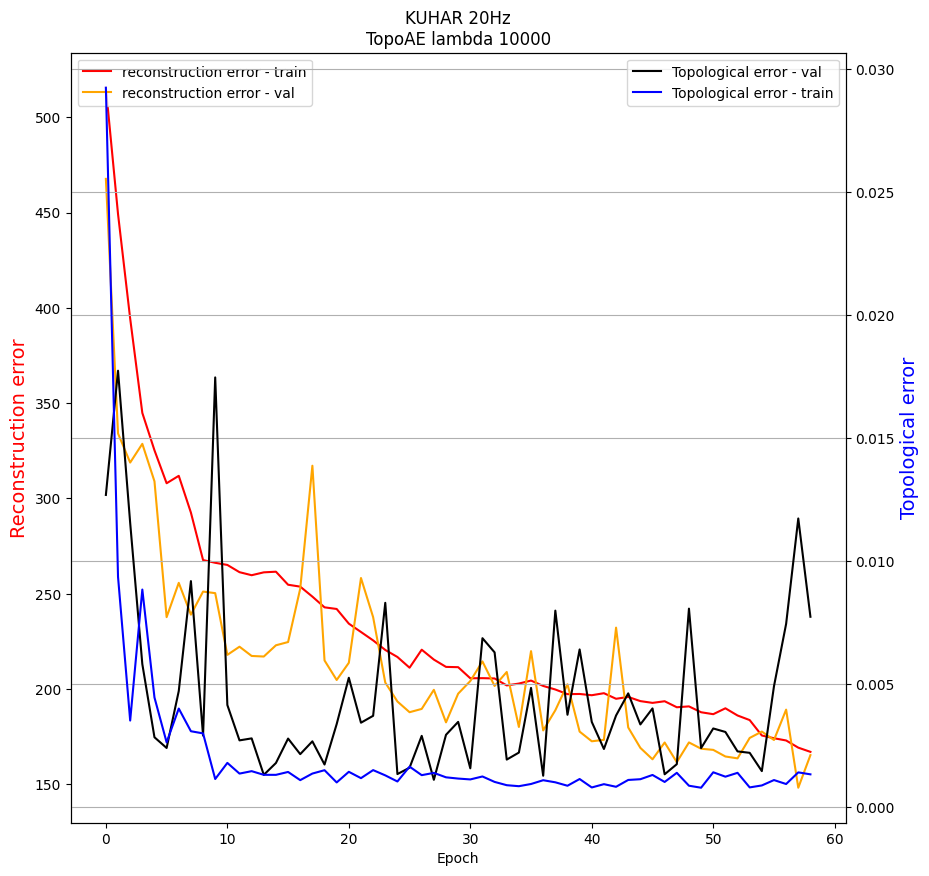

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:690.8364, Loss-ae:468.1753, Loss-topo:0.0223
Epoch:2, P:10, Loss:370.2722, Loss-ae:336.4320, Loss-topo:0.0034
Epoch:3, P:10, Loss:480.8962, Loss-ae:320.5885, Loss-topo:0.0160
Epoch:4, P:9, Loss:277.7241, Loss-ae:244.4821, Loss-topo:0.0033
Epoch:5, P:10, Loss:259.9174, Loss-ae:235.6412, Loss-topo:0.0024
Epoch:6, P:10, Loss:274.7843, Loss-ae:249.6423, Loss-topo:0.0025
Epoch:7, P:9, Loss:274.0122, Loss-ae:234.8387, Loss-topo:0.0039
Epoch:8, P:8, Loss:274.9331, Loss-ae:237.3111, Loss-topo:0.0038
Epoch:9, P:7, Loss:254.4864, Loss-ae:230.8302, Loss-topo:0.0024
Epoch:10, P:10, Loss:515.7682, Loss-ae:235.0704, Loss-topo:0.0281
Epoch:11, P:9, Loss:331.1163, Loss-ae:283.7489, Loss-topo:0.0047
Epoch:12, P:8, Loss:249.0496, Loss-ae:237.4339, Loss-topo:0.0012
Epoch:13, P:10, Loss:237.0205, Loss-ae:210.5768, Loss-topo:0.0026
Epoch:14, P:10, Loss:271.81

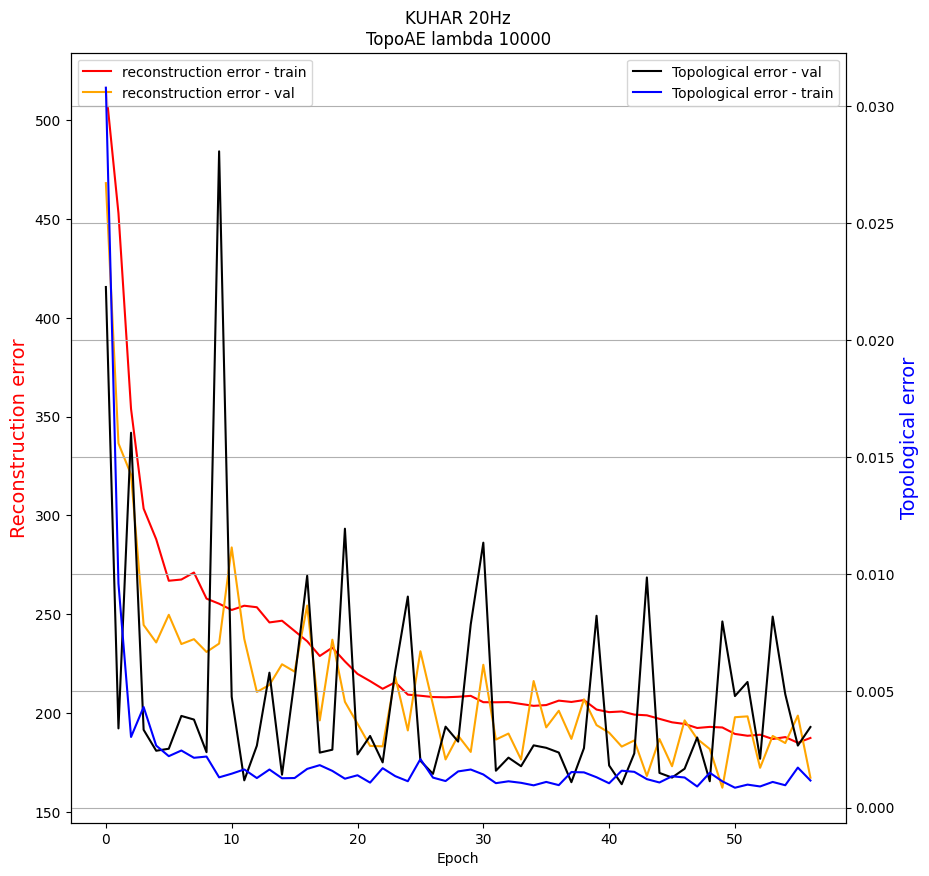

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:472.7887, Loss-ae:419.9564, Loss-topo:0.0053
Epoch:2, P:10, Loss:379.0460, Loss-ae:326.0235, Loss-topo:0.0053
Epoch:3, P:10, Loss:339.6877, Loss-ae:286.0078, Loss-topo:0.0054
Epoch:4, P:10, Loss:297.2990, Loss-ae:264.1195, Loss-topo:0.0033
Epoch:5, P:10, Loss:264.0686, Loss-ae:239.6656, Loss-topo:0.0024
Epoch:6, P:10, Loss:298.2953, Loss-ae:238.5241, Loss-topo:0.0060
Epoch:7, P:9, Loss:273.4324, Loss-ae:255.6759, Loss-topo:0.0018
Epoch:8, P:8, Loss:325.8272, Loss-ae:278.4695, Loss-topo:0.0047
Epoch:9, P:7, Loss:345.8396, Loss-ae:241.8827, Loss-topo:0.0104
Epoch:10, P:6, Loss:261.9469, Loss-ae:227.8975, Loss-topo:0.0034
Epoch:11, P:10, Loss:273.2404, Loss-ae:231.2467, Loss-topo:0.0042
Epoch:12, P:9, Loss:291.2653, Loss-ae:259.9073, Loss-topo:0.0031
Epoch:13, P:8, Loss:313.9213, Loss-ae:259.6931, Loss-topo:0.0054
Epoch:14, P:7, Loss:291.711

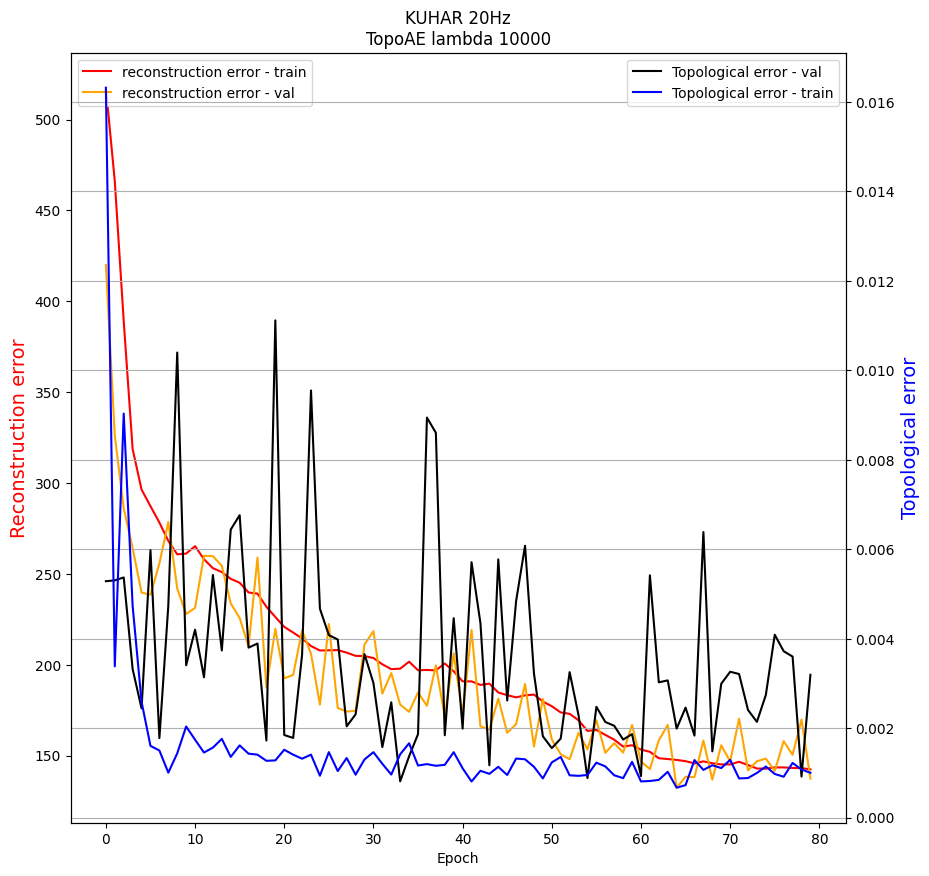

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:1494.7156, Loss-ae:453.8108, Loss-topo:0.1041
Epoch:2, P:10, Loss:428.2523, Loss-ae:374.2106, Loss-topo:0.0054
Epoch:3, P:10, Loss:348.9627, Loss-ae:334.7081, Loss-topo:0.0014
Epoch:4, P:10, Loss:327.1033, Loss-ae:265.8106, Loss-topo:0.0061
Epoch:5, P:10, Loss:308.5773, Loss-ae:270.4411, Loss-topo:0.0038
Epoch:6, P:10, Loss:491.3537, Loss-ae:265.8558, Loss-topo:0.0225
Epoch:7, P:9, Loss:354.2435, Loss-ae:259.3800, Loss-topo:0.0095
Epoch:8, P:8, Loss:282.7490, Loss-ae:254.3069, Loss-topo:0.0028
Epoch:9, P:10, Loss:272.5050, Loss-ae:238.4076, Loss-topo:0.0034
Epoch:10, P:10, Loss:281.8333, Loss-ae:242.2087, Loss-topo:0.0040
Epoch:11, P:9, Loss:283.6543, Loss-ae:256.9015, Loss-topo:0.0027
Epoch:12, P:8, Loss:269.7460, Loss-ae:212.0415, Loss-topo:0.0058
Epoch:13, P:10, Loss:312.8594, Loss-ae:287.0220, Loss-topo:0.0026
Epoch:14, P:9, Loss:236.

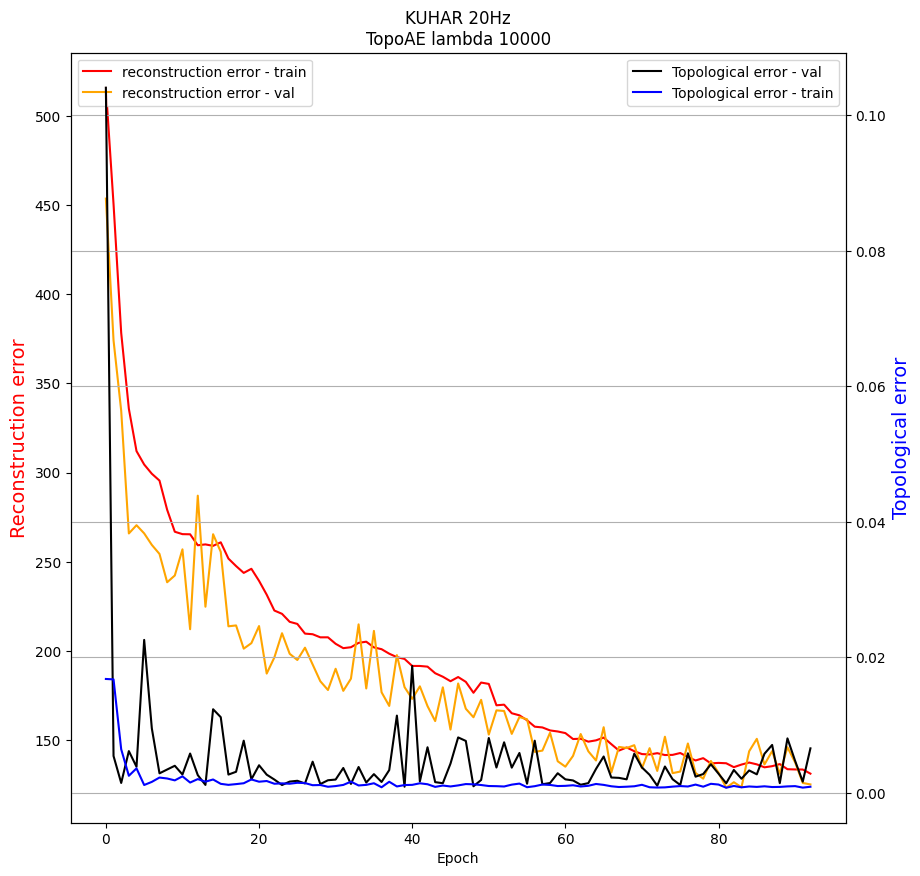

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:631.4696, Loss-ae:456.4774, Loss-topo:0.0175
Epoch:2, P:10, Loss:435.6328, Loss-ae:336.8942, Loss-topo:0.0099
Epoch:3, P:10, Loss:322.3997, Loss-ae:281.9380, Loss-topo:0.0040
Epoch:4, P:10, Loss:367.3002, Loss-ae:251.5012, Loss-topo:0.0116
Epoch:5, P:9, Loss:307.7403, Loss-ae:276.3520, Loss-topo:0.0031
Epoch:6, P:10, Loss:626.1227, Loss-ae:271.5425, Loss-topo:0.0355
Epoch:7, P:9, Loss:289.1253, Loss-ae:255.9026, Loss-topo:0.0033
Epoch:8, P:10, Loss:379.0019, Loss-ae:279.9303, Loss-topo:0.0099
Epoch:9, P:9, Loss:293.1293, Loss-ae:245.4800, Loss-topo:0.0048
Epoch:10, P:8, Loss:305.0919, Loss-ae:232.1525, Loss-topo:0.0073
Epoch:11, P:7, Loss:275.8602, Loss-ae:214.6358, Loss-topo:0.0061
Epoch:12, P:10, Loss:286.0242, Loss-ae:270.5062, Loss-topo:0.0016
Epoch:13, P:9, Loss:256.4268, Loss-ae:227.4958, Loss-topo:0.0029
Epoch:14, P:10, Loss:288.30

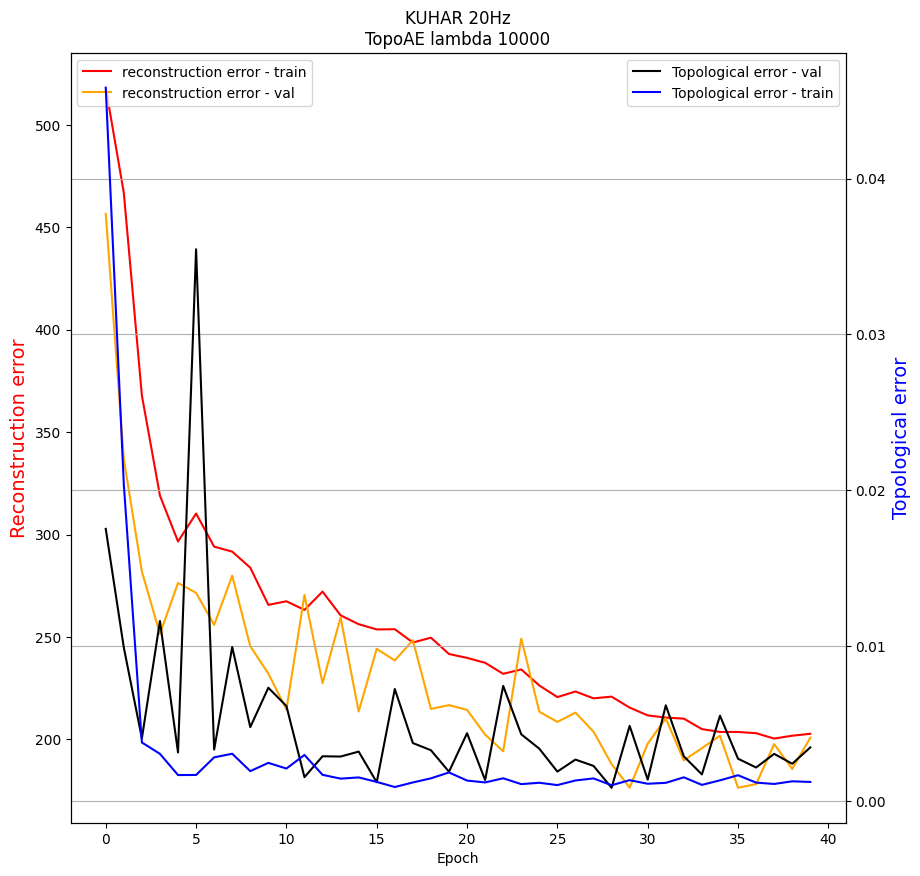

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:1045.0042, Loss-ae:456.5562, Loss-topo:0.0588
Epoch:2, P:10, Loss:417.7665, Loss-ae:368.9951, Loss-topo:0.0049
Epoch:3, P:10, Loss:386.4190, Loss-ae:308.8403, Loss-topo:0.0078
Epoch:4, P:10, Loss:335.4424, Loss-ae:287.3085, Loss-topo:0.0048
Epoch:5, P:10, Loss:349.3284, Loss-ae:258.3657, Loss-topo:0.0091
Epoch:6, P:9, Loss:295.0370, Loss-ae:253.0281, Loss-topo:0.0042
Epoch:7, P:10, Loss:374.0235, Loss-ae:333.5784, Loss-topo:0.0040
Epoch:8, P:9, Loss:356.5696, Loss-ae:286.3267, Loss-topo:0.0070
Epoch:9, P:8, Loss:487.7372, Loss-ae:237.9001, Loss-topo:0.0250
Epoch:10, P:7, Loss:364.4856, Loss-ae:251.2330, Loss-topo:0.0113
Epoch:11, P:6, Loss:293.7750, Loss-ae:241.6048, Loss-topo:0.0052
Epoch:12, P:10, Loss:237.5992, Loss-ae:216.0121, Loss-topo:0.0022
Epoch:13, P:10, Loss:280.9729, Loss-ae:259.3989, Loss-topo:0.0022
Epoch:14, P:9, Loss:239.0

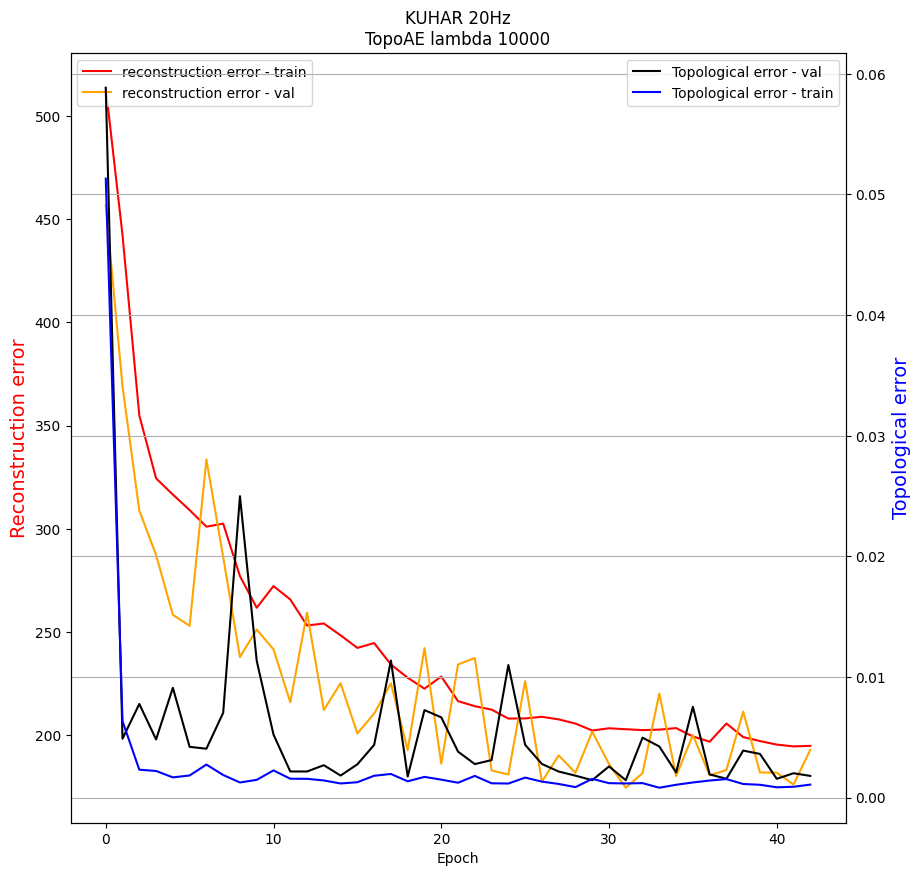

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:1226.7401, Loss-ae:524.6528, Loss-topo:0.0702
Epoch:2, P:10, Loss:399.4893, Loss-ae:334.9320, Loss-topo:0.0065
Epoch:3, P:10, Loss:405.7032, Loss-ae:347.1873, Loss-topo:0.0059
Epoch:4, P:9, Loss:294.9560, Loss-ae:261.4796, Loss-topo:0.0033
Epoch:5, P:10, Loss:340.6901, Loss-ae:291.9198, Loss-topo:0.0049
Epoch:6, P:9, Loss:361.6559, Loss-ae:285.8156, Loss-topo:0.0076
Epoch:7, P:8, Loss:295.2544, Loss-ae:252.8883, Loss-topo:0.0042
Epoch:8, P:7, Loss:297.6310, Loss-ae:275.8877, Loss-topo:0.0022
Epoch:9, P:6, Loss:285.6459, Loss-ae:264.9039, Loss-topo:0.0021
Epoch:10, P:10, Loss:260.0793, Loss-ae:217.0470, Loss-topo:0.0043
Epoch:11, P:10, Loss:257.2295, Loss-ae:235.7784, Loss-topo:0.0021
Epoch:12, P:10, Loss:301.1061, Loss-ae:263.2930, Loss-topo:0.0038
Epoch:13, P:9, Loss:282.0256, Loss-ae:265.2573, Loss-topo:0.0017
Epoch:14, P:8, Loss:315.49

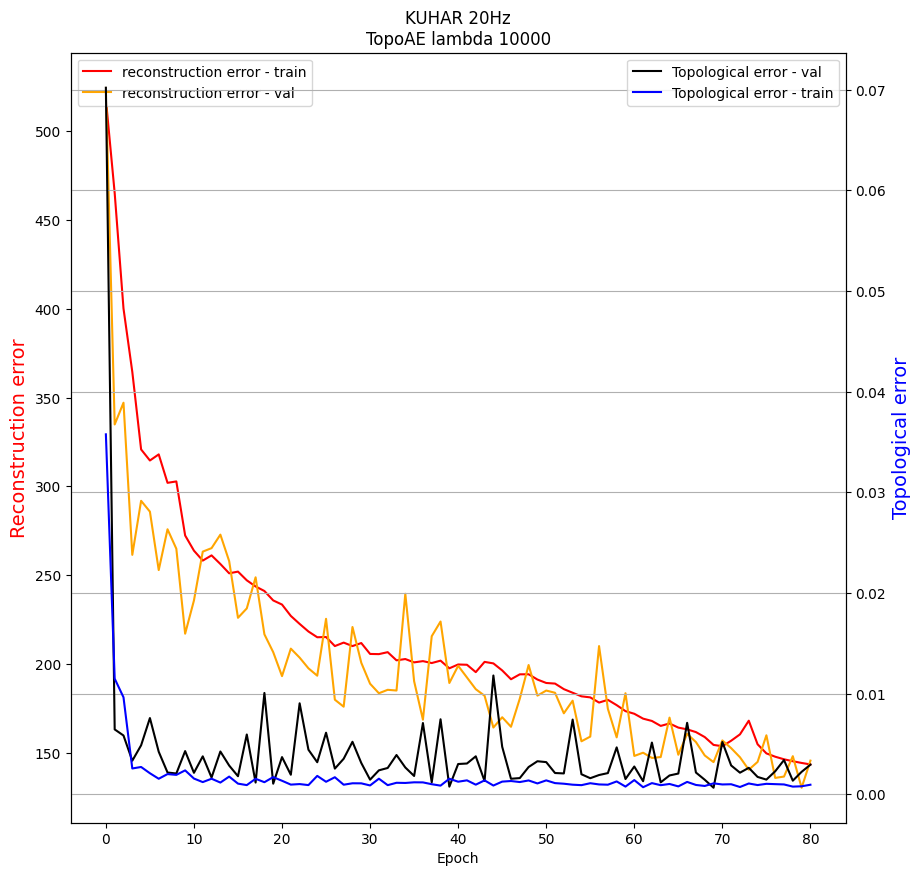

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:694.5672, Loss-ae:459.4739, Loss-topo:0.0235
Epoch:2, P:10, Loss:713.2707, Loss-ae:326.1600, Loss-topo:0.0387
Epoch:3, P:9, Loss:290.8081, Loss-ae:265.3828, Loss-topo:0.0025
Epoch:4, P:10, Loss:318.3178, Loss-ae:285.2502, Loss-topo:0.0033
Epoch:5, P:9, Loss:487.3906, Loss-ae:272.3467, Loss-topo:0.0215
Epoch:6, P:8, Loss:331.0746, Loss-ae:246.4202, Loss-topo:0.0085
Epoch:7, P:7, Loss:268.2896, Loss-ae:246.0454, Loss-topo:0.0022
Epoch:8, P:10, Loss:304.2332, Loss-ae:249.1315, Loss-topo:0.0055
Epoch:9, P:9, Loss:276.5446, Loss-ae:253.6498, Loss-topo:0.0023
Epoch:10, P:8, Loss:473.0620, Loss-ae:245.2837, Loss-topo:0.0228
Epoch:11, P:7, Loss:254.0623, Loss-ae:213.3190, Loss-topo:0.0041
Epoch:12, P:10, Loss:242.2475, Loss-ae:228.5815, Loss-topo:0.0014
Epoch:13, P:10, Loss:316.6063, Loss-ae:257.5293, Loss-topo:0.0059
Epoch:14, P:9, Loss:247.4094

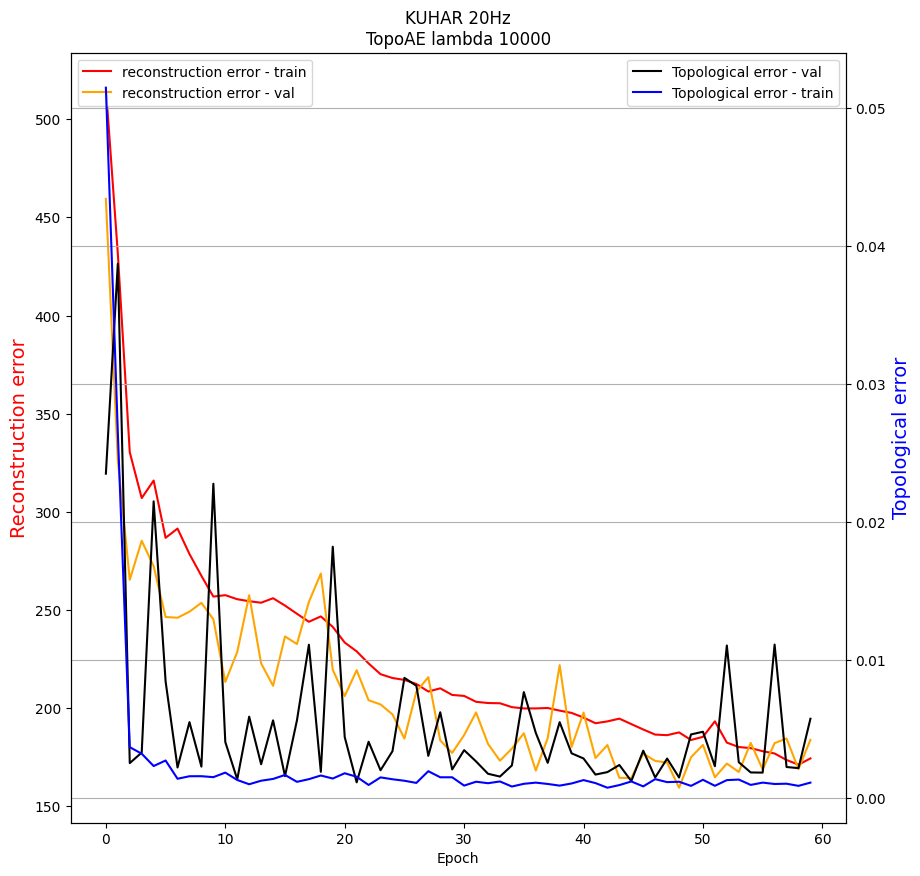

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:569.4140, Loss-ae:436.2049, Loss-topo:0.0133
Epoch:2, P:10, Loss:450.5502, Loss-ae:395.3919, Loss-topo:0.0055
Epoch:3, P:10, Loss:305.9256, Loss-ae:284.8341, Loss-topo:0.0021
Epoch:4, P:10, Loss:398.2975, Loss-ae:274.6187, Loss-topo:0.0124
Epoch:5, P:9, Loss:334.7881, Loss-ae:242.6263, Loss-topo:0.0092
Epoch:6, P:8, Loss:303.5717, Loss-ae:239.0033, Loss-topo:0.0065
Epoch:7, P:10, Loss:303.4275, Loss-ae:279.9618, Loss-topo:0.0023
Epoch:8, P:10, Loss:253.3931, Loss-ae:233.4829, Loss-topo:0.0020
Epoch:9, P:10, Loss:266.4293, Loss-ae:251.4111, Loss-topo:0.0015
Epoch:10, P:9, Loss:267.7962, Loss-ae:218.4436, Loss-topo:0.0049
Epoch:11, P:8, Loss:266.7783, Loss-ae:237.2989, Loss-topo:0.0029
Epoch:12, P:7, Loss:272.1333, Loss-ae:236.6162, Loss-topo:0.0036
Epoch:13, P:6, Loss:345.1556, Loss-ae:254.8035, Loss-topo:0.0090
Epoch:14, P:5, Loss:247.806

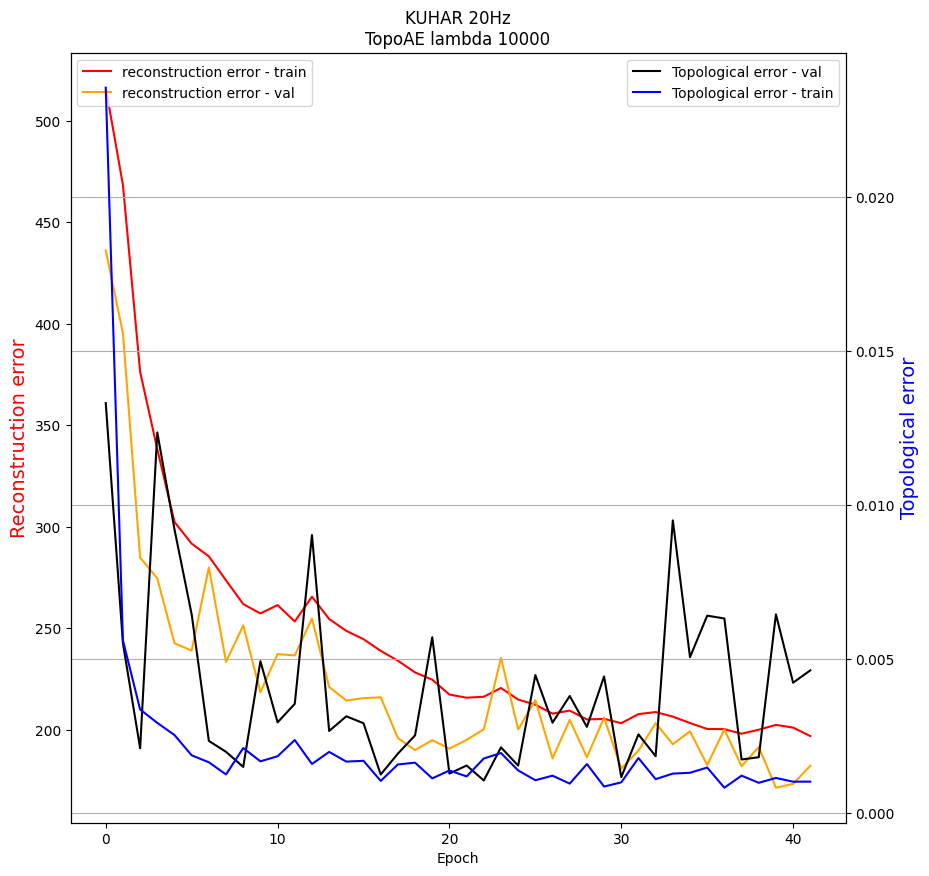

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2
Epoch:1, P:10, Loss:599.4141, Loss-ae:464.5220, Loss-topo:0.0135
Epoch:2, P:10, Loss:588.7762, Loss-ae:408.8306, Loss-topo:0.0180
Epoch:3, P:10, Loss:319.4310, Loss-ae:284.2790, Loss-topo:0.0035
Epoch:4, P:10, Loss:310.5116, Loss-ae:272.9789, Loss-topo:0.0038
Epoch:5, P:10, Loss:304.3032, Loss-ae:261.5199, Loss-topo:0.0043
Epoch:6, P:10, Loss:293.6407, Loss-ae:263.6289, Loss-topo:0.0030
Epoch:7, P:10, Loss:500.4895, Loss-ae:245.2434, Loss-topo:0.0255
Epoch:8, P:9, Loss:289.1735, Loss-ae:236.9868, Loss-topo:0.0052
Epoch:9, P:10, Loss:297.5243, Loss-ae:272.3388, Loss-topo:0.0025
Epoch:10, P:9, Loss:323.8562, Loss-ae:241.0833, Loss-topo:0.0083
Epoch:11, P:8, Loss:279.4773, Loss-ae:263.9888, Loss-topo:0.0015
Epoch:12, P:10, Loss:263.3572, Loss-ae:247.2498, Loss-topo:0.0016
Epoch:13, P:10, Loss:273.9267, Loss-ae:223.0662, Loss-topo:0.0051
Epoch:14, P:9, Loss:331.

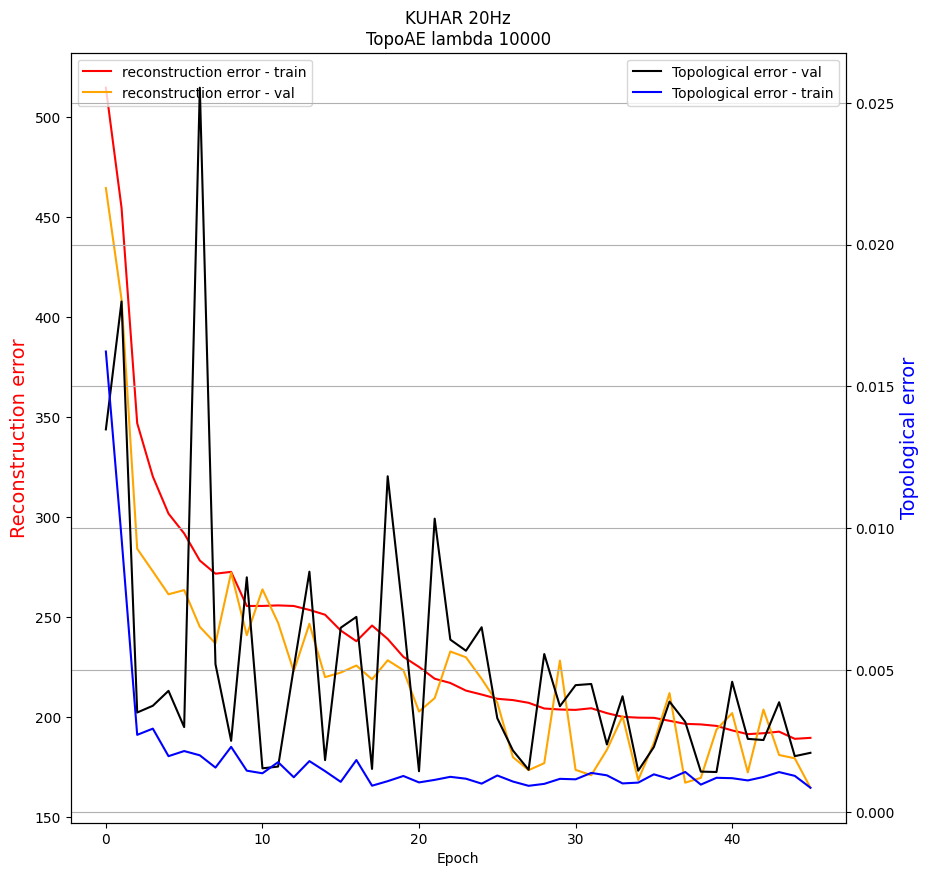

In [13]:
plot_object = {
    'RF-ACC': [],
    'RF-F1': [],
    'SVC-ACC': [],
    'SVC-F1': [],
    'KNN-ACC': [],
    'KNN-F1': [],
    'Trustworthiness': [],
    'Continuity': [],
    'Co-k-NNs': []   
}

for lambda_val in lambdas_to_explore:
    lambda_exploration = explore_lambda(
        train_HD, train_Y,
        test_HD, test_Y,
        lambda_val,
        times_to_execute=10
    )
    # print(lambda_val, lambda_exploration)
    for obj_property in plot_object:
        plot_object[obj_property].append(lambda_exploration[obj_property])
    
# print(plot_object)

In [14]:
print(plot_object)

{'RF-ACC': [(0.4306878306878307, 0.4735185185185185, 0.5404761904761906), (0.42777777777777776, 0.48283068783068783, 0.5354497354497355), (0.4354497354497354, 0.47603174603174603, 0.5044973544973546), (0.456084656084656, 0.48732804232804233, 0.5201058201058202), (0.40317460317460324, 0.4545767195767196, 0.5201058201058201), (0.40423280423280417, 0.43277777777777776, 0.5034391534391535)], 'RF-F1': [(0.43376415359244547, 0.4807483041024688, 0.5512075818472036), (0.4455190673351823, 0.49248504986374575, 0.5426349494578925), (0.4425252510146823, 0.4853125337615135, 0.5168073355093602), (0.46008895262409943, 0.4966477122471704, 0.5263263333810158), (0.4104215080131584, 0.4661805714780023, 0.5286584641917266), (0.41795378203052047, 0.44328729457454263, 0.5200551415929209)], 'SVC-ACC': [(0.3994708994708995, 0.4391534391534392, 0.5132275132275133), (0.3968253968253968, 0.4478835978835978, 0.5079365079365079), (0.4074074074074074, 0.4743386243386244, 0.5158730158730159), (0.4417989417989418, 0.

In [21]:
plot_object_saved = {'RF-ACC': [(0.4306878306878307, 0.4735185185185185, 0.5404761904761906), (0.42777777777777776, 0.48283068783068783, 0.5354497354497355), (0.4354497354497354, 0.47603174603174603, 0.5044973544973546), (0.456084656084656, 0.48732804232804233, 0.5201058201058202), (0.40317460317460324, 0.4545767195767196, 0.5201058201058201), (0.40423280423280417, 0.43277777777777776, 0.5034391534391535)], 'RF-F1': [(0.43376415359244547, 0.4807483041024688, 0.5512075818472036), (0.4455190673351823, 0.49248504986374575, 0.5426349494578925), (0.4425252510146823, 0.4853125337615135, 0.5168073355093602), (0.46008895262409943, 0.4966477122471704, 0.5263263333810158), (0.4104215080131584, 0.4661805714780023, 0.5286584641917266), (0.41795378203052047, 0.44328729457454263, 0.5200551415929209)], 'SVC-ACC': [(0.3994708994708995, 0.4391534391534392, 0.5132275132275133), (0.3968253968253968, 0.4478835978835978, 0.5079365079365079), (0.4074074074074074, 0.4743386243386244, 0.5158730158730159), (0.4417989417989418, 0.4835978835978835, 0.5238095238095238), (0.37037037037037035, 0.46005291005291005, 0.5343915343915344), (0.373015873015873, 0.42354497354497356, 0.5211640211640212)], 'SVC-F1': [(0.4583998199190939, 0.48719316628917914, 0.5475990792040243), (0.44052313304995316, 0.4920103494539173, 0.5559996353687003), (0.4304518780984424, 0.5068989421902362, 0.5546738896772), (0.47266602774736116, 0.5127297328794109, 0.5416450610683861), (0.38422405109018276, 0.48996397241398426, 0.5601521121003017), (0.40397265929863047, 0.46464828279069315, 0.5504135859733523)], 'KNN-ACC': [(0.41534391534391535, 0.4523809523809524, 0.5026455026455027), (0.41798941798941797, 0.4568783068783069, 0.4947089947089947), (0.41534391534391535, 0.45634920634920634, 0.5052910052910053), (0.43915343915343913, 0.4560846560846561, 0.47354497354497355), (0.3783068783068783, 0.43386243386243384, 0.5026455026455027), (0.36772486772486773, 0.4060846560846561, 0.5)], 'KNN-F1': [(0.4183306134648575, 0.4590953119456989, 0.5101487276672801), (0.4370093422227406, 0.4656260523252338, 0.49744033164748885), (0.4299151712760825, 0.4622207640776814, 0.5122463600677284), (0.4460383359616493, 0.46086870006750685, 0.47311186088434587), (0.3817773786887912, 0.44058394466971623, 0.5045547335357312), (0.3794179610983289, 0.4137040104773321, 0.5041038017875252)], 'Trustworthiness': [(0.8523249961424573, 0.8874896213729914, 0.8978283871062551), (0.8589186389119525, 0.8871935090413455, 0.910846675532892), (0.8590242621071735, 0.8804995242363903, 0.9038094153434683), (0.8636872965605413, 0.8812976222841062, 0.902462489988758), (0.8440909792280505, 0.8738694644261079, 0.8895231893428951), (0.8478144264752345, 0.8706189335547441, 0.8905486527991066)], 'Continuity': [(0.9420271019934312, 0.957197945215545, 0.9627926221738907), (0.9440500157975562, 0.9544685500047759, 0.9638460987383998), (0.9354637684886515, 0.9470902646641732, 0.9618874773139746), (0.9315704056665467, 0.9422969003725286, 0.9561773955340677), (0.9298680352983534, 0.9416055735982424, 0.9541503486483904), (0.9314854478790863, 0.9405935196955113, 0.9494193479650543)], 'Co-k-NNs': [(0.3541114058355438, 0.42136936339522546, 0.4452917771883289), (0.3677055702917772, 0.4126657824933687, 0.4708222811671088), (0.35858753315649866, 0.3934018567639257, 0.4353448275862069), (0.3531167108753316, 0.38804708222811674, 0.425895225464191), (0.32161803713527853, 0.3817473474801061, 0.430868700265252), (0.319131299734748, 0.3693302387267904, 0.4046750663129973)]}
plot_object_saved

{'RF-ACC': [(0.4306878306878307, 0.4735185185185185, 0.5404761904761906),
  (0.42777777777777776, 0.48283068783068783, 0.5354497354497355),
  (0.4354497354497354, 0.47603174603174603, 0.5044973544973546),
  (0.456084656084656, 0.48732804232804233, 0.5201058201058202),
  (0.40317460317460324, 0.4545767195767196, 0.5201058201058201),
  (0.40423280423280417, 0.43277777777777776, 0.5034391534391535)],
 'RF-F1': [(0.43376415359244547, 0.4807483041024688, 0.5512075818472036),
  (0.4455190673351823, 0.49248504986374575, 0.5426349494578925),
  (0.4425252510146823, 0.4853125337615135, 0.5168073355093602),
  (0.46008895262409943, 0.4966477122471704, 0.5263263333810158),
  (0.4104215080131584, 0.4661805714780023, 0.5286584641917266),
  (0.41795378203052047, 0.44328729457454263, 0.5200551415929209)],
 'SVC-ACC': [(0.3994708994708995, 0.4391534391534392, 0.5132275132275133),
  (0.3968253968253968, 0.4478835978835978, 0.5079365079365079),
  (0.4074074074074074, 0.4743386243386244, 0.5158730158730159

## Plot ALL means

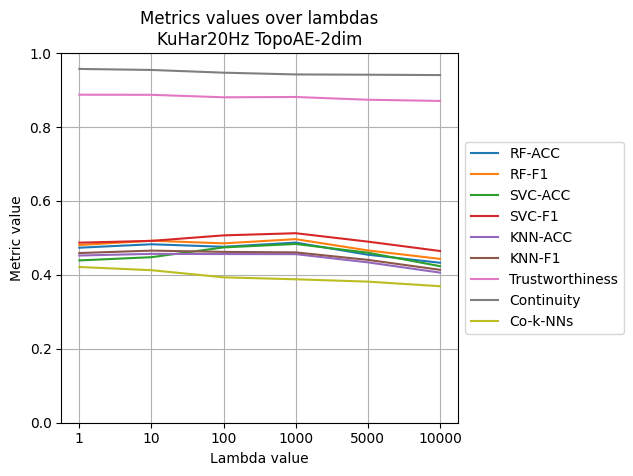

In [15]:
data_x = range(len(lambdas_to_explore))
plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
for obj_property in plot_object:
    data_y = [val[1] for val in plot_object[obj_property]]
    plt.plot(data_x, data_y, label=obj_property)

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
plt.xlabel('Lambda value')
plt.ylabel('Metric value')
plt.grid()
plt.ylim((0, 1))
plt.show()

## Plot Metrics

In [16]:
def plot_properties(plot_object, lambdas_to_explore, properties_to_plot):
    fig, ax = plt.subplots()
    data_x = range(len(lambdas_to_explore))
    plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
    for obj_property in properties_to_plot:
        mean_y = [val[1] for val in plot_object[obj_property]]
        min_y = [val[0] for val in plot_object[obj_property]]
        max_y = [val[2] for val in plot_object[obj_property]]
        ax.plot(data_x, mean_y, label=obj_property)
        ax.fill_between(data_x, min_y, max_y, alpha=0.2)

    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
    plt.xlabel('Lambda value')
    plt.ylabel('Metric value')
    plt.grid()
    plt.ylim((0, 1))
    plt.show()

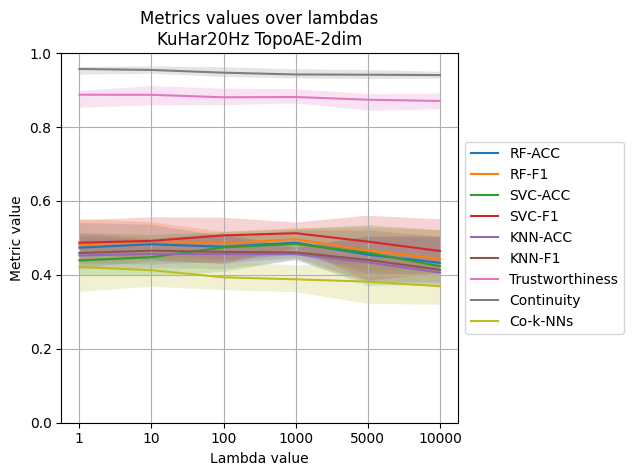

In [17]:
properties_to_plot = [
    'RF-ACC', 'RF-F1',
    'SVC-ACC', 'SVC-F1',
    'KNN-ACC', 'KNN-F1',
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

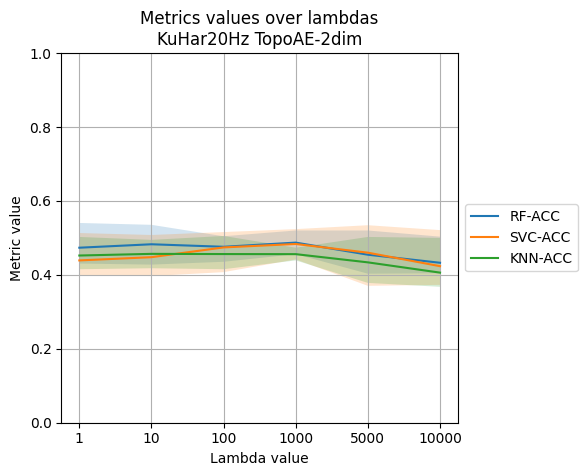

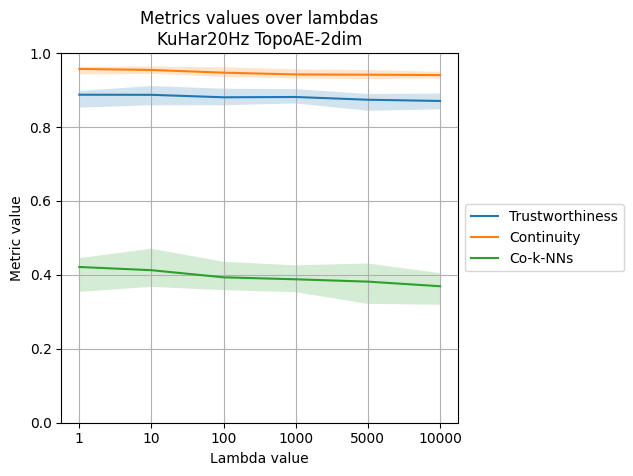

In [18]:
properties_to_plot = [
    'RF-ACC',
    'SVC-ACC',
    'KNN-ACC'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)
properties_to_plot = [
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

In [19]:
assert 1 ==0
asda = {'asd': [2, 3], 'asdasd': [3,4,5]}
for i in asda:
    asda[i] = np.mean(asda[i])
print(asda)

AssertionError: 

In [ ]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 10000
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

In [ ]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['Topo-AEv2 (L=10000)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=10000)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=10000)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['Topo-AEv2 (L=10000)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=10000)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [ ]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

In [ ]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['UMAP'][0] = experiments_result['RF-ACC']
table_info['UMAP'][1] = experiments_result['RF-F1']
table_info['UMAP'][2] = experiments_result['SVC-ACC']
table_info['UMAP'][3] = experiments_result['SVC-F1']
table_info['UMAP'][4] = experiments_result['KNN-ACC']
table_info['UMAP'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=1000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 1000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=1000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=1000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=1000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=1000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=1000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=1000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=1000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=1000)'][7] = metrics_report['continuity']
table_info['M-AE (L=1000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=10000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 10000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=10000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=10000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=10000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=10000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=10000)'][7] = metrics_report['continuity']
table_info['M-AE (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run